In [2]:
from bertopic import BERTopic
import numpy as np
import pandas as pd
from transformers import pipeline
from bertopic.representation import TextGeneration
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import datetime
import nltk
from nltk.corpus import stopwords
import logging
import os
from dotenv import load_dotenv
from umap import UMAP
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
import openai
import spacy
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from sklearn.metrics import silhouette_score
import os
from datetime import datetime
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator

# Auxiliary Functions

In [3]:
def auto_save_figure(fig, figure_name, save_formats=['png'], 
                    width=1000, height=700, scale=2, output_dir="../../outputs/plots"):
    """
    Automatically save any Plotly or Matplotlib figure to disk with multiple formats and timestamp
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure or matplotlib.figure.Figure
        The figure to save (supports both Plotly and Matplotlib)
    figure_name : str
        Descriptive name for the figure (will be used in filename)
    save_formats : list
        List of formats to save ['png', 'html', 'pdf', 'svg', 'jpeg']
    width : int
        Width of the saved image
    height : int
        Height of the saved image
    scale : int
        Scale factor for image resolution (higher = better quality)
    output_dir : str
        Directory to save the figures
    
    Returns:
    --------
    dict : Dictionary with saved file paths
    """
    if fig is None:
        print(f"❌ No figure provided for '{figure_name}'")
        return {}
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    saved_files = {}
    
    # Detect figure type
    is_plotly = hasattr(fig, 'write_image') and hasattr(fig, 'write_html')
    is_matplotlib = hasattr(fig, 'savefig')
    
    if not is_plotly and not is_matplotlib:
        print(f"❌ Unsupported figure type for '{figure_name}': {type(fig)}")
        return {}
    
    for format_type in save_formats:
        # Clean figure name for filename (remove spaces, special chars)
        clean_name = "".join(c for c in figure_name if c.isalnum() or c in (' ', '-', '_')).rstrip()
        clean_name = clean_name.replace(' ', '_').lower()
        
        filename = f"{timestamp}_{clean_name}.{format_type}"
        filepath = os.path.join(output_dir, filename)
        
        try:
            if is_plotly:
                # Handle Plotly figures
                if format_type == 'html':
                    fig.write_html(filepath)
                    print(f"📊 Saved {figure_name} as HTML: {filename}")
                elif format_type in ['png', 'pdf', 'svg', 'jpeg']:
                    fig.write_image(
                        filepath,
                        width=width,
                        height=height,
                        scale=scale,
                        format=format_type
                    )
                    print(f"🖼️  Saved {figure_name} as {format_type.upper()}: {filename}")
                    
            elif is_matplotlib:
                # Handle Matplotlib figures
                if format_type == 'html':
                    # Convert matplotlib to HTML via mpld3 (if available) or skip
                    try:
                        import mpld3
                        html_str = mpld3.fig_to_html(fig)
                        with open(filepath, 'w') as f:
                            f.write(html_str)
                        print(f"📊 Saved {figure_name} as HTML: {filename}")
                    except ImportError:
                        print(f"⚠️  Skipping HTML for matplotlib figure '{figure_name}' (mpld3 not available)")
                        continue
                elif format_type in ['png', 'pdf', 'svg', 'jpeg']:
                    # Set DPI based on scale
                    dpi = 100 * scale
                    fig.savefig(
                        filepath,
                        format=format_type,
                        dpi=dpi,
                        bbox_inches='tight',
                        facecolor='white',
                        edgecolor='none'
                    )
                    print(f"🖼️  Saved {figure_name} as {format_type.upper()}: {filename}")
            
            saved_files[format_type] = os.path.abspath(filepath)
            
        except Exception as e:
            print(f"❌ Error saving {figure_name} as {format_type}: {e}")
    
    if saved_files:
        print(f"✅ Total saved: {len(saved_files)} file(s) for '{figure_name}'")
        print(f"📁 Location: {os.path.abspath(output_dir)}")
        print("-" * 60)
    
    return saved_files

In [4]:
def enhance_bertopic_figure(fig, viz_type):
    """
    Enhance BERTopic figures with specific optimizations for each visualization type
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure
        The BERTopic figure to enhance
    viz_type : str
        Type of visualization ('topics', 'topics_per_class', 'heatmap', etc.)
    
    Returns:
    --------
    plotly.graph_objects.Figure : Enhanced figure
    """
    if fig is None:
        return fig
        
    try:
        if viz_type == 'topics':
            # Fix intertopic distance map cropping issues
            fig.update_layout(
                # Increase margins to prevent cropping
                margin=dict(l=80, r=80, t=100, b=80),
                # Ensure proper aspect ratio
                width=1200,
                height=900,
                # Add padding to prevent cluster cutoff
                xaxis=dict(
                    range=None,  # Let plotly auto-scale
                    automargin=True,
                    showgrid=True,
                    gridcolor='rgba(0,0,0,0.1)'
                ),
                yaxis=dict(
                    range=None,  # Let plotly auto-scale  
                    automargin=True,
                    showgrid=True,
                    gridcolor='rgba(0,0,0,0.1)'
                ),
                # Improve title positioning
                title=dict(
                    x=0.5,
                    xanchor='center',
                    y=0.95,
                    font=dict(size=16)
                )
            )
            
        elif viz_type == 'topics_per_class':
            # Ensure all topics are visible (not just the first one)
            # Make all traces visible by default
            if hasattr(fig, 'data'):
                for trace in fig.data:
                    trace.visible = True
                    
            # Improve layout for topics per class
            fig.update_layout(
                margin=dict(l=60, r=60, t=120, b=60),
                width=1200,
                height=800,
                # Ensure legend is visible and functional
                showlegend=True,
                legend=dict(
                    orientation="v",
                    yanchor="top",
                    y=1,
                    xanchor="left",
                    x=1.02,
                    bgcolor='rgba(255,255,255,0.8)',
                    bordercolor='rgba(0,0,0,0.3)',
                    borderwidth=1
                ),
                # Improve title
                title=dict(
                    x=0.5,
                    xanchor='center',
                    font=dict(size=16)
                )
            )
            
        elif viz_type == 'heatmap':
            # Optimize heatmap layout
            fig.update_layout(
                margin=dict(l=120, r=80, t=100, b=120),
                width=1000,
                height=700
            )
            
        elif viz_type == 'document_datamap':
            # Optimize document datamap
            fig.update_layout(
                margin=dict(l=80, r=80, t=100, b=80),
                width=1200,
                height=900
            )
            
        elif viz_type == 'hierarchy':
            # Optimize hierarchy plot
            fig.update_layout(
                margin=dict(l=100, r=100, t=100, b=100),
                width=1400,
                height=800
            )
            
    except Exception as e:
        print(f"⚠️  Warning: Could not enhance {viz_type} figure: {e}")
        
    return fig

In [5]:
def get_figure_dimensions(fig):
    """
    Safely extract width and height from a Plotly figure
    """
    try:
        # Try to access width and height from layout
        layout = fig.layout if hasattr(fig, 'layout') else None
        if layout:
            width = getattr(layout, 'width', None) or 1000
            height = getattr(layout, 'height', None) or 700
            return width, height
    except:
        pass
    
    # Fallback to defaults
    return 1000, 700

In [6]:
# Enhanced wrapper function for BERTopic visualizations with optimizations
def save_bertopic_figure_enhanced(fig, viz_type, group_name="Female_ADHD", apply_enhancements=True, **kwargs):
    """
    Enhanced function for saving BERTopic visualizations with automatic optimizations
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure or matplotlib.figure.Figure
        The BERTopic figure to save
    viz_type : str
        Type of visualization ('topics', 'heatmap', 'hierarchy', 'topics_per_class', etc.)
    group_name : str
        Name of the group being analyzed
    apply_enhancements : bool
        Whether to apply BERTopic-specific enhancements (default: True)
    **kwargs : additional arguments passed to auto_save_figure
    """
    # Apply enhancements if requested and if it's a Plotly figure
    if apply_enhancements and hasattr(fig, 'update_layout'):
        print(f"🔧 Applying {viz_type} specific optimizations...")
        fig = enhance_bertopic_figure(fig, viz_type)
    
    figure_name = f"bertopic_{viz_type}_{group_name}"
    
    # Set default high-quality settings for BERTopic figures
    kwargs.setdefault('save_formats', ['png', 'html'])
    kwargs.setdefault('scale', 2)
    
    # Safely get figure dimensions
    width, height = get_figure_dimensions(fig)
    kwargs.setdefault('width', width)
    kwargs.setdefault('height', height)
    
    return auto_save_figure(fig, figure_name, **kwargs)

In [7]:
def translate_topic_words(topic_model, target_language='en', source_language='pt'):
    """
    Translate topic words from Portuguese to English
    """
    translator = GoogleTranslator(source=source_language, target=target_language)
    
    # Hardcoded translations for specific terms
    hardcoded_translations = {
        'phda': 'adhd',
        'PHDA': 'ADHD',
        'Phda': 'ADHD'
    }
    
    topics_dict = topic_model.get_topics()
    translated_topics = {}
    
    for topic_id, words_scores in topics_dict.items():
        if topic_id == -1:  # Skip noise topic
            continue
            
        # Extract just the words (first element of each tuple)
        words = [word for word, score in words_scores]
        
        # Translate words
        try:
            translated_words = []
            for word in words:
                # Check if we have a hardcoded translation first
                if word in hardcoded_translations:
                    translated = hardcoded_translations[word]
                else:
                    translated = translator.translate(word)
                translated_words.append(translated)
            
            # Keep the same scores but with translated words
            translated_topic = [(translated_words[i], score) for i, (word, score) in enumerate(words_scores)]
            translated_topics[topic_id] = translated_topic
            
        except Exception as e:
            print(f"Error translating topic {topic_id}: {e}")
            # Keep original if translation fails
            translated_topics[topic_id] = words_scores
    
    return translated_topics

In [8]:
def visualize_barchart_translated_fixed(topic_model, translated_topics, topics=None, top_k_topics=6, n_words=5, 
                                        custom_labels=True, title="<b>Topic Word Scores</b>", 
                                        width=800, height=600):
    """
    Create a bar chart visualization in the exact same style as BERTopic's visualize_barchart
    but with translated words - FIXED VERSION for proper label mapping
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Get topic information and prepare data
    topic_info = topic_model.get_topic_info()
    
    # Select topics to show (excluding outliers/noise topic -1)
    if topics is None:
        # Get top k topics by size (excluding noise topic -1)
        selected_topics = topic_info[topic_info['Topic'] != -1].head(top_k_topics)['Topic'].tolist()
    else:
        # Filter out -1 from provided topics
        selected_topics = [t for t in topics if t != -1]
    
    # Filter selected_topics to only include those that exist in translated_topics
    available_topics = [topic_id for topic_id in selected_topics if topic_id in translated_topics]
    
    print(f"DEBUG: Available topics for plotting: {available_topics}")
    
    # Create subplot titles ONLY for the topics that will actually be plotted
    # The key fix: properly map topic IDs to their position in the topic_info dataframe
    subplot_titles = []
    for topic_id in available_topics:
        if custom_labels and hasattr(topic_model, 'custom_labels_') and topic_model.custom_labels_:
            # Find the topic in topic_info and get its custom label
            topic_row = topic_info[topic_info['Topic'] == topic_id]
            if not topic_row.empty and 'CustomName' in topic_row.columns:
                topic_label = topic_row.iloc[0]['CustomName']
            elif not topic_row.empty and 'Name' in topic_row.columns:
                topic_label = topic_row.iloc[0]['Name']
            else:
                # Fallback: try to get from custom_labels_ array using topic position
                # Find the position of this topic in the topic_info (excluding outliers)
                non_outlier_topics = topic_info[topic_info['Topic'] != -1]
                topic_position = None
                for idx, row in non_outlier_topics.iterrows():
                    if row['Topic'] == topic_id:
                        topic_position = list(non_outlier_topics.index).index(idx)
                        break
                
                if topic_position is not None and topic_position < len(topic_model.custom_labels_):
                    topic_label = topic_model.custom_labels_[topic_position]
                else:
                    topic_label = f"Topic {topic_id}"
        else:
            topic_label = f"Topic {topic_id}"
        
        print(f"DEBUG: Topic {topic_id} -> Label: {topic_label}")
        subplot_titles.append(topic_label)
    
    # Prepare subplot structure - one row per topic that will actually be plotted
    n_topics = len(available_topics)
    if n_topics == 0:
        print("No topics available for plotting")
        return None
        
    fig = make_subplots(
        rows=n_topics, 
        cols=1,
        shared_xaxes=False,
        vertical_spacing=0.08,
        subplot_titles=subplot_titles
    )
    
    # Color scheme similar to BERTopic
    colors = ["#D55E00", "#0072B2", "#CC79A7", "#E69F00", "#56B4E9", "#009E73", "#F0E442"]
    
    # Process each topic that will actually be plotted
    for i, topic_id in enumerate(available_topics):
        # Get translated words and scores
        words_scores = translated_topics[topic_id][:n_words]
        words = [word for word, score in words_scores]
        scores = [score for word, score in words_scores]
        
        # Reverse order for proper display (highest scores at top)
        words = words[::-1]
        scores = scores[::-1]
        
        # Create horizontal bar trace
        trace = go.Bar(
            y=words,
            x=scores,
            orientation='h',
            marker=dict(
                color=colors[i % len(colors)],
                line=dict(color='rgba(0,0,0,0.3)', width=0.5)
            ),
            text=[f"{score:.3f}" for score in scores],
            textposition='outside',
            textfont=dict(size=11),
            hovertemplate='<b>%{y}</b><br>Score: %{x:.3f}<extra></extra>',
            showlegend=False,
            name=f"Topic {topic_id}"
        )
        
        fig.add_trace(trace, row=i+1, col=1)
    
    # Update layout to match BERTopic style
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            xanchor="center",
            font=dict(size=16, color="black")
        ),
        height=height,
        width=width,
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(color="black", size=11),
        margin=dict(l=10, r=10, t=60, b=10)
    )
    
    # Update axes for each subplot
    for i in range(n_topics):
        # X-axis
        fig.update_xaxes(
            showgrid=True,
            gridwidth=1,
            gridcolor='rgba(0,0,0,0.1)',
            zeroline=True,
            zerolinewidth=1,
            zerolinecolor='rgba(0,0,0,0.3)',
            showline=True,
            linewidth=1,
            linecolor='black',
            row=i+1, col=1
        )
        
        # Y-axis
        fig.update_yaxes(
            showgrid=False,
            showline=True,
            linewidth=1,
            linecolor='black',
            tickfont=dict(size=10),
            row=i+1, col=1
        )
    
    # Update annotation style for subplot titles
    fig.update_annotations(font_size=12, font_color="black")
    
    return fig

In [9]:
def get_silhouette_score(topic_model, embeddings):
    """
    Calculate silhouette score for topic clustering quality assessment
    
    Parameters:
    -----------
    topic_model : BERTopic
        The trained BERTopic model
    embeddings : np.array
        Original document embeddings used for training
        
    Returns:
    --------
    float : Silhouette score (-1 to 1, higher is better)
    """
    # Get document-topic assignments
    document_topics = topic_model.topics_
    
    # Validate inputs
    if len(embeddings) != len(document_topics):
        print(f"Warning: Embedding length ({len(embeddings)}) != topic assignments length ({len(document_topics)})")
        # Use the minimum length to avoid index errors
        min_len = min(len(embeddings), len(document_topics))
        embeddings = embeddings[:min_len]
        document_topics = document_topics[:min_len]
    
    # Filter out outlier/noise topics (-1)
    valid_indices = [i for i, topic in enumerate(document_topics) if topic != -1]
    
    # Check if we have enough valid documents and topics
    if len(valid_indices) < 2:
        print("Warning: Not enough valid documents (non-outlier) for silhouette score calculation")
        return 0.0
    
    # Get unique topics (excluding -1)
    unique_topics = list(set([topic for topic in document_topics if topic != -1]))
    if len(unique_topics) < 2:
        print("Warning: Need at least 2 topics for silhouette score calculation")
        return 0.0
    
    # Use UMAP embeddings for silhouette calculation (lower dimensional space)
    try:
        # Transform embeddings to UMAP space
        umap_embeddings = topic_model.umap_model.transform(embeddings)
        
        # Filter to valid documents only
        X_valid = umap_embeddings[valid_indices]
        labels_valid = [document_topics[i] for i in valid_indices]
        
        # Calculate silhouette score
        score = silhouette_score(X_valid, labels_valid)
        
        print(f"Silhouette score calculated on {len(X_valid)} documents across {len(unique_topics)} topics")
        return score
        
    except Exception as e:
        print(f"Error calculating silhouette score: {e}")
        print("Falling back to original embeddings...")
        
        # Fallback: use original embeddings if UMAP transform fails
        try:
            X_valid = embeddings[valid_indices]
            labels_valid = [document_topics[i] for i in valid_indices]
            score = silhouette_score(X_valid, labels_valid)
            print(f"Silhouette score calculated on original embeddings: {len(X_valid)} documents")
            return score
        except Exception as e2:
            print(f"Error with fallback calculation: {e2}")
            return 0.0

In [10]:
def calculate_topic_coherence_umass(topic_model, texts, vectorizer_model=None, top_k_words=10):
    """
    UMass topic coherence (Mimno et al.): average over ordered word pairs (j<i) of
        log((D(w_i, w_j) + 1) / D(w_j)),
    where D(.) counts documents containing the term(s). Scores are typically negative;
    higher (closer to 0) is better.
    """
    import numpy as np
    from scipy import sparse

    # Prefer the model's vectorizer to keep vocab/preprocessing aligned
    if vectorizer_model is None and hasattr(topic_model, "vectorizer_model") and topic_model.vectorizer_model is not None:
        print("Vectorizer available!")
        vectorizer_model = topic_model.vectorizer_model

    # Fallback if the model has none
    if vectorizer_model is None:
        from sklearn.feature_extraction.text import CountVectorizer
        vectorizer_model = CountVectorizer(
            ngram_range=(1, 2),
            lowercase=True,
            token_pattern=r"(?u)\b\w\w+\b"
        )

    # Use transform if already fitted to preserve vocab; else fit
    if hasattr(vectorizer_model, "vocabulary_") and vectorizer_model.vocabulary_:
        X = vectorizer_model.transform(texts)
        feature_names = np.array(sorted(vectorizer_model.vocabulary_, key=vectorizer_model.vocabulary_.get))
    else:
        X = vectorizer_model.fit_transform(texts)
        feature_names = vectorizer_model.get_feature_names_out()

    # Boolean presence matrix (sparse)
    X = X.astype(bool).astype(int)  # keeps it sparse CSR

    # Fast doc freq helper on sparse columns
    def df(col_idx):
        return X[:, col_idx].sum()

    # Word -> column index
    word_to_idx = {w: i for i, w in enumerate(feature_names)}

    topics = topic_model.get_topics()
    topic_coherences = {}

    for topic_id, word_scores in topics.items():
        if topic_id == -1:
            continue
        words = [w for (w, _) in word_scores[:top_k_words]]

        pair_scores = []
        for i in range(1, len(words)):
            wi = words[i]
            if wi not in word_to_idx:
                continue
            i_idx = word_to_idx[wi]
            for j in range(i):
                wj = words[j]
                if wj not in word_to_idx:
                    continue
                j_idx = word_to_idx[wj]

                Dj = df(j_idx)
                if Dj == 0:
                    continue  # undefined conditioning; skip

                # co-doc frequency via elementwise multiply (still sparse)
                Dij = X[:, i_idx].multiply(X[:, j_idx]).sum()

                # UMass with +1 smoothing on the numerator
                pair_scores.append(np.log((Dij + 1.0) / Dj))

        topic_coherences[topic_id] = float(np.mean(pair_scores)) if pair_scores else float("nan")

    # Average across non-NaN topics
    valid = [v for v in topic_coherences.values() if np.isfinite(v)]
    avg = float(np.mean(valid)) if valid else float("nan")

    return {
        "topic_coherences": topic_coherences,
        "average_coherence": avg,
        "method": "UMass",
        "top_k_words": top_k_words,
        "description": "UMass coherence using document co-occurrence with +1 smoothing; higher (less negative) is better."
    }


In [11]:
def load_bert_model(path):
    return BERTopic.load(path, embedding_model=SentenceTransformer("PORTULAN/serafim-900m-portuguese-pt-sentence-encoder"))

In [12]:
def get_corresponding_df(df, group_name):
    if group_name == "Female_ADHD":
        topic_df = df[df["group"] == "Female_ADHD"]
        print("Female_ADHD")
    elif group_name == "Female_noADHD":
        topic_df = df[df["group"] == "Female_noADHD"]
        print("Female_noADHD")
    elif group_name == "ADHD":
        topic_df = df[df["group"].isin(["Male_ADHD", "Female_ADHD"])]
        print("ADHD")
    elif group_name == "noADHD":
        topic_df = df[df["group"].isin(["Male_noADHD", "Female_noADHD"])]
        print("noADHD")
    return topic_df

# Preload

In [13]:
topic_df = pd.read_pickle("../../data/adhd-beliefs-pt/adhd-beliefs-pt-embeddings-serafim-bertopic.pkl")
topic_df

datetime        sex      adhd_diagnosis  age  \
1    2025-03-30T16:29:47+02:00   Feminino           Não tenho   22   
3    2025-03-31T12:08:00+02:00   Feminino           Não tenho   23   
8    2025-03-31T12:55:43+02:00   Feminino           Não tenho   19   
14   2025-03-31T13:54:40+02:00   Feminino           Não tenho   25   
15   2025-03-31T13:58:15+02:00   Feminino  Suspeito que tenho   25   
..                         ...        ...                 ...  ...   
293  2025-06-07T16:05:17+02:00   Feminino  Sim, diagnosticado   51   
296  2025-06-07T17:23:10+02:00   Feminino  Sim, diagnosticado   36   
307  2025-06-10T16:58:08+02:00   Feminino  Sim, diagnosticado   19   
308  2025-06-10T17:45:28+02:00  Masculino  Sim, diagnosticado   19   
312  2025-06-10T23:09:33+02:00   Feminino  Suspeito que tenho   20   

             education             occupation                dialect  \
1         Licenciatura              Estudante  Português de Portugal   
3             Mestrado  Trabalhador-estudante  Português de Portugal   
8         Licenciatura              Estudante  Português de Portugal   
14            Mestrado            Trabalhador  Português de Portugal   
15        Licenciatura            Trabalhador  Português de Portugal   
..                 ...                    ...                    ...   
293           Mestrado  Trabalhador-estudante  Português de Portugal   
296      Pós-Graduação              Estudante  Português de Portugal   
307  Ensino secundário  Trabalhador-estudante  Português de Portugal   
308  Ensino secundário              Estudante  Português de Portugal   
312  Ensino secundário              Estudante  Português de Portugal   

    forgetting_objects forgetting_responsabilities emotion_management  ...  \
1                    3                           3                  4  ...   
3                    2                           1                  4  ...   
8                    3                           2                  2  ...   
14                   4                           3                  4  ...   
15                   4                           2                  5  ...   
..                 ...                         ...                ...  ...   
293                  4                           2                  5  ...   
296                  5                           3                  3  ...   
307                  4                           2                  4  ...   
308                  2                           3                  4  ...   
312                  4                           2                  4  ...   

    need_fast_talk_interest need_fast_talk_information  \
1                         1                          1   
3                         1                          1   
8                         4                          4   
14                        2                          3   
15                        2                          2   
..                      ...                        ...   
293                       3                          2   
296                       2                          3   
307                       4                          4   
308                       1                          1   
312                       1                          1   

    speaking_before_thinking something_to_add something_to_add_timid  \
1                          3                4                      4   
3                          4                4                      4   
8                          2                4                      3   
14                         3                5                      4   
15                         3                5                      5   
..                       ...              ...                    ...   
293                        4                4                      5   
296                        3                4                      3   
307                        4      

In [14]:
def preliminary_steps(group_name, folder):
    print(f"Running preliminary steps for group: {group_name}, folder: {folder}")
    df_group = get_corresponding_df(topic_df, group_name)
    path = f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/{folder}/"
    output_folder = f"../../outputs/bertopic_tuning/{group_name}/{folder}/"
    os.makedirs(output_folder, exist_ok=True)
    topic_model = load_bert_model(path)
    return df_group, topic_model, output_folder

In [15]:
def check_hierarchy(topic_model, df_group, output_folder, group_name):
    texts = df_group["response"].tolist()
    
    # Generate and save hierarchical topics (this usually works fine)
    try:
        print("🔄 Generating hierarchical topics...")
        hierarchical_topics = topic_model.hierarchical_topics(texts)
        print("✅ Hierarchical topics generated successfully")
        
        # Visualize hierarchy (this also usually works)
        try:
            print("🔄 Creating hierarchy visualization...")
            fig_hierarchy = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, custom_labels=True)
            save_bertopic_figure_enhanced(fig_hierarchy, 'hierarchy', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
            print("✅ Hierarchy visualization saved")
        except Exception as e:
            print(f"⚠️  Warning: Could not create hierarchy visualization: {e}")
            
    except Exception as e:
        print(f"⚠️  Warning: Could not generate hierarchical topics: {e}")
    
    # Get and save topic info (this always works)
    try:
        topic_info = topic_model.get_topic_info()
        topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)
        
        num_unique_topics = topic_info['Topic'].nunique()
        num_real_topics = len(topic_info[topic_info['Topic'] != -1])  # Exclude outlier topic
        
        print(f"📊 Number of unique topics: {num_unique_topics}")
        print(f"📊 Number of real topics (excluding outliers): {num_real_topics}")
        
        # Save topic summary
        with open(f"{output_folder}/topic_summary.txt", "w") as f:
            f.write(f"Total unique topics: {num_unique_topics}\n")
            f.write(f"Real topics (excluding outliers): {num_real_topics}\n")
            f.write(f"Total documents: {len(texts)}\n")
            f.write(f"Documents per topic (avg): {len(texts) / max(num_real_topics, 1):.2f}\n")
            
    except Exception as e:
        print(f"❌ Error getting topic info: {e}")
        return topic_model
    
    # Try to create topic visualization with enhanced error handling
    if num_real_topics <= 3:
        print("⚠️  Cannot create topic visualization: Need at least 3 real topics")
        print("💡 This model has too few distinct topics for meaningful visualization")
        
        # Save a note about why visualization was skipped
        with open(f"{output_folder}/visualization_notes.txt", "w") as f:
            f.write(f"Topic visualization skipped: Only {num_real_topics} real topics found\n")
            f.write("Minimum 2 topics required for UMAP dimensionality reduction\n")
            
    elif num_real_topics <= 4:
        print("⚠️  Very few topics detected. Attempting visualization with fallback options...")
        
        # Try with different UMAP parameters for small datasets
        try:
            print("🔄 Attempting topic visualization with adjusted parameters...")
            
            # Create a custom UMAP with parameters suitable for small datasets
            from umap import UMAP
            
            # Override the model's UMAP temporarily with safer parameters
            original_umap = topic_model.umap_model
            
            # Use parameters that work better with few topics
            safe_umap = UMAP(
                n_neighbors=min(2, num_real_topics),  # Very small n_neighbors
                n_components=2,
                metric="cosine",
                random_state=42,
                min_dist=0.1,
                spread=1.0
            )
            
            topic_model.umap_model = safe_umap
            
            # Try the visualization
            fig_topics = topic_model.visualize_topics(custom_labels=True)
            save_bertopic_figure_enhanced(fig_topics, 'topics', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
            print("✅ Topic visualization created with adjusted parameters")
            
            # Restore original UMAP
            topic_model.umap_model = original_umap
            
        except (TypeError, ValueError) as e:
            if "k >= N" in str(e) or "zero-size array" in str(e):
                print("⚠️  UMAP spectral initialization failed due to insufficient data")
                print("💡 This is expected with very few topics - the model is still valid")
                
                # Save detailed error info
                with open(f"{output_folder}/visualization_error.txt", "w") as f:
                    f.write(f"Visualization failed due to insufficient topic diversity\n")
                    f.write(f"Error: {str(e)}\n")
                    f.write(f"Real topics: {num_real_topics}\n")
                    f.write(f"This is a known limitation when fewer than 5-6 topics exist\n")
                    
            else:
                print(f"❌ Unexpected error in topic visualization: {e}")
                
        except Exception as e:
            print(f"❌ Other error in topic visualization: {e}")
            
    else:
        # Normal case: enough topics for standard visualization
        try:
            print("🔄 Creating standard topic visualization...")
            fig_topics = topic_model.visualize_topics(custom_labels=True)
            save_bertopic_figure_enhanced(fig_topics, 'topics', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
            print("✅ Topic visualization created successfully")
        except Exception as e:
            print(f"❌ Error in standard topic visualization: {e}")
    
    return topic_model

In [16]:
def run_bertopic_evals(topic_model, df_group, output_folder):
    embeddings = np.vstack(df_group["response_embedding"])
    texts = df_group["response"].tolist()
    
    # SILHOUETTE SCORE
    silhouette_score = get_silhouette_score(topic_model, embeddings)
    print(f"Silhouette Score: {silhouette_score:.4f}")
    with open(f"{output_folder}/silhouette_score.txt", "w") as f:
        f.write(f"{silhouette_score}")
    
    # COHERENCE SCORE - Updated to use UMass
    print("Calculating topic coherence using UMass metric...")
    coherence_results = calculate_topic_coherence_umass(topic_model, texts, top_k_words=10)
    avg_coherence = coherence_results['average_coherence']
    topic_coherences = coherence_results['topic_coherences']
    
    print(f"Average Topic Coherence (UMass): {avg_coherence:.4f}")
    print("Individual Topic Coherences:")
    for topic_id, coherence in topic_coherences.items():
        print(f"  Topic {topic_id}: {coherence:.4f}")
    
    # Save coherence results
    with open(f"{output_folder}/coherence_score.txt", "w") as f:
        f.write(f"Average Coherence (UMass): {avg_coherence}\n")
        f.write("Individual Topic Coherences:\n")
        for topic_id, coherence in topic_coherences.items():
            f.write(f"Topic {topic_id}: {coherence}\n")
    
    # Save detailed coherence results as JSON for further analysis
    import json
    with open(f"{output_folder}/coherence_detailed.json", "w") as f:
        json.dump(coherence_results, f, indent=2)
    
    print(f"Coherence results saved to {output_folder}")
    print("=" * 60)

In [17]:
def run_bertopic_viz(topic_model, df_group, output_folder, group_name):
    texts = df_group["response"].tolist()
    print(f"Number of texts: {len(texts)}")
    print(f"Number of topics: {len(topic_model.topics_)}")
    
    # Check topic distribution before attempting datamap
    topic_info = topic_model.get_topic_info()
    real_topics = topic_info[topic_info['Topic'] != -1]
    print(f"Number of real topics (excluding outliers): {len(real_topics)}")
    
    if len(texts) != len(topic_model.topics_):
        print("Length mismatch detected. The model topics were from different training data.")
        print("Using topic info instead of document info.")
        display(topic_model.get_topic_info())
    else:
        document_info = topic_model.get_document_info(texts)
        document_info.to_csv(f"{output_folder}/document_info.csv", index=False)
        display(document_info)
    print("=" * 60)
        
    fig_heatmap = topic_model.visualize_heatmap(custom_labels=True)
    save_bertopic_figure_enhanced(fig_heatmap, 'heatmap', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    
    classes = df_group["question"].tolist()
    topics_per_class = topic_model.topics_per_class(texts, classes=classes)
    fig_topics_per_class = topic_model.visualize_topics_per_class(topics_per_class, custom_labels=True)
    save_bertopic_figure_enhanced(fig_topics_per_class, 'topics_per_class', group_name=group_name, apply_enhancements=True, output_dir=output_folder)

    # Check if we have enough valid topics for datamap visualization
    if len(real_topics) < 2:
        print(f"⚠️  Skipping document datamap: Only {len(real_topics)} real topics found (minimum 2 required)")
        with open(f"{output_folder}/datamap_skipped.txt", "w") as f:
            f.write(f"Document datamap skipped: Only {len(real_topics)} real topics found\n")
            f.write("Minimum 2 real topics required for meaningful datamap visualization\n")
    else:
        try:
            print("🔄 Creating document datamap...")
            embeddings = np.vstack(df_group["response_embedding"])
            fig_document_datamap = topic_model.visualize_document_datamap(texts, embeddings=embeddings, custom_labels=True)
            save_bertopic_figure_enhanced(fig_document_datamap, 'document_datamap', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
            print("✅ Document datamap created successfully")
        except ValueError as e:
            if "array of sample points is empty" in str(e):
                print("⚠️  Skipping document datamap: Insufficient valid data points for visualization")
                print("💡 This typically happens when most documents are classified as outliers")
                with open(f"{output_folder}/datamap_error.txt", "w") as f:
                    f.write(f"Document datamap failed: {str(e)}\n")
                    f.write("This typically indicates insufficient topic diversity or too many outliers\n")
            else:
                print(f"❌ Unexpected error in document datamap: {e}")
                raise e
        except Exception as e:
            print(f"❌ Error creating document datamap: {e}")

    # Get translated topics
    print("Translating topic words to English...")
    translated_topics = translate_topic_words(topic_model)

    # Save translated topics
    print("\nTranslated Topics (Portuguese → English):")
    print("="*60)
    for topic_id, words_scores in translated_topics.items():
        words = [word for word, score in words_scores[:5]]  # Top 5 words
        print(f"Topic {topic_id}: {', '.join(words)}")
    print("="*60)

    fig_bertopic_style_fixed = visualize_barchart_translated_fixed(
        topic_model, 
        translated_topics, 
        top_k_topics=6, 
        n_words=5,
        custom_labels=True,
        width=1000,
        height=700
    )
        
    if fig_bertopic_style_fixed:
        save_bertopic_figure_enhanced(fig_bertopic_style_fixed, 'translated_barchart', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    else:
        print("No valid topics to display")

# Female ADHD

In [17]:
group_name = "Female_ADHD"
folders = [name for name in os.listdir(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/") if os.path.isdir(os.path.join(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/", name))]
folders

['6_20250824_194550',
 '10_20250824_201400',
 '4_20250824_194550',
 '8_20250824_201243',
 '2_20250824_194550',
 '2_reduced_9_20250825_011741',
 '5_20250824_194550',
 '3_20250824_194550',
 '7_20250824_201138']

Found folder: 6_20250824_194550
Running preliminary steps for group: Female_ADHD, folder: 6_20250824_194550
Female_ADHD
🔄 Generating hierarchical topics...


100%|██████████| 3/3 [00:00<00:00, 327.22it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_ADHD as PNG: 20250825_021124_bertopic_hierarchy_female_adhd.png
📊 Saved bertopic_hierarchy_Female_ADHD as HTML: 20250825_021124_bertopic_hierarchy_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/6_20250824_194550
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 5
📊 Number of real topics (excluding outliers): 4
⚠️  Very few topics detected. Attempting visualization with fallback options...
🔄 Attempting topic visualization with adjusted parameters...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_ADHD as PNG: 20250825_021133_bertopic_topics_female_adhd.png
📊 Saved bertopic_topics_Female_ADHD as HTML: 20250825_021133_bertopic_topics_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_ADHD'
📁 Locat

Document  Topic  \
0   Pedras, necrópoles, minerais, música, cinema, ...      2   
1   Um dos meus interesses especiais é skincare co...     -1   
2   Pergunta difícil porque tenho vários e eles vã...      2   
3   Animais, sempre amei animais e é a minha maior...     -1   
4   Adoro ler, embora agora esteja sem muita vonta...     -1   
..                                                ...    ...   
60  A PHDA influencia tudo na minha vida. Mas prin...      1   
61  "O serial killer e o bode espiatorio". O pânic...      1   
62  O ponto em que sociedade se está a tornar,: eg...      1   
63  Gostava que não dissessem : toda a gente tem p...      1   
64  Não sei explicar o que se anda a passar comigo...     -1   

                          Name                                   CustomName  \
0   2_interesse_saúde_tudo_tão  Diverse Personal and Intellectual Interests   
1    -1_comigo_vida_dia_sempre                                Outlier Topic   
2   2_interesse_saúde_tudo_tão  Diverse Personal and Intellectual Interests   
3    -1_comigo_vida_dia_sempre                                Outlier Topic   
4    -1_comigo_vida_dia_sempre                                Outlier Topic   
..                         ...                                          ...   
60    1_phda_pessoas_lá_porque          Neurodiversity and Social Inclusion   
61    1_phda_pessoas_lá_porque          Neurodiversity and Social Inclusion   
62    1_phda_pessoas_lá_porque          Neurodiversity and Social Inclusion   
63    1_phda_pessoas_lá_porque          Neurodiversity and Social Inclusion   
64   -1_comigo_vida_dia_sempre                                Outlier Topic   

                                       Representation  \
0   [interesse, saúde, tudo, tão, interesse especi...   
1   [comigo, vida, dia, sempre, pessoas, ainda, ad...   
2   [interesse, saúde, tudo, tão, interesse especi...   
3   [comigo, vida, dia, sempre, pessoas, ainda, ad...   
4   [comigo, vida, dia, sempre, pessoas, ainda, ad...   
..                                                ...   
60  [phda, pessoas, lá, porque, onde, tão, vida, c...   
61  [phda, pessoas, lá, porque, onde, tão, vida, c...   
62  [phda, pessoas, lá, porque, onde, tão, vida, c...   
63  [phda, pessoas, lá, porque, onde, tão, vida, c...   
64  [comigo, vida, dia, sempre, pessoas, ainda, ad...   

                                              KeyBERT  \
0   [interesses especiais, interesse especial, esp...   
1   [mim, comecei, passei, demasiado, mental, comi...   
2   [interesses especiais, interesse especial, esp...   
3   [mim, comecei, passei, demasiado, mental, comi...   
4   [mim, comecei, passei, demasiado, mental, comi...   
..                                                ...   
60  [pânico, aborrecimento, diagnóstico, muitas ve...   
61  [pânico, aborrecimento, diagnóstico, muitas ve...   
62  [pânico, aborrecimento, diagnóstico, muitas ve...   
63  [pânico, aborrecimento, diagnóstico, muitas ve...   
64  [mim, comecei, passei, demasiado, mental, comi...   

                                           OpenAI  \
0   [Diverse Personal and Intellectual Interests]   
1             [Personal Growth and Self-Identity]   
2   [Diverse Personal and Intellectual Interests]   
3             [Personal Growth and Self-Identity]   
4             [Personal Growth and Self-Identity]   
..                                            ...   
60          [Neurodiversity and Social Inclusion]   
61          [Neurodiversity and Social Inclusion]   
62          [Neurodiversity and Social Inclusion]   
63          [Neurodiversity and Social Inclusion]   
64            [Personal Growth and Self-Identity]   

                                                  MMR  \
0   [saúde, interesses especiais, mental, interess...   
1   [vida, anos, amigos, falar, mim, nunca, hoje, ...   
2   [saúde, interesses especiais, mental, interess...   
3   [vida, anos, amigos, falar, mim, nunca, hoje, ...   
4   [vida, anos, amigos, falar, mim

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_ADHD as PNG: 20250825_021135_bertopic_heatmap_female_adhd.png
📊 Saved bertopic_heatmap_Female_ADHD as HTML: 20250825_021135_bertopic_heatmap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/6_20250824_194550
------------------------------------------------------------


4it [00:00, 195.11it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_ADHD as PNG: 20250825_021136_bertopic_topics_per_class_female_adhd.png
📊 Saved bertopic_topics_per_class_Female_ADHD as HTML: 20250825_021136_bertopic_topics_per_class_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/6_20250824_194550
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_ADHD as PNG: 20250825_021140_bertopic_document_datamap_female_adhd.png
📊 Saved bertopic_document_datamap_Female_ADHD as HTML: 20250825_021140_bertopic_document_datamap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/6_20250824_194550
--------------------------------------------------------

100%|██████████| 1/1 [00:00<00:00, 320.20it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_ADHD as PNG: 20250825_021151_bertopic_hierarchy_female_adhd.png
📊 Saved bertopic_hierarchy_Female_ADHD as HTML: 20250825_021151_bertopic_hierarchy_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/10_20250824_201400
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 3
📊 Number of real topics (excluding outliers): 2
⚠️  Cannot create topic visualization: Need at least 3 real topics
💡 This model has too few distinct topics for meaningful visualization
Silhouette score calculated on 35 documents across 2 topics
Silhouette Score: 0.0603
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.1598
Individual Topic Coherences:
  Topic 0: -0.9835
  Topic 1: -1.3360
Coherence results saved to ../../out

Document  Topic  \
0   Pedras, necrópoles, minerais, música, cinema, ...     -1   
1   Um dos meus interesses especiais é skincare co...      1   
2   Pergunta difícil porque tenho vários e eles vã...     -1   
3   Animais, sempre amei animais e é a minha maior...     -1   
4   Adoro ler, embora agora esteja sem muita vonta...     -1   
..                                                ...    ...   
60  A PHDA influencia tudo na minha vida. Mas prin...      1   
61  "O serial killer e o bode espiatorio". O pânic...     -1   
62  O ponto em que sociedade se está a tornar,: eg...     -1   
63  Gostava que não dissessem : toda a gente tem p...     -1   
64  Não sei explicar o que se anda a passar comigo...     -1   

                             Name                       CustomName  \
0   -1_pessoas_porque_anos_comigo                    Outlier Topic   
1           1_vida_tudo_adoro_tão  Personal Wellbeing and Identity   
2   -1_pessoas_porque_anos_comigo                    Outlier Topic   
3   -1_pessoas_porque_anos_comigo                    Outlier Topic   
4   -1_pessoas_porque_anos_comigo                    Outlier Topic   
..                            ...                              ...   
60          1_vida_tudo_adoro_tão  Personal Wellbeing and Identity   
61  -1_pessoas_porque_anos_comigo                    Outlier Topic   
62  -1_pessoas_porque_anos_comigo                    Outlier Topic   
63  -1_pessoas_porque_anos_comigo                    Outlier Topic   
64  -1_pessoas_porque_anos_comigo                    Outlier Topic   

                                       Representation  \
0   [pessoas, porque, anos, comigo, vida, tudo, be...   
1   [vida, tudo, adoro, tão, saúde, interesse, mim...   
2   [pessoas, porque, anos, comigo, vida, tudo, be...   
3   [pessoas, porque, anos, comigo, vida, tudo, be...   
4   [pessoas, porque, anos, comigo, vida, tudo, be...   
..                                                ...   
60  [vida, tudo, adoro, tão, saúde, interesse, mim...   
61  [pessoas, porque, anos, comigo, vida, tudo, be...   
62  [pessoas, porque, anos, comigo, vida, tudo, be...   
63  [pessoas, porque, anos, comigo, vida, tudo, be...   
64  [pessoas, porque, anos, comigo, vida, tudo, be...   

                                              KeyBERT  \
0   [medo, altura, havia, culpa, muitas, existia, ...   
1   [mim, interesses, situações, saúde mental, mui...   
2   [medo, altura, havia, culpa, muitas, existia, ...   
3   [medo, altura, havia, culpa, muitas, existia, ...   
4   [medo, altura, havia, culpa, muitas, existia, ...   
..                                                ...   
60  [mim, interesses, situações, saúde mental, mui...   
61  [medo, altura, havia, culpa, muitas, existia, ...   
62  [medo, altura, havia, culpa, muitas, existia, ...   
63  [medo, altura, havia, culpa, muitas, existia, ...   
64  [medo, altura, havia, culpa, muitas, existia, ...   

                                      OpenAI  \
0   [Personal Identity and Social Belonging]   
1          [Personal Wellbeing and Identity]   
2   [Personal Identity and Social Belonging]   
3   [Personal Identity and Social Belonging]   
4   [Personal Identity and Social Belonging]   
..                                       ...   
60         [Personal Wellbeing and Identity]   
61  [Personal Identity and Social Belonging]   
62  [Personal Identity and Social Belonging]   
63  [Personal Identity and Social Belonging]   
64  [Personal Identity and Social Belonging]   

                                                  MMR  \
0   [anos, comigo, vida, ainda, amigos, nunca, phd...   
1   [adoro, mim, sempre, mental, viver, vezes, esp...   
2   [anos, comigo, vida, ainda, amigos, nunca, phd...   
3   [anos, comigo, vida, ainda, amigos, nunca, phd...   
4   [anos, comigo, vida, ainda, amigos, nunca, phd...   
..                                                ...   
60  [adoro, mim, sempre, mental, viver, vezes, esp...   
61  [anos, comigo, vida, ainda, 

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_ADHD as PNG: 20250825_021153_bertopic_heatmap_female_adhd.png
📊 Saved bertopic_heatmap_Female_ADHD as HTML: 20250825_021153_bertopic_heatmap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/10_20250824_201400
------------------------------------------------------------


4it [00:00, 214.33it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_ADHD as PNG: 20250825_021155_bertopic_topics_per_class_female_adhd.png
📊 Saved bertopic_topics_per_class_Female_ADHD as HTML: 20250825_021155_bertopic_topics_per_class_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/10_20250824_201400
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_ADHD as PNG: 20250825_021158_bertopic_document_datamap_female_adhd.png
📊 Saved bertopic_document_datamap_Female_ADHD as HTML: 20250825_021158_bertopic_document_datamap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/10_20250824_201400
------------------------------------------------------

100%|██████████| 4/4 [00:00<00:00, 542.41it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_ADHD as PNG: 20250825_021206_bertopic_hierarchy_female_adhd.png
📊 Saved bertopic_hierarchy_Female_ADHD as HTML: 20250825_021206_bertopic_hierarchy_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/4_20250824_194550
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 6
📊 Number of real topics (excluding outliers): 5
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_ADHD as PNG: 20250825_021208_bertopic_topics_female_adhd.png
📊 Saved bertopic_topics_Female_ADHD as HTML: 20250825_021208_bertopic_topics_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female

Document  Topic  \
0   Pedras, necrópoles, minerais, música, cinema, ...      0   
1   Um dos meus interesses especiais é skincare co...     -1   
2   Pergunta difícil porque tenho vários e eles vã...      0   
3   Animais, sempre amei animais e é a minha maior...     -1   
4   Adoro ler, embora agora esteja sem muita vonta...      2   
..                                                ...    ...   
60  A PHDA influencia tudo na minha vida. Mas prin...      3   
61  "O serial killer e o bode espiatorio". O pânic...      3   
62  O ponto em que sociedade se está a tornar,: eg...      3   
63  Gostava que não dissessem : toda a gente tem p...      3   
64  Não sei explicar o que se anda a passar comigo...     -1   

                            Name  \
0     0_tudo_especial_saúde_nada   
1   -1_comigo_amigos_adoro_falar   
2     0_tudo_especial_saúde_nada   
3   -1_comigo_amigos_adoro_falar   
4      2_consigo_fazer_ler_sinto   
..                           ...   
60        3_phda_pessoas_vida_lá   
61        3_phda_pessoas_vida_lá   
62        3_phda_pessoas_vida_lá   
63        3_phda_pessoas_vida_lá   
64  -1_comigo_amigos_adoro_falar   

                                           CustomName  \
0                Personal Special Interests Evolution   
1                                       Outlier Topic   
2                Personal Special Interests Evolution   
3                                       Outlier Topic   
4                Personal Struggles with Productivity   
..                                                ...   
60  Neurodiversity, Social Exclusion, Misunderstan...   
61  Neurodiversity, Social Exclusion, Misunderstan...   
62  Neurodiversity, Social Exclusion, Misunderstan...   
63  Neurodiversity, Social Exclusion, Misunderstan...   
64                                      Outlier Topic   

                                       Representation  \
0   [tudo, especial, saúde, nada, tão, acho, sempr...   
1   [comigo, amigos, adoro, falar, sempre, pessoas...   
2   [tudo, especial, saúde, nada, tão, acho, sempr...   
3   [comigo, amigos, adoro, falar, sempre, pessoas...   
4   [consigo, fazer, ler, sinto, adoro, sei, pesso...   
..                                                ...   
60  [phda, pessoas, vida, lá, porque, onde, tão, c...   
61  [phda, pessoas, vida, lá, porque, onde, tão, c...   
62  [phda, pessoas, vida, lá, porque, onde, tão, c...   
63  [phda, pessoas, vida, lá, porque, onde, tão, c...   
64  [comigo, amigos, adoro, falar, sempre, pessoas...   

                                              KeyBERT  \
0   [imenso, interesses especiais, especiais, inte...   
1   [tornei, comigo própria, comigo mesma, mim, pa...   
2   [imenso, interesses especiais, especiais, inte...   
3   [tornei, comigo própria, comigo mesma, mim, pa...   
4   [faço, sinto, comigo própria, mim, difícil, fa...   
..                                                ...   
60  [pânico, aborrecimento, diagnóstico, muitas ve...   
61  [pânico, aborrecimento, diagnóstico, muitas ve...   
62  [pânico, aborrecimento, diagnóstico, muitas ve...   
63  [pânico, aborrecimento, diagnóstico, muitas ve...   
64  [tornei, comigo própria, comigo mesma, mim, pa...   

                                               OpenAI  \
0              [Personal Special Interests Evolution]   
1          [Personal Experiences and Self-Reflection]   
2              [Personal Special Interests Evolution]   
3          [Personal Experiences and Self-Reflection]   
4              [Personal Struggles with Productivity]   
..                                                ...   
60  [Neurodiversity, Social Exclusion, Misundersta...   
61  [Neurodiversity, Social Exclusion, Misundersta...   
62  [Neurodiversity, Social Exclusion, Misundersta...   
63  [Neurodiversity, Social Exclusion, Misundersta...   
64         [Personal Experiences and Self-Reflection]   

                                                  MMR  \
0   [saúde, acho, mundo, tempo, criança, inter

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_ADHD as PNG: 20250825_021209_bertopic_heatmap_female_adhd.png
📊 Saved bertopic_heatmap_Female_ADHD as HTML: 20250825_021209_bertopic_heatmap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/4_20250824_194550
------------------------------------------------------------


4it [00:00, 197.78it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_ADHD as PNG: 20250825_021211_bertopic_topics_per_class_female_adhd.png
📊 Saved bertopic_topics_per_class_Female_ADHD as HTML: 20250825_021211_bertopic_topics_per_class_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/4_20250824_194550
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_ADHD as PNG: 20250825_021214_bertopic_document_datamap_female_adhd.png
📊 Saved bertopic_document_datamap_Female_ADHD as HTML: 20250825_021214_bertopic_document_datamap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/4_20250824_194550
--------------------------------------------------------

100%|██████████| 2/2 [00:00<00:00, 374.06it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_ADHD as PNG: 20250825_021228_bertopic_hierarchy_female_adhd.png
📊 Saved bertopic_hierarchy_Female_ADHD as HTML: 20250825_021228_bertopic_hierarchy_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/8_20250824_201243
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 4
📊 Number of real topics (excluding outliers): 3
⚠️  Cannot create topic visualization: Need at least 3 real topics
💡 This model has too few distinct topics for meaningful visualization
Silhouette score calculated on 45 documents across 3 topics
Silhouette Score: 0.0567
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.1353
Individual Topic Coherences:
  Topic 0: -1.0788
  Topic 1: -1.1382
  Topic 2: -1.1891
Coherence results 

Document  Topic  \
0   Pedras, necrópoles, minerais, música, cinema, ...      1   
1   Um dos meus interesses especiais é skincare co...      1   
2   Pergunta difícil porque tenho vários e eles vã...     -1   
3   Animais, sempre amei animais e é a minha maior...     -1   
4   Adoro ler, embora agora esteja sem muita vonta...     -1   
..                                                ...    ...   
60  A PHDA influencia tudo na minha vida. Mas prin...      2   
61  "O serial killer e o bode espiatorio". O pânic...      2   
62  O ponto em que sociedade se está a tornar,: eg...      2   
63  Gostava que não dissessem : toda a gente tem p...      2   
64  Não sei explicar o que se anda a passar comigo...     -1   

                             Name                                CustomName  \
0    1_tudo_interesse_adoro_saúde  Personal Special Interests and Wellbeing   
1    1_tudo_interesse_adoro_saúde  Personal Special Interests and Wellbeing   
2   -1_comigo_anos_sempre_pessoas                             Outlier Topic   
3   -1_comigo_anos_sempre_pessoas                             Outlier Topic   
4   -1_comigo_anos_sempre_pessoas                             Outlier Topic   
..                            ...                                       ...   
60       2_pessoas_phda_lá_porque       Neurodiversity and Social Inclusion   
61       2_pessoas_phda_lá_porque       Neurodiversity and Social Inclusion   
62       2_pessoas_phda_lá_porque       Neurodiversity and Social Inclusion   
63       2_pessoas_phda_lá_porque       Neurodiversity and Social Inclusion   
64  -1_comigo_anos_sempre_pessoas                             Outlier Topic   

                                       Representation  \
0   [tudo, interesse, adoro, saúde, tão, mental, i...   
1   [tudo, interesse, adoro, saúde, tão, mental, i...   
2   [comigo, anos, sempre, pessoas, ainda, vida, a...   
3   [comigo, anos, sempre, pessoas, ainda, vida, a...   
4   [comigo, anos, sempre, pessoas, ainda, vida, a...   
..                                                ...   
60  [pessoas, phda, lá, porque, onde, vida, tão, c...   
61  [pessoas, phda, lá, porque, onde, vida, tão, c...   
62  [pessoas, phda, lá, porque, onde, vida, tão, c...   
63  [pessoas, phda, lá, porque, onde, vida, tão, c...   
64  [comigo, anos, sempre, pessoas, ainda, vida, a...   

                                              KeyBERT  \
0   [interesse especial, especial, interesses, men...   
1   [interesse especial, especial, interesses, men...   
2   [mim, passei, sinto, comecei, demasiado, comig...   
3   [mim, passei, sinto, comecei, demasiado, comig...   
4   [mim, passei, sinto, comecei, demasiado, comig...   
..                                                ...   
60  [pânico, aborrecimento, diagnóstico, cérebro, ...   
61  [pânico, aborrecimento, diagnóstico, cérebro, ...   
62  [pânico, aborrecimento, diagnóstico, cérebro, ...   
63  [pânico, aborrecimento, diagnóstico, cérebro, ...   
64  [mim, passei, sinto, comecei, demasiado, comig...   

                                          OpenAI  \
0     [Personal Special Interests and Wellbeing]   
1     [Personal Special Interests and Wellbeing]   
2   [Personal Identity and Social Relationships]   
3   [Personal Identity and Social Relationships]   
4   [Personal Identity and Social Relationships]   
..                                           ...   
60         [Neurodiversity and Social Inclusion]   
61         [Neurodiversity and Social Inclusion]   
62         [Neurodiversity and Social Inclusion]   
63         [Neurodiversity and Social Inclusion]   
64  [Personal Identity and Social Relationships]   

                                                  MMR  \
0   [saúde, mental, interesse especial, acho, comi...   
1   [saúde, mental, interesse especial, acho, comi...   
2   [anos, vida, amigos, nunca, mãe, própria, come...   
3   [anos, vida, amigos, nunca, mãe, própria, come...   
4   [anos, vida, amigos, nunca, mãe, própria, c

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_ADHD as PNG: 20250825_021229_bertopic_heatmap_female_adhd.png
📊 Saved bertopic_heatmap_Female_ADHD as HTML: 20250825_021229_bertopic_heatmap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/8_20250824_201243
------------------------------------------------------------


4it [00:00, 199.39it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_ADHD as PNG: 20250825_021231_bertopic_topics_per_class_female_adhd.png
📊 Saved bertopic_topics_per_class_Female_ADHD as HTML: 20250825_021231_bertopic_topics_per_class_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/8_20250824_201243
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_ADHD as PNG: 20250825_021234_bertopic_document_datamap_female_adhd.png
📊 Saved bertopic_document_datamap_Female_ADHD as HTML: 20250825_021234_bertopic_document_datamap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/8_20250824_201243
--------------------------------------------------------

100%|██████████| 8/8 [00:00<00:00, 423.98it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_ADHD as PNG: 20250825_021243_bertopic_hierarchy_female_adhd.png
📊 Saved bertopic_hierarchy_Female_ADHD as HTML: 20250825_021243_bertopic_hierarchy_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/2_20250824_194550
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 10
📊 Number of real topics (excluding outliers): 9
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_ADHD as PNG: 20250825_021244_bertopic_topics_female_adhd.png
📊 Saved bertopic_topics_Female_ADHD as HTML: 20250825_021244_bertopic_topics_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Femal

Document  Topic  \
0   Pedras, necrópoles, minerais, música, cinema, ...      6   
1   Um dos meus interesses especiais é skincare co...     -1   
2   Pergunta difícil porque tenho vários e eles vã...      6   
3   Animais, sempre amei animais e é a minha maior...      7   
4   Adoro ler, embora agora esteja sem muita vonta...      4   
..                                                ...    ...   
60  A PHDA influencia tudo na minha vida. Mas prin...      1   
61  "O serial killer e o bode espiatorio". O pânic...      1   
62  O ponto em que sociedade se está a tornar,: eg...      1   
63  Gostava que não dissessem : toda a gente tem p...      1   
64  Não sei explicar o que se anda a passar comigo...     -1   

                                         Name  \
0              6_mundo_tão_sei explicar_ideia   
1               -1_comigo_amigos_falar_sempre   
2              6_mundo_tão_sei explicar_ideia   
3   7_serem_motivos_verdadeiramente_tendência   
4     4_comecei_miúda_interesse_completamente   
..                                        ...   
60                     1_phda_pessoas_lá_vida   
61                     1_phda_pessoas_lá_vida   
62                     1_phda_pessoas_lá_vida   
63                     1_phda_pessoas_lá_vida   
64              -1_comigo_amigos_falar_sempre   

                                           CustomName  \
0                     Fascination with Magical Worlds   
1                                       Outlier Topic   
2                     Fascination with Magical Worlds   
3             Animal Welfare and Human Responsibility   
4                     Personal Interests and Escapism   
..                                                ...   
60  Neurodiversity, Social Exclusion, Health Misco...   
61  Neurodiversity, Social Exclusion, Health Misco...   
62  Neurodiversity, Social Exclusion, Health Misco...   
63  Neurodiversity, Social Exclusion, Health Misco...   
64                                      Outlier Topic   

                                       Representation  \
0   [mundo, tão, sei explicar, ideia, explicar, mu...   
1   [comigo, amigos, falar, sempre, pessoas, nunca...   
2   [mundo, tão, sei explicar, ideia, explicar, mu...   
3   [serem, motivos, verdadeiramente, tendência, c...   
4   [comecei, miúda, interesse, completamente, cri...   
..                                                ...   
60  [phda, pessoas, lá, vida, onde, tão, continua,...   
61  [phda, pessoas, lá, vida, onde, tão, continua,...   
62  [phda, pessoas, lá, vida, onde, tão, continua,...   
63  [phda, pessoas, lá, vida, onde, tão, continua,...   
64  [comigo, amigos, falar, sempre, pessoas, nunca...   

                                              KeyBERT  \
0   [especial, interesse especial, criar, vários, ...   
1   [tornei, comigo mesma, mim, comigo, passei, cé...   
2   [especial, interesse especial, criar, vários, ...   
3   [terem, serem, adoro, coisas, têm, gato, filho...   
4   [vejo, mim, momentos, sinto, altura, tempo, qu...   
..                                                ...   
60  [pânico, diagnóstico, cérebro, muitas vezes, m...   
61  [pânico, diagnóstico, cérebro, muitas vezes, m...   
62  [pânico, diagnóstico, cérebro, muitas vezes, m...   
63  [pânico, diagnóstico, cérebro, muitas vezes, m...   
64  [tornei, comigo mesma, mim, comigo, passei, cé...   

                                               OpenAI  \
0                   [Fascination with Magical Worlds]   
1                [Self-Discovery and Social Identity]   
2                   [Fascination with Magical Worlds]   
3           [Animal Welfare and Human Responsibility]   
4                   [Personal Interests and Escapism]   
..                                                ...   
60  [Neurodiversity, Social Exclusion, Health Misc...   
61  [Neurodiversity, Social Exclusion, Health Misc...   
62  [Neurodiversity, Social Exclusion, Health Misc...   
63  [Neurodiversity, Social Exclusion, Health Misc...   
64   

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_ADHD as PNG: 20250825_021246_bertopic_heatmap_female_adhd.png
📊 Saved bertopic_heatmap_Female_ADHD as HTML: 20250825_021246_bertopic_heatmap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/2_20250824_194550
------------------------------------------------------------


4it [00:00, 180.68it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_ADHD as PNG: 20250825_021247_bertopic_topics_per_class_female_adhd.png
📊 Saved bertopic_topics_per_class_Female_ADHD as HTML: 20250825_021247_bertopic_topics_per_class_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/2_20250824_194550
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_ADHD as PNG: 20250825_021251_bertopic_document_datamap_female_adhd.png
📊 Saved bertopic_document_datamap_Female_ADHD as HTML: 20250825_021251_bertopic_document_datamap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/2_20250824_194550
--------------------------------------------------------

100%|██████████| 7/7 [00:00<00:00, 426.53it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_ADHD as PNG: 20250825_021311_bertopic_hierarchy_female_adhd.png
📊 Saved bertopic_hierarchy_Female_ADHD as HTML: 20250825_021311_bertopic_hierarchy_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/2_reduced_9_20250825_011741
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 9
📊 Number of real topics (excluding outliers): 8
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_ADHD as PNG: 20250825_021313_bertopic_topics_female_adhd.png
📊 Saved bertopic_topics_Female_ADHD as HTML: 20250825_021313_bertopic_topics_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tun

Document  Topic  \
0   Pedras, necrópoles, minerais, música, cinema, ...      5   
1   Um dos meus interesses especiais é skincare co...     -1   
2   Pergunta difícil porque tenho vários e eles vã...      5   
3   Animais, sempre amei animais e é a minha maior...      6   
4   Adoro ler, embora agora esteja sem muita vonta...      0   
..                                                ...    ...   
60  A PHDA influencia tudo na minha vida. Mas prin...      2   
61  "O serial killer e o bode espiatorio". O pânic...      2   
62  O ponto em que sociedade se está a tornar,: eg...      2   
63  Gostava que não dissessem : toda a gente tem p...      2   
64  Não sei explicar o que se anda a passar comigo...     -1   

                                         Name  \
0              5_mundo_tão_sei explicar_ideia   
1               -1_comigo_amigos_falar_sempre   
2              5_mundo_tão_sei explicar_ideia   
3   6_serem_motivos_verdadeiramente_tendência   
4               0_consigo_fazer_comecei_tempo   
..                                        ...   
60                     2_phda_pessoas_vida_lá   
61                     2_phda_pessoas_vida_lá   
62                     2_phda_pessoas_vida_lá   
63                     2_phda_pessoas_vida_lá   
64              -1_comigo_amigos_falar_sempre   

                             CustomName  \
0         Fantasy Worlds and Creativity   
1                         Outlier Topic   
2         Fantasy Worlds and Creativity   
3            Animal Welfare and Society   
4   Student Life and Identity Struggles   
..                                  ...   
60  Neurodiversity and Social Inclusion   
61  Neurodiversity and Social Inclusion   
62  Neurodiversity and Social Inclusion   
63  Neurodiversity and Social Inclusion   
64                        Outlier Topic   

                                       Representation  \
0   [mundo, tão, sei explicar, ideia, explicar, mu...   
1   [comigo, amigos, falar, sempre, pessoas, nunca...   
2   [mundo, tão, sei explicar, ideia, explicar, mu...   
3   [serem, motivos, verdadeiramente, tendência, c...   
4   [consigo, fazer, comecei, tempo, coisas, hones...   
..                                                ...   
60  [phda, pessoas, vida, lá, onde, tão, continua,...   
61  [phda, pessoas, vida, lá, onde, tão, continua,...   
62  [phda, pessoas, vida, lá, onde, tão, continua,...   
63  [phda, pessoas, vida, lá, onde, tão, continua,...   
64  [comigo, amigos, falar, sempre, pessoas, nunca...   

                                              KeyBERT  \
0   [especial, interesse especial, criar, vários, ...   
1   [tornei, comigo mesma, mim, comigo, passei, cé...   
2   [especial, interesse especial, criar, vários, ...   
3   [terem, serem, adoro, coisas, têm, gato, filho...   
4   [sinto, faço, demasiado, mim, cansada, tempo, ...   
..                                                ...   
60  [pânico, diagnóstico, cérebro, muitas vezes, m...   
61  [pânico, diagnóstico, cérebro, muitas vezes, m...   
62  [pânico, diagnóstico, cérebro, muitas vezes, m...   
63  [pânico, diagnóstico, cérebro, muitas vezes, m...   
64  [tornei, comigo mesma, mim, comigo, passei, cé...   

                                          OpenAI  \
0                [Fantasy Worlds and Creativity]   
1   [Personal Identity and Social Relationships]   
2                [Fantasy Worlds and Creativity]   
3                   [Animal Welfare and Society]   
4          [Student Life and Identity Struggles]   
..                                           ...   
60         [Neurodiversity and Social Inclusion]   
61         [Neurodiversity and Social Inclusion]   
62         [Neurodiversity and Social Inclusion]   
63         [Neurodiversity and Social Inclusion]   
64  [Personal Identity and Social Relationships]   

                                                  MMR  \
0   [sei explicar, explicar, mundo acho, vários, p...   
1   [amigos, sempre, nunca, vida, mim, ano, social...   
2   

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_ADHD as PNG: 20250825_021314_bertopic_heatmap_female_adhd.png
📊 Saved bertopic_heatmap_Female_ADHD as HTML: 20250825_021314_bertopic_heatmap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/2_reduced_9_20250825_011741
------------------------------------------------------------


4it [00:00, 185.09it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_ADHD as PNG: 20250825_021316_bertopic_topics_per_class_female_adhd.png
📊 Saved bertopic_topics_per_class_Female_ADHD as HTML: 20250825_021316_bertopic_topics_per_class_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/2_reduced_9_20250825_011741
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_ADHD as PNG: 20250825_021319_bertopic_document_datamap_female_adhd.png
📊 Saved bertopic_document_datamap_Female_ADHD as HTML: 20250825_021319_bertopic_document_datamap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/2_reduced_9_20250825_011741
------------------------------------

100%|██████████| 1/1 [00:00<00:00, 324.08it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_ADHD as PNG: 20250825_021336_bertopic_hierarchy_female_adhd.png
📊 Saved bertopic_hierarchy_Female_ADHD as HTML: 20250825_021336_bertopic_hierarchy_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/5_20250824_194550
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 3
📊 Number of real topics (excluding outliers): 2
⚠️  Cannot create topic visualization: Need at least 3 real topics
💡 This model has too few distinct topics for meaningful visualization
Silhouette score calculated on 62 documents across 2 topics
Silhouette Score: 0.0251
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.0811
Individual Topic Coherences:
  Topic 0: -1.2430
  Topic 1: -0.9192
Coherence results saved to ../../outp

Document  Topic  \
0   Pedras, necrópoles, minerais, música, cinema, ...      0   
1   Um dos meus interesses especiais é skincare co...      0   
2   Pergunta difícil porque tenho vários e eles vã...      0   
3   Animais, sempre amei animais e é a minha maior...     -1   
4   Adoro ler, embora agora esteja sem muita vonta...      0   
..                                                ...    ...   
60  A PHDA influencia tudo na minha vida. Mas prin...      0   
61  "O serial killer e o bode espiatorio". O pânic...      0   
62  O ponto em que sociedade se está a tornar,: eg...      0   
63  Gostava que não dissessem : toda a gente tem p...      0   
64  Não sei explicar o que se anda a passar comigo...      0   

                                          Name  \
0                      0_porque_vida_hoje_tudo   
1                      0_porque_vida_hoje_tudo   
2                      0_porque_vida_hoje_tudo   
3   -1_serem_motivos_verdadeiramente_tendência   
4                      0_porque_vida_hoje_tudo   
..                                         ...   
60                     0_porque_vida_hoje_tudo   
61                     0_porque_vida_hoje_tudo   
62                     0_porque_vida_hoje_tudo   
63                     0_porque_vida_hoje_tudo   
64                     0_porque_vida_hoje_tudo   

                                 CustomName  \
0   Personal Experiences and Self-Discovery   
1   Personal Experiences and Self-Discovery   
2   Personal Experiences and Self-Discovery   
3                             Outlier Topic   
4   Personal Experiences and Self-Discovery   
..                                      ...   
60  Personal Experiences and Self-Discovery   
61  Personal Experiences and Self-Discovery   
62  Personal Experiences and Self-Discovery   
63  Personal Experiences and Self-Discovery   
64  Personal Experiences and Self-Discovery   

                                       Representation  \
0   [porque, vida, hoje, tudo, nunca, ainda, sempr...   
1   [porque, vida, hoje, tudo, nunca, ainda, sempr...   
2   [porque, vida, hoje, tudo, nunca, ainda, sempr...   
3   [serem, motivos, verdadeiramente, tendência, c...   
4   [porque, vida, hoje, tudo, nunca, ainda, sempr...   
..                                                ...   
60  [porque, vida, hoje, tudo, nunca, ainda, sempr...   
61  [porque, vida, hoje, tudo, nunca, ainda, sempr...   
62  [porque, vida, hoje, tudo, nunca, ainda, sempr...   
63  [porque, vida, hoje, tudo, nunca, ainda, sempr...   
64  [porque, vida, hoje, tudo, nunca, ainda, sempr...   

                                              KeyBERT  \
0   [terem, tempo, ansiedade, memória, vezes, sent...   
1   [terem, tempo, ansiedade, memória, vezes, sent...   
2   [terem, tempo, ansiedade, memória, vezes, sent...   
3   [terem, serem, adoro, coisas, têm, gato, filho...   
4   [terem, tempo, ansiedade, memória, vezes, sent...   
..                                                ...   
60  [terem, tempo, ansiedade, memória, vezes, sent...   
61  [terem, tempo, ansiedade, memória, vezes, sent...   
62  [terem, tempo, ansiedade, memória, vezes, sent...   
63  [terem, tempo, ansiedade, memória, vezes, sent...   
64  [terem, tempo, ansiedade, memória, vezes, sent...   

                                       OpenAI  \
0   [Personal Experiences and Self-Discovery]   
1   [Personal Experiences and Self-Discovery]   
2   [Personal Experiences and Self-Discovery]   
3   [Animal Welfare and Human Responsibility]   
4   [Personal Experiences and Self-Discovery]   
..                                        ...   
60  [Personal Experiences and Self-Discovery]   
61  [Personal Experiences and Self-Discovery]   
62  [Personal Experiences and Self-Discovery]   
63  [Personal Experiences and Self-Discovery]   
64  [Personal Experiences and Self-Discovery]   

                                                  MMR  \
0   [vida, hoje, nunca, ainda, anos, coisas, tempo...   
1   [vida, hoje, nunca, ainda, anos, 

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_ADHD as PNG: 20250825_021338_bertopic_heatmap_female_adhd.png
📊 Saved bertopic_heatmap_Female_ADHD as HTML: 20250825_021338_bertopic_heatmap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/5_20250824_194550
------------------------------------------------------------


4it [00:00, 203.82it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_ADHD as PNG: 20250825_021339_bertopic_topics_per_class_female_adhd.png
📊 Saved bertopic_topics_per_class_Female_ADHD as HTML: 20250825_021339_bertopic_topics_per_class_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/5_20250824_194550
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_ADHD as PNG: 20250825_021342_bertopic_document_datamap_female_adhd.png
📊 Saved bertopic_document_datamap_Female_ADHD as HTML: 20250825_021342_bertopic_document_datamap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/5_20250824_194550
--------------------------------------------------------

100%|██████████| 4/4 [00:00<00:00, 565.98it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_ADHD as PNG: 20250825_021349_bertopic_hierarchy_female_adhd.png
📊 Saved bertopic_hierarchy_Female_ADHD as HTML: 20250825_021349_bertopic_hierarchy_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/3_20250824_194550
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 6
📊 Number of real topics (excluding outliers): 5
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_ADHD as PNG: 20250825_021351_bertopic_topics_female_adhd.png
📊 Saved bertopic_topics_Female_ADHD as HTML: 20250825_021351_bertopic_topics_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female

Document  Topic  \
0   Pedras, necrópoles, minerais, música, cinema, ...      0   
1   Um dos meus interesses especiais é skincare co...      0   
2   Pergunta difícil porque tenho vários e eles vã...      0   
3   Animais, sempre amei animais e é a minha maior...     -1   
4   Adoro ler, embora agora esteja sem muita vonta...      0   
..                                                ...    ...   
60  A PHDA influencia tudo na minha vida. Mas prin...      2   
61  "O serial killer e o bode espiatorio". O pânic...      2   
62  O ponto em que sociedade se está a tornar,: eg...      2   
63  Gostava que não dissessem : toda a gente tem p...      2   
64  Não sei explicar o que se anda a passar comigo...      2   

                            Name                            CustomName  \
0   0_adoro_tudo_saúde_interesse    Diverse Personal Special Interests   
1   0_adoro_tudo_saúde_interesse    Diverse Personal Special Interests   
2   0_adoro_tudo_saúde_interesse    Diverse Personal Special Interests   
3      -1_amigos_dia_todos_desde                         Outlier Topic   
4   0_adoro_tudo_saúde_interesse    Diverse Personal Special Interests   
..                           ...                                   ...   
60        2_pessoas_phda_vida_lá  Social Challenges and Neurodiversity   
61        2_pessoas_phda_vida_lá  Social Challenges and Neurodiversity   
62        2_pessoas_phda_vida_lá  Social Challenges and Neurodiversity   
63        2_pessoas_phda_vida_lá  Social Challenges and Neurodiversity   
64        2_pessoas_phda_vida_lá  Social Challenges and Neurodiversity   

                                       Representation  \
0   [adoro, tudo, saúde, interesse, mundo, tão, se...   
1   [adoro, tudo, saúde, interesse, mundo, tão, se...   
2   [adoro, tudo, saúde, interesse, mundo, tão, se...   
3   [amigos, dia, todos, desde, bem, nesse, miúda,...   
4   [adoro, tudo, saúde, interesse, mundo, tão, se...   
..                                                ...   
60  [pessoas, phda, vida, lá, porque, onde, falar,...   
61  [pessoas, phda, vida, lá, porque, onde, falar,...   
62  [pessoas, phda, vida, lá, porque, onde, falar,...   
63  [pessoas, phda, vida, lá, porque, onde, falar,...   
64  [pessoas, phda, vida, lá, porque, onde, falar,...   

                                              KeyBERT  \
0   [interesse especial, especial, interesses, mim...   
1   [interesse especial, especial, interesses, mim...   
2   [interesse especial, especial, interesses, mim...   
3   [mim, demasiado, passei, sinto, tanta, têm, tu...   
4   [interesse especial, especial, interesses, mim...   
..                                                ...   
60  [pânico, medo, dificuldade, aborrecimento, mui...   
61  [pânico, medo, dificuldade, aborrecimento, mui...   
62  [pânico, medo, dificuldade, aborrecimento, mui...   
63  [pânico, medo, dificuldade, aborrecimento, mui...   
64  [pânico, medo, dificuldade, aborrecimento, mui...   

                                    OpenAI  \
0     [Diverse Personal Special Interests]   
1     [Diverse Personal Special Interests]   
2     [Diverse Personal Special Interests]   
3      [Personal Reflections and Identity]   
4     [Diverse Personal Special Interests]   
..                                     ...   
60  [Social Challenges and Neurodiversity]   
61  [Social Challenges and Neurodiversity]   
62  [Social Challenges and Neurodiversity]   
63  [Social Challenges and Neurodiversity]   
64  [Social Challenges and Neurodiversity]   

                                                  MMR  \
0   [adoro, interesse especial, gosto, interesses,...   
1   [adoro, interesse especial, gosto, interesses,...   
2   [adoro, interesse especial, gosto, interesses,...   
3   [miúda, nunca, coisas, fazia, ano, comigo, pró...   
4   [adoro, interesse especial, gosto, interesses,...   
..                                                ...   
60  [pessoas, phda, falar, viver, vezes, falta, pã...   
61  [pes

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_ADHD as PNG: 20250825_021352_bertopic_heatmap_female_adhd.png
📊 Saved bertopic_heatmap_Female_ADHD as HTML: 20250825_021352_bertopic_heatmap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/3_20250824_194550
------------------------------------------------------------


4it [00:00, 198.47it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_ADHD as PNG: 20250825_021354_bertopic_topics_per_class_female_adhd.png
📊 Saved bertopic_topics_per_class_Female_ADHD as HTML: 20250825_021354_bertopic_topics_per_class_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/3_20250824_194550
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_ADHD as PNG: 20250825_021357_bertopic_document_datamap_female_adhd.png
📊 Saved bertopic_document_datamap_Female_ADHD as HTML: 20250825_021357_bertopic_document_datamap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/3_20250824_194550
--------------------------------------------------------

100%|██████████| 2/2 [00:00<00:00, 377.88it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_ADHD as PNG: 20250825_021409_bertopic_hierarchy_female_adhd.png
📊 Saved bertopic_hierarchy_Female_ADHD as HTML: 20250825_021409_bertopic_hierarchy_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/7_20250824_201138
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 4
📊 Number of real topics (excluding outliers): 3
⚠️  Cannot create topic visualization: Need at least 3 real topics
💡 This model has too few distinct topics for meaningful visualization
Silhouette score calculated on 40 documents across 3 topics
Silhouette Score: 0.0409
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.2890
Individual Topic Coherences:
  Topic 0: -1.4711
  Topic 1: -1.0254
  Topic 2: -1.3703
Coherence results 

Document  Topic  \
0   Pedras, necrópoles, minerais, música, cinema, ...      0   
1   Um dos meus interesses especiais é skincare co...      0   
2   Pergunta difícil porque tenho vários e eles vã...     -1   
3   Animais, sempre amei animais e é a minha maior...     -1   
4   Adoro ler, embora agora esteja sem muita vonta...     -1   
..                                                ...    ...   
60  A PHDA influencia tudo na minha vida. Mas prin...      0   
61  "O serial killer e o bode espiatorio". O pânic...      0   
62  O ponto em que sociedade se está a tornar,: eg...      0   
63  Gostava que não dissessem : toda a gente tem p...      0   
64  Não sei explicar o que se anda a passar comigo...     -1   

                            Name                        CustomName  \
0        0_tão_tudo_pessoas_phda  Personal Interests and Wellbeing   
1        0_tão_tudo_pessoas_phda  Personal Interests and Wellbeing   
2   -1_vida_ainda_comigo_pessoas                     Outlier Topic   
3   -1_vida_ainda_comigo_pessoas                     Outlier Topic   
4   -1_vida_ainda_comigo_pessoas                     Outlier Topic   
..                           ...                               ...   
60       0_tão_tudo_pessoas_phda  Personal Interests and Wellbeing   
61       0_tão_tudo_pessoas_phda  Personal Interests and Wellbeing   
62       0_tão_tudo_pessoas_phda  Personal Interests and Wellbeing   
63       0_tão_tudo_pessoas_phda  Personal Interests and Wellbeing   
64  -1_vida_ainda_comigo_pessoas                     Outlier Topic   

                                       Representation  \
0   [tão, tudo, pessoas, phda, vida, interesse, po...   
1   [tão, tudo, pessoas, phda, vida, interesse, po...   
2   [vida, ainda, comigo, pessoas, dia, falar, bem...   
3   [vida, ainda, comigo, pessoas, dia, falar, bem...   
4   [vida, ainda, comigo, pessoas, dia, falar, bem...   
..                                                ...   
60  [tão, tudo, pessoas, phda, vida, interesse, po...   
61  [tão, tudo, pessoas, phda, vida, interesse, po...   
62  [tão, tudo, pessoas, phda, vida, interesse, po...   
63  [tão, tudo, pessoas, phda, vida, interesse, po...   
64  [vida, ainda, comigo, pessoas, dia, falar, bem...   

                                              KeyBERT  \
0   [interesse especial, especial, dificuldade, sa...   
1   [interesse especial, especial, dificuldade, sa...   
2   [mim, passei, ansiedade, comigo, comecei, vejo...   
3   [mim, passei, ansiedade, comigo, comecei, vejo...   
4   [mim, passei, ansiedade, comigo, comecei, vejo...   
..                                                ...   
60  [interesse especial, especial, dificuldade, sa...   
61  [interesse especial, especial, dificuldade, sa...   
62  [interesse especial, especial, dificuldade, sa...   
63  [interesse especial, especial, dificuldade, sa...   
64  [mim, passei, ansiedade, comigo, comecei, vejo...   

                                     OpenAI  \
0        [Personal Interests and Wellbeing]   
1        [Personal Interests and Wellbeing]   
2   [Personal Growth and Social Challenges]   
3   [Personal Growth and Social Challenges]   
4   [Personal Growth and Social Challenges]   
..                                      ...   
60       [Personal Interests and Wellbeing]   
61       [Personal Interests and Wellbeing]   
62       [Personal Interests and Wellbeing]   
63       [Personal Interests and Wellbeing]   
64  [Personal Growth and Social Challenges]   

                                                  MMR  \
0   [phda, adoro, mundo, saúde, onde, sempre, mim,...   
1   [phda, adoro, mundo, saúde, onde, sempre, mim,...   
2   [vida, ainda, comigo, falar, amigos, nunca, co...   
3   [vida, ainda, comigo, falar, amigos, nunca, co...   
4   [vida, ainda, comigo, falar, amigos, nunca, co...   
..                                                ...   
60  [phda, adoro, mundo, saúde, onde, sempre, mim,...   
61  [phda, adoro, mundo, saúde, onde, sempre

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_ADHD as PNG: 20250825_021410_bertopic_heatmap_female_adhd.png
📊 Saved bertopic_heatmap_Female_ADHD as HTML: 20250825_021410_bertopic_heatmap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/7_20250824_201138
------------------------------------------------------------


4it [00:00, 190.77it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_ADHD as PNG: 20250825_021412_bertopic_topics_per_class_female_adhd.png
📊 Saved bertopic_topics_per_class_Female_ADHD as HTML: 20250825_021412_bertopic_topics_per_class_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/7_20250824_201138
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_ADHD as PNG: 20250825_021415_bertopic_document_datamap_female_adhd.png
📊 Saved bertopic_document_datamap_Female_ADHD as HTML: 20250825_021415_bertopic_document_datamap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/7_20250824_201138
--------------------------------------------------------

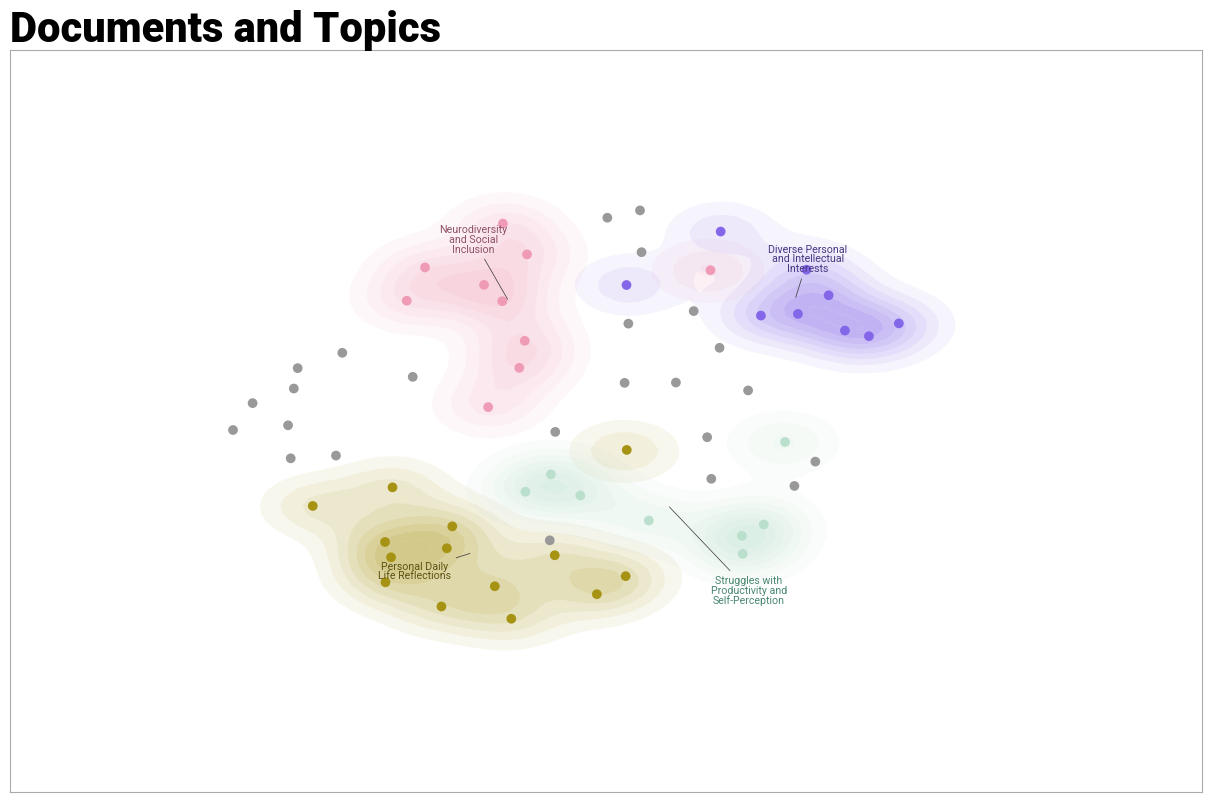

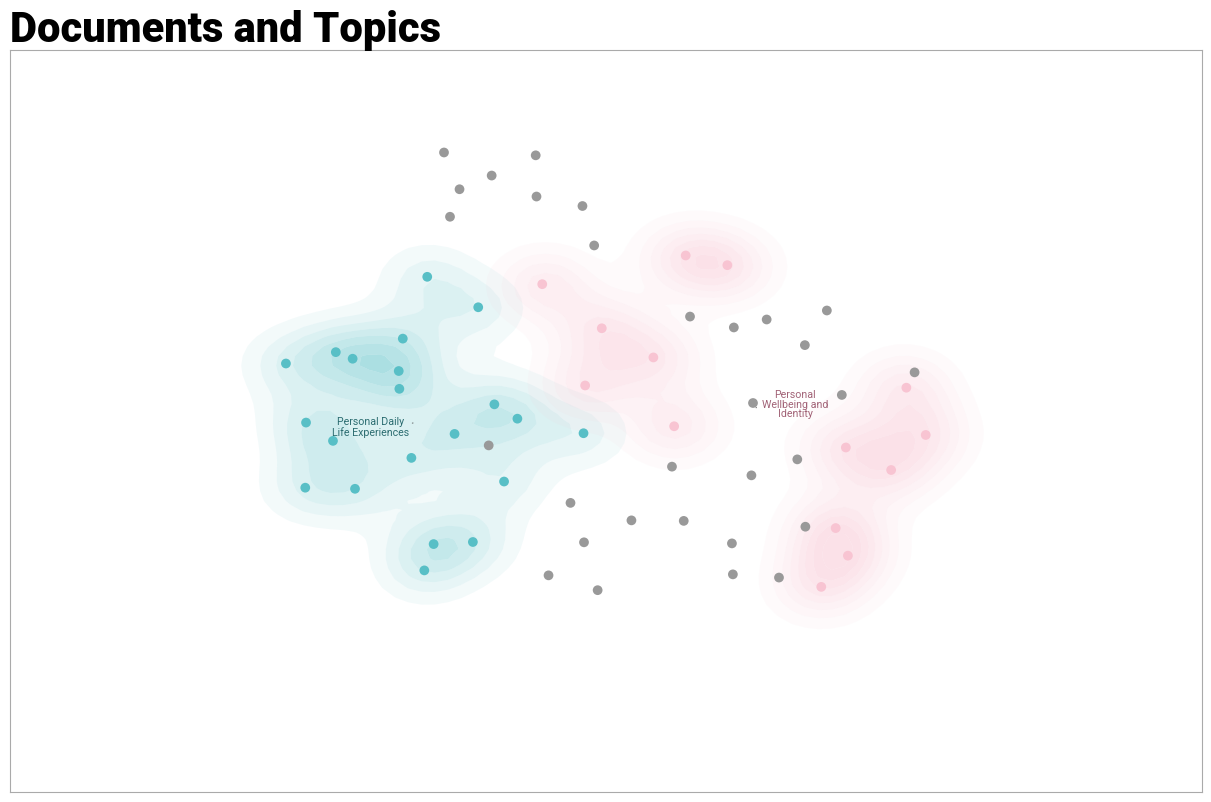

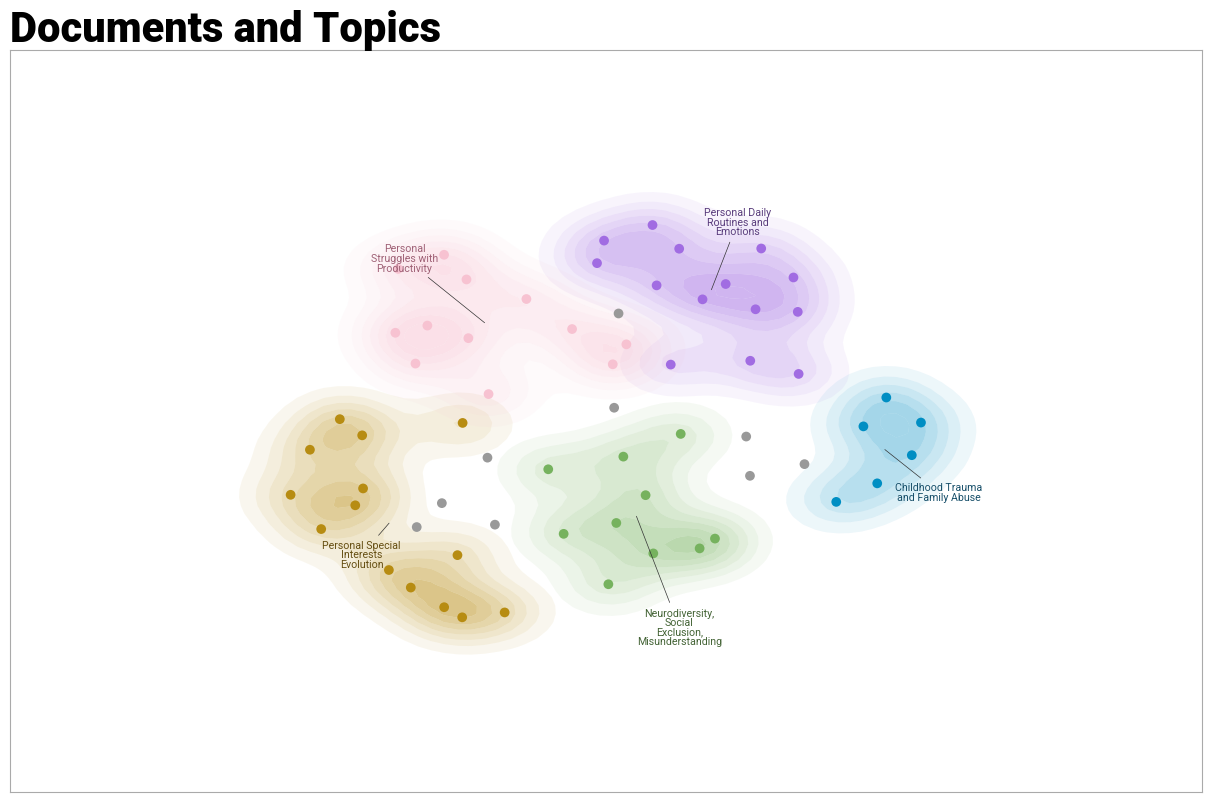

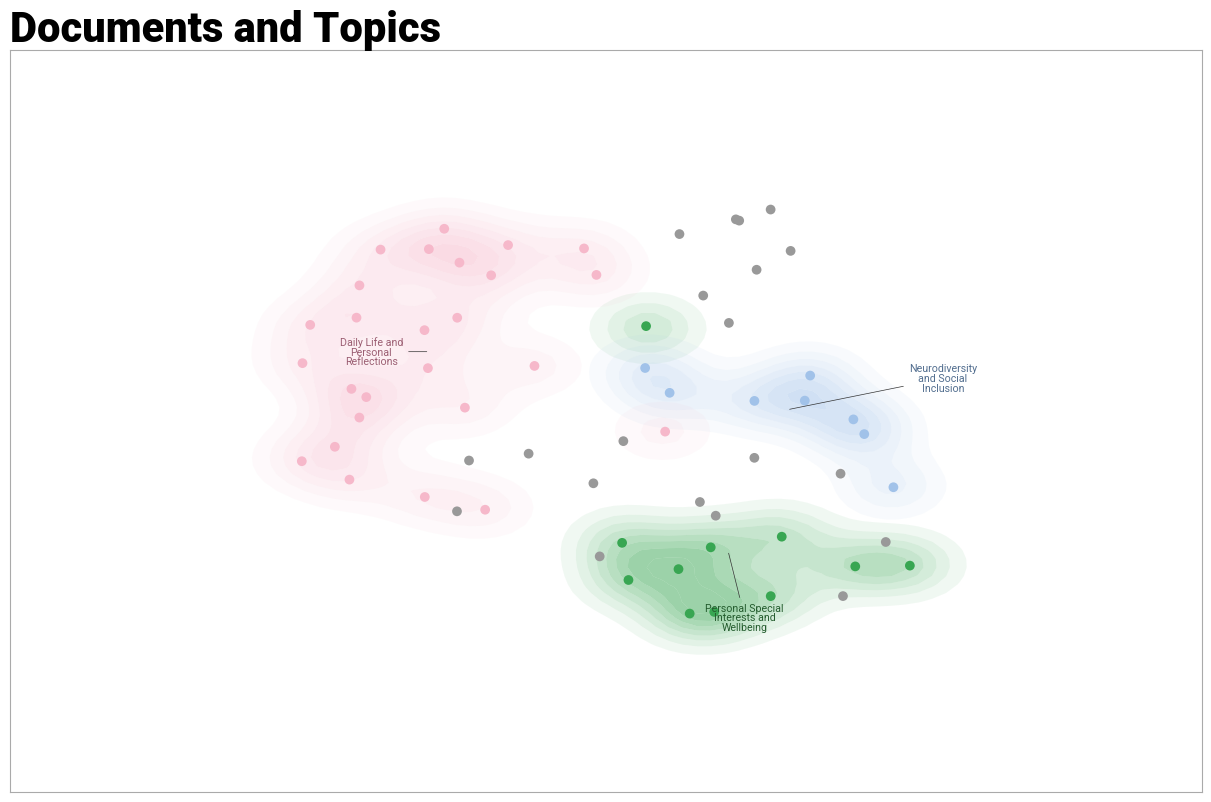

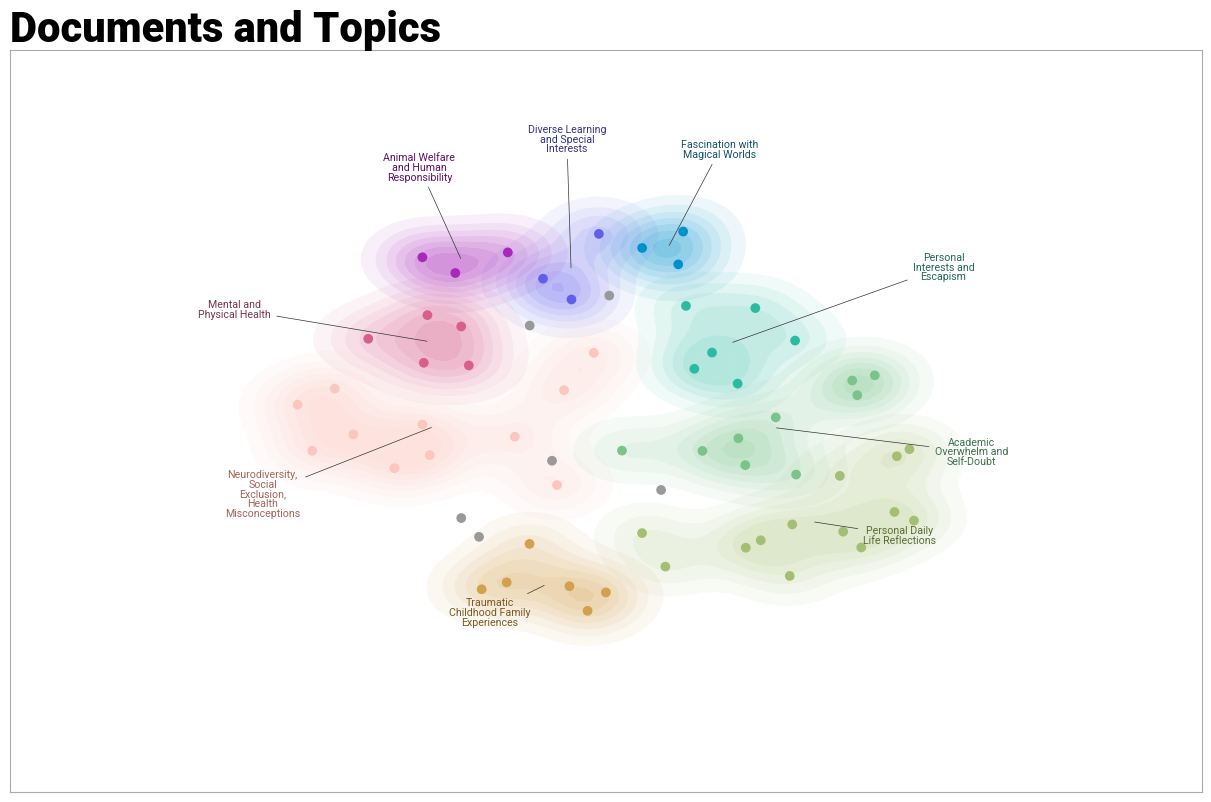

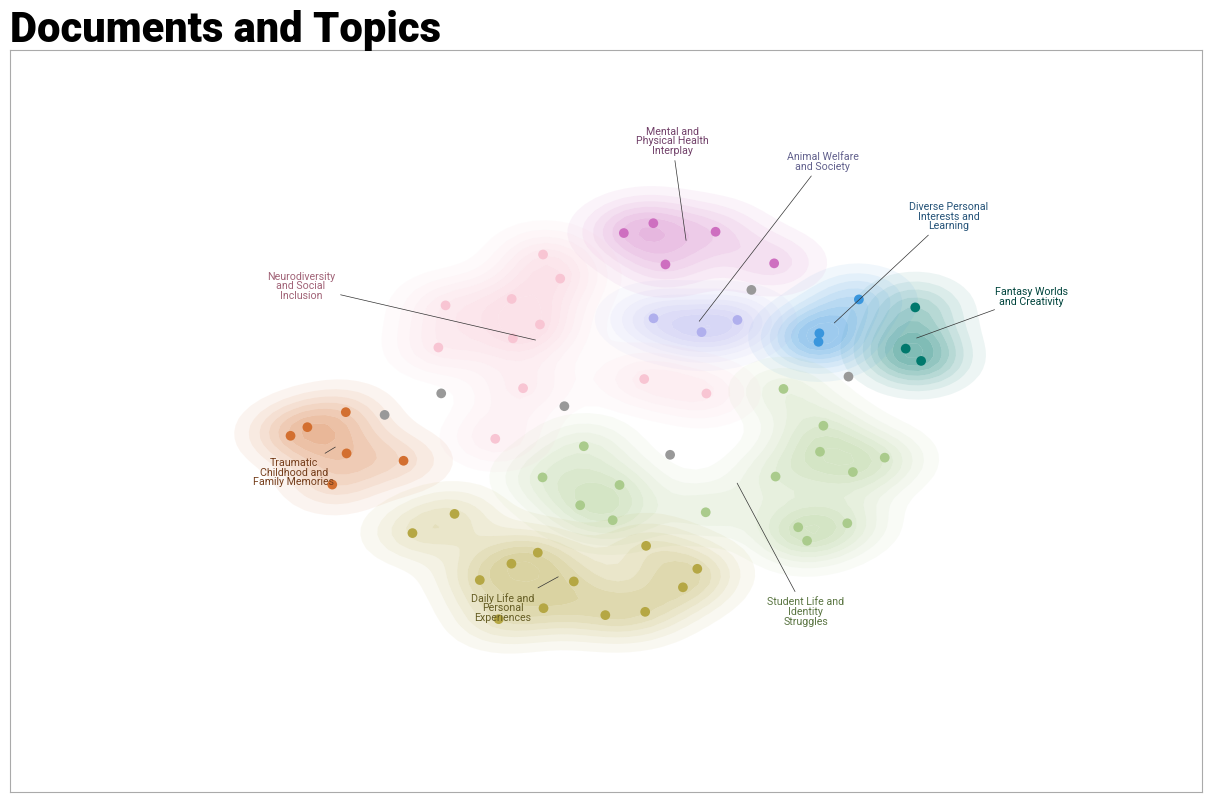

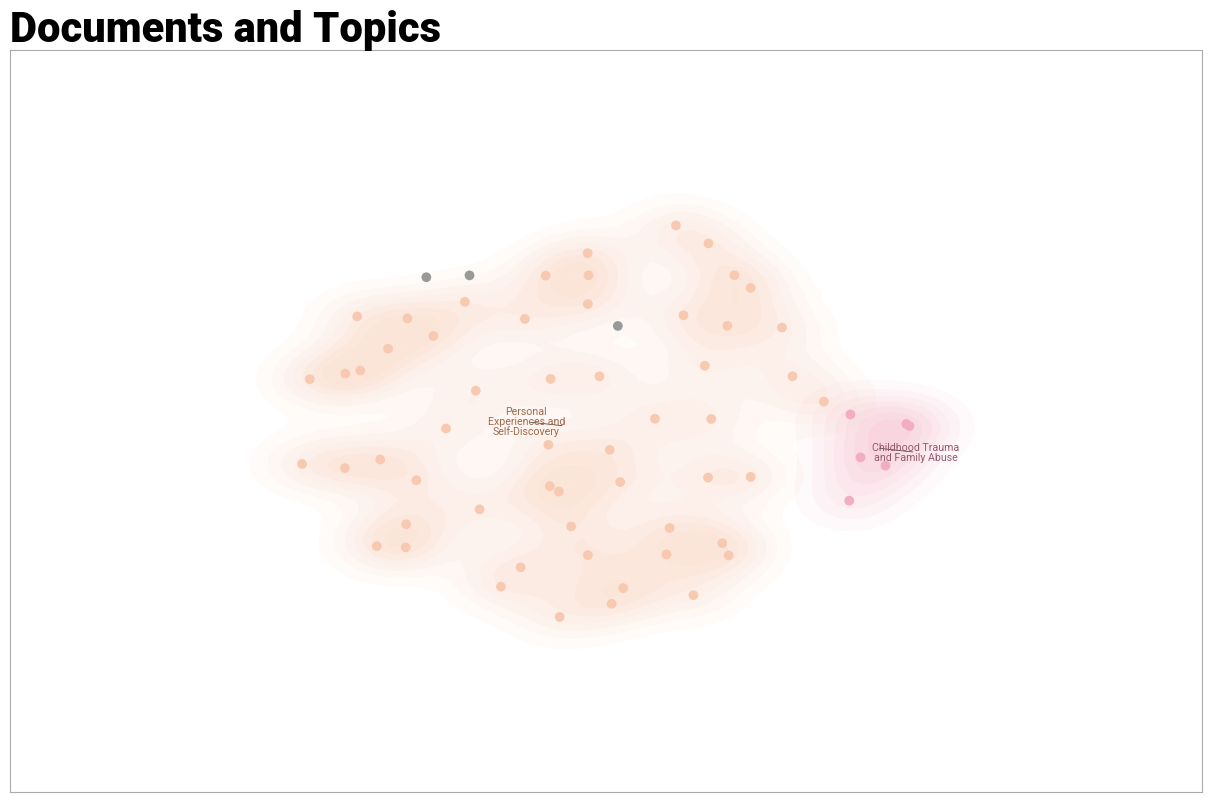

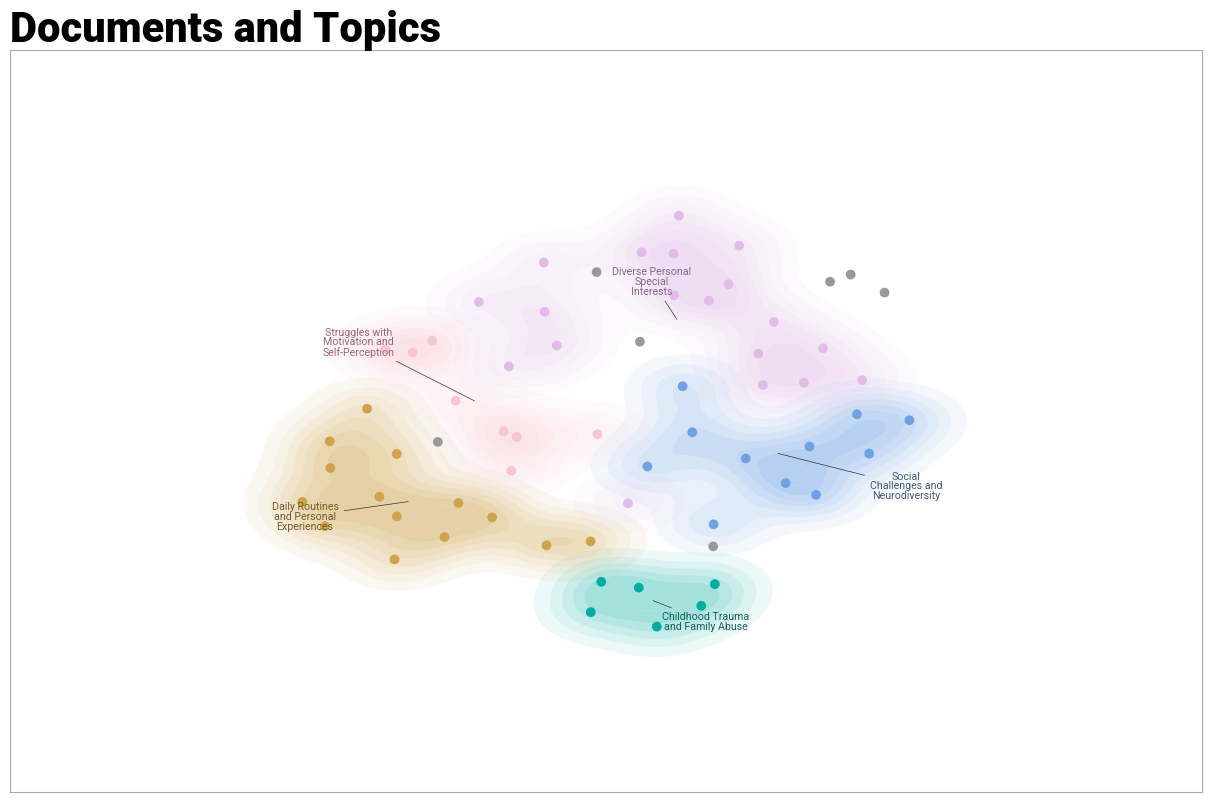

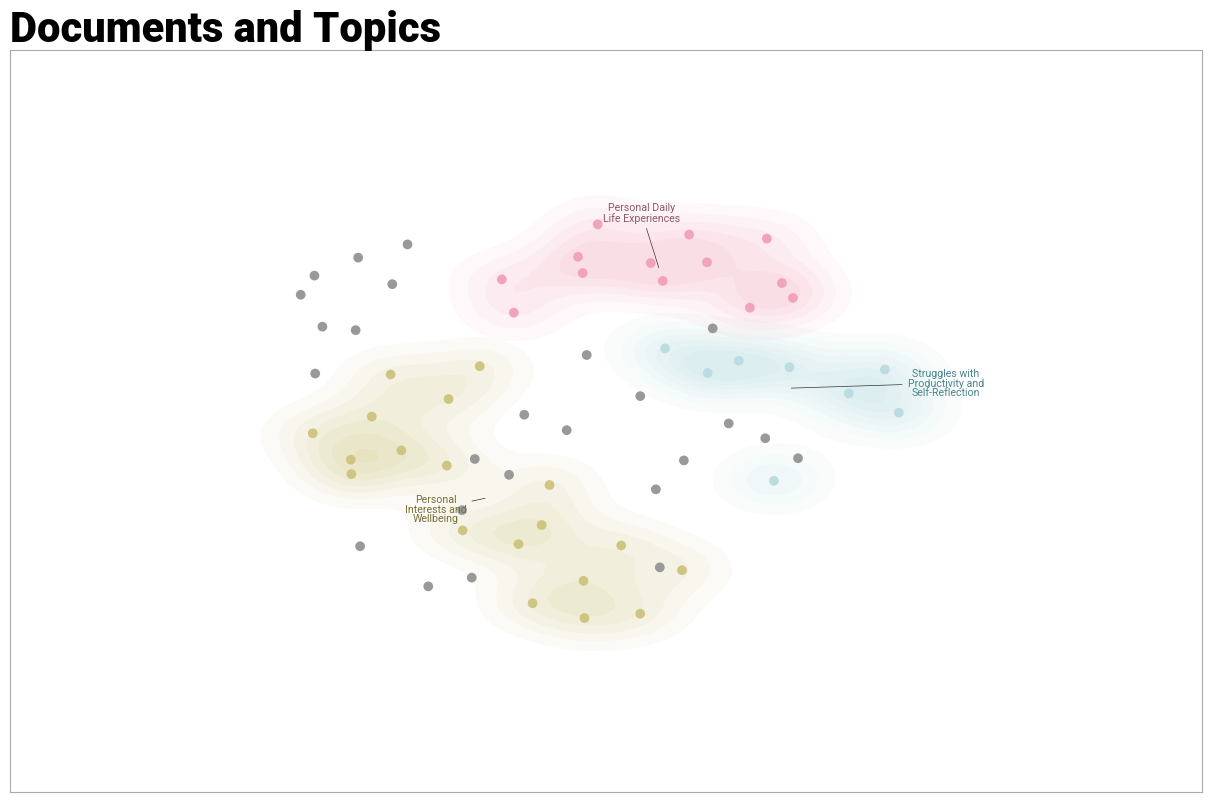

In [18]:
for folder in folders:
    print("=" * 60)
    print(f"Found folder: {folder}")
    print("=" * 60)
    df_group, topic_model, output_folder = preliminary_steps(group_name, folder)
    check_hierarchy(topic_model, df_group, output_folder, group_name)
    run_bertopic_evals(topic_model, df_group, output_folder)
    run_bertopic_viz(topic_model, df_group, output_folder, group_name)

# Female no-ADHD

In [19]:
group_name = "Female_noADHD"
folders = [name for name in os.listdir(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/") if os.path.isdir(os.path.join(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/", name))]
folders

['6_20250824_205040',
 '3_reduced_16_20250825_012136',
 '12_20250824_210406',
 '3_20250824_203413',
 '4_20250824_204001',
 '2_20250824_202655',
 '5_20250824_204338',
 '7_20250824_205357',
 '15_20250824_214606',
 '8_20250824_205621',
 '10_20250824_210048']

Found folder: 6_20250824_205040
Running preliminary steps for group: Female_noADHD, folder: 6_20250824_205040
Female_noADHD
🔄 Generating hierarchical topics...


100%|██████████| 8/8 [00:00<00:00, 563.19it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250825_021426_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250825_021426_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/6_20250824_205040
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 10
📊 Number of real topics (excluding outliers): 9
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_noADHD as PNG: 20250825_021427_bertopic_topics_female_noadhd.png
📊 Saved bertopic_topics_Female_noADHD as HTML: 20250825_021427_bertopic_topics_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...      1   
1    Gosto de ver séries porque relatam relações sa...      1   
2    Campos de ferias. Temos que criar o campo todo...     -1   
3    Taylor Swift, amo o seu liricismo e a maneira ...      1   
4    Historia da arte \nÉ só tão interessante. Para...     -1   
..                                                 ...    ...   
215  A noção de que procuro ser sempre uma boa pess...      0   
216                                                  —     -1   
217  As vezes aborrece-me ter de escrever/responder...      0   
218  Maiores dificuldades que sempre senti.. Concen...     -1   
219  Alguém me mande um milagre, I am going crazy, ...      0   

                              Name  \
0         1_gosto_ler_forma_porque   
1         1_gosto_ler_forma_porque   
2    -1_fazer_queria_nunca_memória   
3         1_gosto_ler_forma_porque   
4    -1_fazer_queria_nunca_memória   
..                             ...   
215      0_dia_fazer_hoje_trabalho   
216  -1_fazer_queria_nunca_memória   
217      0_dia_fazer_hoje_trabalho   
218  -1_fazer_queria_nunca_memória   
219      0_dia_fazer_hoje_trabalho   

                                      CustomName  \
0                  Passion for Stories and Media   
1                  Passion for Stories and Media   
2                                  Outlier Topic   
3                  Passion for Stories and Media   
4                                  Outlier Topic   
..                                           ...   
215  Personal Struggles and Emotional Challenges   
216                                Outlier Topic   
217  Personal Struggles and Emotional Challenges   
218                                Outlier Topic   
219  Personal Struggles and Emotional Challenges   

                                        Representation  \
0    [gosto, ler, forma, porque, adoro, interesse, ...   
1    [gosto, ler, forma, porque, adoro, interesse, ...   
2    [fazer, queria, nunca, memória, nada, animais,...   
3    [gosto, ler, forma, porque, adoro, interesse, ...   
4    [fazer, queria, nunca, memória, nada, animais,...   
..                                                 ...   
215  [dia, fazer, hoje, trabalho, casa, ir, porque,...   
216  [fazer, queria, nunca, memória, nada, animais,...   
217  [dia, fazer, hoje, trabalho, casa, ir, porque,...   
218  [fazer, queria, nunca, memória, nada, animais,...   
219  [dia, fazer, hoje, trabalho, casa, ir, porque,...   

                                               KeyBERT  \
0    [livros, ler, histórias, serem, viver, especia...   
1    [livros, ler, histórias, serem, viver, especia...   
2    [fiquei, ia, andado, comigo, aula, aulas, altu...   
3    [livros, ler, histórias, serem, viver, especia...   
4    [fiquei, ia, andado, comigo, aula, aulas, altu...   
..                                                 ...   
215  [fiquei, passei, comecei, acordei, cheguei, fi...   
216  [fiquei, ia, andado, comigo, aula, aulas, altu...   
217  [fiquei, passei, comecei, acordei, cheguei, fi...   
218  [fiquei, ia, andado, comigo, aula, aulas, altu...   
219  [fiquei, passei, comecei, acordei, cheguei, fi...   

                                               OpenAI  \
0                     [Passion for Stories and Media]   
1                     [Passion for Stories and Media]   
2    [Personal Relationships and Emotional Struggles]   
3                     [Passion for Stories and Media]   
4    [Personal Relationships and Emotional Struggles]   
..                                                ...   
215     [Personal Struggles and Emotional Challenges]   
216  [Personal Relationships and Emotional Struggles]   
217     [Personal Struggles and Emotional Challenges]   
218  [Personal Relationships and Emotional Struggles]   
219     [Personal Struggles and Emotional Challenges]   

                                                   MMR  \
0    [gosto, livros, vida, músicas, ver, sinto

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250825_021429_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250825_021429_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/6_20250824_205040
------------------------------------------------------------


4it [00:00, 138.06it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250825_021430_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250825_021430_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/6_20250824_205040
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250825_021433_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250825_021433_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/6_20250824_205040
--------------------------------

100%|██████████| 14/14 [00:00<00:00, 614.41it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250825_021455_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250825_021455_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_reduced_16_20250825_012136
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 16
📊 Number of real topics (excluding outliers): 15
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_noADHD as PNG: 20250825_021456_bertopic_topics_female_noadhd.png
📊 Saved bertopic_topics_Female_noADHD as HTML: 20250825_021456_bertopic_topics_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-w

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...      4   
1    Gosto de ver séries porque relatam relações sa...      3   
2    Campos de ferias. Temos que criar o campo todo...     -1   
3    Taylor Swift, amo o seu liricismo e a maneira ...      3   
4    Historia da arte \nÉ só tão interessante. Para...     -1   
..                                                 ...    ...   
215  A noção de que procuro ser sempre uma boa pess...      1   
216                                                  —     10   
217  As vezes aborrece-me ter de escrever/responder...     -1   
218  Maiores dificuldades que sempre senti.. Concen...      1   
219  Alguém me mande um milagre, I am going crazy, ...      0   

                               Name                               CustomName  \
0     4_cozinhar_gosto_adoro_acalma     Relaxing Personal Leisure Activities   
1     3_ler_história_músicas_livros            Impact of Fiction on Identity   
2           -1_dia_gosto_dias_todos                            Outlier Topic   
3     3_ler_história_músicas_livros            Impact of Fiction on Identity   
4           -1_dia_gosto_dias_todos                            Outlier Topic   
..                              ...                                      ...   
215     1_pessoas_sempre_vezes_algo  Personal Reflection and Social Concerns   
216  10_biblioteca_escrita_pessoas_         Language and Human Communication   
217         -1_dia_gosto_dias_todos                            Outlier Topic   
218     1_pessoas_sempre_vezes_algo  Personal Reflection and Social Concerns   
219         0_dia_hoje_fazer_porque       Daily Life and Emotional Struggles   

                                        Representation  \
0    [cozinhar, gosto, adoro, acalma, porque, cor, ...   
1    [ler, história, músicas, livros, forma, intere...   
2    [dia, gosto, dias, todos, animais, consegui, h...   
3    [ler, história, músicas, livros, forma, intere...   
4    [dia, gosto, dias, todos, animais, consegui, h...   
..                                                 ...   
215  [pessoas, sempre, vezes, algo, sinto, perceber...   
216       [biblioteca, escrita, pessoas, , , , , , , ]   
217  [dia, gosto, dias, todos, animais, consegui, h...   
218  [pessoas, sempre, vezes, algo, sinto, perceber...   
219  [dia, hoje, fazer, porque, trabalho, pai, ir, ...   

                                               KeyBERT  \
0    [sentir bem, adoro fazer, gosto nadar, acalma,...   
1    [livros, ler, the, lido, histórias, escrita, r...   
2    [fazer, ir, saí, tempo, acordei, fazer exame, ...   
3    [livros, ler, the, lido, histórias, escrita, r...   
4    [fazer, ir, saí, tempo, acordei, fazer exame, ...   
..                                                 ...   
215  [muitas vezes, sentir, sinto, vezes, memórias,...   
216                        [escrita, , , , , , , , , ]   
217  [fazer, ir, saí, tempo, acordei, fazer exame, ...   
218  [muitas vezes, sentir, sinto, vezes, memórias,...   
219  [ansiosa, acordei, dormi, comecei, fiquei, ia,...   

                                        OpenAI  \
0       [Relaxing Personal Leisure Activities]   
1              [Impact of Fiction on Identity]   
2           [Personal Life and Daily Routines]   
3              [Impact of Fiction on Identity]   
4           [Personal Life and Daily Routines]   
..                                         ...   
215  [Personal Reflection and Social Concerns]   
216         [Language and Human Communication]   
217         [Personal Life and Daily Routines]   
218  [Personal Reflection and Social Concerns]   
219       [Daily Life and Emotional Struggles]   

                                                   MMR  \
0    [cozinhar, adoro, acalma, fazer coisas, permit...   
1    [história, músicas, livros, gosto, amor, volta...   
2    [dias, animais, hoje, ainda, jogos, anos, cois...   
3    [história, músicas, livros, gosto, amor, volta...   
4    [dias, animais

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250825_021458_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250825_021458_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_reduced_16_20250825_012136
------------------------------------------------------------


4it [00:00, 128.93it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250825_021459_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250825_021459_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_reduced_16_20250825_012136
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250825_021503_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250825_021503_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_reduced_16_20250825_012136
----------

100%|██████████| 2/2 [00:00<00:00, 420.73it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250825_021530_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250825_021530_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/12_20250824_210406
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 4
📊 Number of real topics (excluding outliers): 3
⚠️  Cannot create topic visualization: Need at least 3 real topics
💡 This model has too few distinct topics for meaningful visualization
Silhouette score calculated on 156 documents across 3 topics
Silhouette Score: 0.0498
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.2537
Individual Topic Coherences:
  Topic 0: -1.0681
  Topic 1: -1.3992
  Topic 2: -1.2939
Cohe

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...      1   
1    Gosto de ver séries porque relatam relações sa...      1   
2    Campos de ferias. Temos que criar o campo todo...      0   
3    Taylor Swift, amo o seu liricismo e a maneira ...      1   
4    Historia da arte \nÉ só tão interessante. Para...     -1   
..                                                 ...    ...   
215  A noção de que procuro ser sempre uma boa pess...      0   
216                                                  —     -1   
217  As vezes aborrece-me ter de escrever/responder...     -1   
218  Maiores dificuldades que sempre senti.. Concen...     -1   
219  Alguém me mande um milagre, I am going crazy, ...      0   

                            Name                          CustomName  \
0     1_gosto_porque_adoro_forma     Personal Interests and Passions   
1     1_gosto_porque_adoro_forma     Personal Interests and Passions   
2      0_dia_fazer_hoje_trabalho  Personal Challenges and Daily Life   
3     1_gosto_porque_adoro_forma     Personal Interests and Passions   
4    -1_música_fazer_nunca_vezes                       Outlier Topic   
..                           ...                                 ...   
215    0_dia_fazer_hoje_trabalho  Personal Challenges and Daily Life   
216  -1_música_fazer_nunca_vezes                       Outlier Topic   
217  -1_música_fazer_nunca_vezes                       Outlier Topic   
218  -1_música_fazer_nunca_vezes                       Outlier Topic   
219    0_dia_fazer_hoje_trabalho  Personal Challenges and Daily Life   

                                        Representation  \
0    [gosto, porque, adoro, forma, ler, interesse, ...   
1    [gosto, porque, adoro, forma, ler, interesse, ...   
2    [dia, fazer, hoje, trabalho, porque, casa, tem...   
3    [gosto, porque, adoro, forma, ler, interesse, ...   
4    [música, fazer, nunca, vezes, pessoas, sempre,...   
..                                                 ...   
215  [dia, fazer, hoje, trabalho, porque, casa, tem...   
216  [música, fazer, nunca, vezes, pessoas, sempre,...   
217  [música, fazer, nunca, vezes, pessoas, sempre,...   
218  [música, fazer, nunca, vezes, pessoas, sempre,...   
219  [dia, fazer, hoje, trabalho, porque, casa, tem...   

                                               KeyBERT  \
0    [livros, viver, especialmente, sentir, ler, co...   
1    [livros, viver, especialmente, sentir, ler, co...   
2    [fiquei, passei, comecei, acordei, ia, cheguei...   
3    [livros, viver, especialmente, sentir, ler, co...   
4    [aprender, tendo, altura, mim, música, tocar, ...   
..                                                 ...   
215  [fiquei, passei, comecei, acordei, ia, cheguei...   
216  [aprender, tendo, altura, mim, música, tocar, ...   
217  [aprender, tendo, altura, mim, música, tocar, ...   
218  [aprender, tendo, altura, mim, música, tocar, ...   
219  [fiquei, passei, comecei, acordei, ia, cheguei...   

                                               OpenAI  \
0                   [Personal Interests and Passions]   
1                   [Personal Interests and Passions]   
2                [Personal Challenges and Daily Life]   
3                   [Personal Interests and Passions]   
4    [Self-Discovery Through Passions and Challenges]   
..                                                ...   
215              [Personal Challenges and Daily Life]   
216  [Self-Discovery Through Passions and Challenges]   
217  [Self-Discovery Through Passions and Challenges]   
218  [Self-Discovery Through Passions and Challenges]   
219              [Personal Challenges and Daily Life]   

                                                   MMR  \
0    [gosto, adoro, ler, coisas, vida, livros, anos...   
1    [gosto, adoro, ler, coisas, vida, livros, anos...   
2    [fazer, tempo, tarde, quero, senti, trabalhar,...   
3    [gosto, adoro, ler, coisas, vida, livros, anos...   
4    [música, nunca, vezes, vid

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250825_021532_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250825_021532_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/12_20250824_210406
------------------------------------------------------------


4it [00:00, 157.88it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250825_021533_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250825_021533_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/12_20250824_210406
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250825_021536_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250825_021536_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/12_20250824_210406
------------------------------

100%|██████████| 22/22 [00:00<00:00, 536.03it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250825_021545_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250825_021545_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 24
📊 Number of real topics (excluding outliers): 23
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_noADHD as PNG: 20250825_021547_bertopic_topics_female_noadhd.png
📊 Saved bertopic_topics_Female_noADHD as HTML: 20250825_021547_bertopic_topics_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/output

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...     13   
1    Gosto de ver séries porque relatam relações sa...      2   
2    Campos de ferias. Temos que criar o campo todo...     -1   
3    Taylor Swift, amo o seu liricismo e a maneira ...      2   
4    Historia da arte \nÉ só tão interessante. Para...     -1   
..                                                 ...    ...   
215  A noção de que procuro ser sempre uma boa pess...     10   
216                                                  —     18   
217  As vezes aborrece-me ter de escrever/responder...     -1   
218  Maiores dificuldades que sempre senti.. Concen...      1   
219  Alguém me mande um milagre, I am going crazy, ...      0   

                                    Name  \
0           13_cozinhar_adoro_cor_pontos   
1          2_ler_história_músicas_livros   
2              -1_dia_gosto_animais_dias   
3          2_ler_história_músicas_livros   
4              -1_dia_gosto_animais_dias   
..                                   ...   
215  10_algum_pensamentos_vezes_perceber   
216       18_biblioteca_escrita_pessoas_   
217            -1_dia_gosto_animais_dias   
218        1_pessoas_cabeça_atenção_medo   
219          0_quero_semana_fazer_porque   

                                 CustomName  \
0    Emotional Benefits of Creative Hobbies   
1         Passion for Reading and Mythology   
2                             Outlier Topic   
3         Passion for Reading and Mythology   
4                             Outlier Topic   
..                                      ...   
215           Mental Health Self-Reflection   
216         Writing and Meaning Connections   
217                           Outlier Topic   
218            Gender, Activism, AI Anxiety   
219              Daily Stress and Overwhelm   

                                        Representation  \
0    [cozinhar, adoro, cor, pontos, permite, facto,...   
1    [ler, história, músicas, livros, forma, intere...   
2    [dia, gosto, animais, dias, todos, consegui, h...   
3    [ler, história, músicas, livros, forma, intere...   
4    [dia, gosto, animais, dias, todos, consegui, h...   
..                                                 ...   
215  [algum, pensamentos, vezes, perceber, muitas v...   
216       [biblioteca, escrita, pessoas, , , , , , , ]   
217  [dia, gosto, animais, dias, todos, consegui, h...   
218  [pessoas, cabeça, atenção, medo, escrever, fem...   
219  [quero, semana, fazer, porque, dia, trabalho, ...   

                                               KeyBERT  \
0    [fazer coisas, cozinhar, fazer, porque gosto, ...   
1    [livros, ler, the, lido, histórias, escrita, r...   
2    [fazer, ir, saí, tempo, acordei, fazer exame, ...   
3    [livros, ler, the, lido, histórias, escrita, r...   
4    [fazer, ir, saí, tempo, acordei, fazer exame, ...   
..                                                 ...   
215  [mental, conseguir, cansativo, muitas vezes, s...   
216                        [escrita, , , , , , , , , ]   
217  [fazer, ir, saí, tempo, acordei, fazer exame, ...   
218  [mexer, mim sinto, dificuldades, políticas, cr...   
219  [stress, stressada, acordei, ansiosa, fiquei, ...   

                                       OpenAI  \
0    [Emotional Benefits of Creative Hobbies]   
1         [Passion for Reading and Mythology]   
2           [Personal Daily Life Experiences]   
3         [Passion for Reading and Mythology]   
4           [Personal Daily Life Experiences]   
..                                        ...   
215           [Mental Health Self-Reflection]   
216         [Writing and Meaning Connections]   
217         [Personal Daily Life Experiences]   
218            [Gender, Activism, AI Anxiety]   
219              [Daily Stress and Overwhelm]   

                                                   MMR  \
0    [cozinhar, cor, pontos, fazer, desligar, duran...   
1    [história, músicas, livros, gosto, amor, volta...   
2    [animais,

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250825_021549_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250825_021549_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413
------------------------------------------------------------


4it [00:00, 110.60it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250825_021550_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250825_021550_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250825_021556_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250825_021556_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413
--------------------------------

100%|██████████| 11/11 [00:00<00:00, 586.82it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250825_021636_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250825_021636_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/4_20250824_204001
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 13
📊 Number of real topics (excluding outliers): 12
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_noADHD as PNG: 20250825_021638_bertopic_topics_female_noadhd.png
📊 Saved bertopic_topics_Female_noADHD as HTML: 20250825_021638_bertopic_topics_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/output

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...      1   
1    Gosto de ver séries porque relatam relações sa...      1   
2    Campos de ferias. Temos que criar o campo todo...     -1   
3    Taylor Swift, amo o seu liricismo e a maneira ...      1   
4    Historia da arte \nÉ só tão interessante. Para...     -1   
..                                                 ...    ...   
215  A noção de que procuro ser sempre uma boa pess...      0   
216                                                  —      5   
217  As vezes aborrece-me ter de escrever/responder...      0   
218  Maiores dificuldades que sempre senti.. Concen...      2   
219  Alguém me mande um milagre, I am going crazy, ...      0   

                                       Name  \
0                  1_gosto_ler_forma_porque   
1                  1_gosto_ler_forma_porque   
2               -1_gosto_queria_fazer_falar   
3                  1_gosto_ler_forma_porque   
4               -1_gosto_queria_fazer_falar   
..                                      ...   
215               0_dia_hoje_fazer_trabalho   
216  5_responder_prefiro_biblioteca_nenhuma   
217               0_dia_hoje_fazer_trabalho   
218           2_pessoas_cabeça_atenção_medo   
219               0_dia_hoje_fazer_trabalho   

                                  CustomName  \
0              Passion for Stories and Media   
1              Passion for Stories and Media   
2                              Outlier Topic   
3              Passion for Stories and Media   
4                              Outlier Topic   
..                                       ...   
215  Daily Routines and Personal Reflections   
216           Reluctance to Answer Questions   
217  Daily Routines and Personal Reflections   
218    Gender, Activism, Technology, Anxiety   
219  Daily Routines and Personal Reflections   

                                        Representation  \
0    [gosto, ler, forma, porque, interesse, adoro, ...   
1    [gosto, ler, forma, porque, interesse, adoro, ...   
2    [gosto, queria, fazer, falar, ver, coisas, dia...   
3    [gosto, ler, forma, porque, interesse, adoro, ...   
4    [gosto, queria, fazer, falar, ver, coisas, dia...   
..                                                 ...   
215  [dia, hoje, fazer, trabalho, casa, porque, pai...   
216  [responder, prefiro, biblioteca, nenhuma, escr...   
217  [dia, hoje, fazer, trabalho, casa, porque, pai...   
218  [pessoas, cabeça, atenção, medo, escrever, fem...   
219  [dia, hoje, fazer, trabalho, casa, porque, pai...   

                                               KeyBERT  \
0    [livros, ler, histórias, especialmente, lido, ...   
1    [livros, ler, histórias, especialmente, lido, ...   
2    [comigo, ia, altura, aulas, aula, durante, que...   
3    [livros, ler, histórias, especialmente, lido, ...   
4    [comigo, ia, altura, aulas, aula, durante, que...   
..                                                 ...   
215  [acordei, comecei, fiquei, passei, acordar, fi...   
216  [prefiro, responder, escrita, nenhuma, pergunt...   
217  [acordei, comecei, fiquei, passei, acordar, fi...   
218  [mexer, mim sinto, dificuldades, políticas, cr...   
219  [acordei, comecei, fiquei, passei, acordar, fi...   

                                        OpenAI  \
0              [Passion for Stories and Media]   
1              [Passion for Stories and Media]   
2      [Personal Struggles and Self-Discovery]   
3              [Passion for Stories and Media]   
4      [Personal Struggles and Self-Discovery]   
..                                         ...   
215  [Daily Routines and Personal Reflections]   
216           [Reluctance to Answer Questions]   
217  [Daily Routines and Personal Reflections]   
218    [Gender, Activism, Technology, Anxiety]   
219  [Daily Routines and Personal Reflections]   

                                                   MMR  \
0    [gosto, livros, músicas, vida, coisas, especia...   
1    [gosto,

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250825_021640_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250825_021640_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/4_20250824_204001
------------------------------------------------------------


4it [00:00, 107.73it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250825_021641_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250825_021641_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/4_20250824_204001
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250825_021645_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250825_021645_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/4_20250824_204001
--------------------------------

100%|██████████| 34/34 [00:00<00:00, 577.70it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250825_021710_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250825_021710_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/2_20250824_202655
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 36
📊 Number of real topics (excluding outliers): 35
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_noADHD as PNG: 20250825_021711_bertopic_topics_female_noadhd.png
📊 Saved bertopic_topics_Female_noADHD as HTML: 20250825_021711_bertopic_topics_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/output

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...     28   
1    Gosto de ver séries porque relatam relações sa...     14   
2    Campos de ferias. Temos que criar o campo todo...     -1   
3    Taylor Swift, amo o seu liricismo e a maneira ...     -1   
4    Historia da arte \nÉ só tão interessante. Para...     29   
..                                                 ...    ...   
215  A noção de que procuro ser sempre uma boa pess...     12   
216                                                  —     24   
217  As vezes aborrece-me ter de escrever/responder...     -1   
218  Maiores dificuldades que sempre senti.. Concen...     15   
219  Alguém me mande um milagre, I am going crazy, ...     26   

                                         Name  \
0    28_cozinhar_desligar_liga_outras pessoas   
1           14_historia_forma_saudáveis_adoro   
2                 -1_pai_momento_passar_disse   
3                 -1_pai_momento_passar_disse   
4              29_historia_arte_fácil_cultura   
..                                        ...   
215    12_algum_muitas vezes_perceber_comprar   
216            24_biblioteca_escrita_pessoas_   
217               -1_pai_momento_passar_disse   
218              15_chatgpt_impacto_odeio_uso   
219                 26_exame_you_tipo_nervosa   

                                           CustomName  \
0                     Personal Feelings About Cooking   
1                 Emotional Impact of Fiction Stories   
2                                       Outlier Topic   
3                                       Outlier Topic   
4                      World and Art History Insights   
..                                                ...   
215               Personal Growth and Self-Reflection   
216                  Language and Meaning Connections   
217                                     Outlier Topic   
218  Personal Struggles with Attention and Technology   
219              Student Stress and Health Challenges   

                                        Representation  \
0    [cozinhar, desligar, liga, outras pessoas, pod...   
1    [historia, forma, saudáveis, adoro, devo visto...   
2    [pai, momento, passar, disse, ir, manhã, seman...   
3    [pai, momento, passar, disse, ir, manhã, seman...   
4    [historia, arte, fácil, cultura, interessante,...   
..                                                 ...   
215  [algum, muitas vezes, perceber, comprar, tempo...   
216       [biblioteca, escrita, pessoas, , , , , , , ]   
217  [pai, momento, passar, disse, ir, manhã, seman...   
218  [chatgpt, impacto, odeio, uso, tipo, cérebro, ...   
219  [exame, you, tipo, nervosa, fez, sentisse, méd...   

                                               KeyBERT  \
0    [cozinhar, fazer, porque gosto, comida, gosto ...   
1    [ver séries, séries, histórias, gosto ver, gos...   
2    [ir, altura, hoje senti, tempo, fazer, sentia,...   
3    [ir, altura, hoje senti, tempo, fazer, sentia,...   
4    [historia, história, cultura, geral, arte, mun...   
..                                                 ...   
215  [conseguir, mental, fazer, aprender, sentir, m...   
216                        [escrita, , , , , , , , , ]   
217  [ir, altura, hoje senti, tempo, fazer, sentia,...   
218  [mexer, ando, demasiado, dificuldades, dificul...   
219  [stressada, hoje passei, passei dia, nervosa, ...   

                                                OpenAI  \
0                    [Personal Feelings About Cooking]   
1                [Emotional Impact of Fiction Stories]   
2                 [Personal Challenges and Resilience]   
3                 [Personal Challenges and Resilience]   
4                     [World and Art History Insights]   
..                                                 ...   
215              [Personal Growth and Self-Reflection]   
216                 [Language and Meaning Connections]   
217               [Personal Challenges and Resilience]   
218  [Personal St

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250825_021713_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250825_021713_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/2_20250824_202655
------------------------------------------------------------


4it [00:00, 99.19it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250825_021715_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250825_021715_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/2_20250824_202655
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250825_021721_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250825_021721_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/2_20250824_202655
--------------------------------

100%|██████████| 11/11 [00:00<00:00, 553.50it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250825_021833_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250825_021833_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/5_20250824_204338
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 13
📊 Number of real topics (excluding outliers): 12
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_noADHD as PNG: 20250825_021835_bertopic_topics_female_noadhd.png
📊 Saved bertopic_topics_Female_noADHD as HTML: 20250825_021835_bertopic_topics_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/output

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...      1   
1    Gosto de ver séries porque relatam relações sa...      1   
2    Campos de ferias. Temos que criar o campo todo...     -1   
3    Taylor Swift, amo o seu liricismo e a maneira ...      1   
4    Historia da arte \nÉ só tão interessante. Para...     -1   
..                                                 ...    ...   
215  A noção de que procuro ser sempre uma boa pess...      0   
216                                                  —     -1   
217  As vezes aborrece-me ter de escrever/responder...      0   
218  Maiores dificuldades que sempre senti.. Concen...     -1   
219  Alguém me mande um milagre, I am going crazy, ...      0   

                            Name                               CustomName  \
0       1_gosto_ler_forma_porque     Fiction, Mythology, and Storytelling   
1       1_gosto_ler_forma_porque     Fiction, Mythology, and Storytelling   
2    -1_fazer_gosto_queria_nunca                            Outlier Topic   
3       1_gosto_ler_forma_porque     Fiction, Mythology, and Storytelling   
4    -1_fazer_gosto_queria_nunca                            Outlier Topic   
..                           ...                                      ...   
215    0_dia_hoje_fazer_trabalho  Daily Routines and Personal Reflections   
216  -1_fazer_gosto_queria_nunca                            Outlier Topic   
217    0_dia_hoje_fazer_trabalho  Daily Routines and Personal Reflections   
218  -1_fazer_gosto_queria_nunca                            Outlier Topic   
219    0_dia_hoje_fazer_trabalho  Daily Routines and Personal Reflections   

                                        Representation  \
0    [gosto, ler, forma, porque, interesse, adoro, ...   
1    [gosto, ler, forma, porque, interesse, adoro, ...   
2    [fazer, gosto, queria, nunca, nada, coisas, al...   
3    [gosto, ler, forma, porque, interesse, adoro, ...   
4    [fazer, gosto, queria, nunca, nada, coisas, al...   
..                                                 ...   
215  [dia, hoje, fazer, trabalho, casa, porque, pai...   
216  [fazer, gosto, queria, nunca, nada, coisas, al...   
217  [dia, hoje, fazer, trabalho, casa, porque, pai...   
218  [fazer, gosto, queria, nunca, nada, coisas, al...   
219  [dia, hoje, fazer, trabalho, casa, porque, pai...   

                                               KeyBERT  \
0    [livros, ler, histórias, viver, especialmente,...   
1    [livros, ler, histórias, viver, especialmente,...   
2    [fiquei, comigo, ia, mim mesma, acabei, mim, a...   
3    [livros, ler, histórias, viver, especialmente,...   
4    [fiquei, comigo, ia, mim mesma, acabei, mim, a...   
..                                                 ...   
215  [acordei, comecei, fiquei, passei, acordar, fi...   
216  [fiquei, comigo, ia, mim mesma, acabei, mim, a...   
217  [acordei, comecei, fiquei, passei, acordar, fi...   
218  [fiquei, comigo, ia, mim mesma, acabei, mim, a...   
219  [acordei, comecei, fiquei, passei, acordar, fi...   

                                        OpenAI  \
0       [Fiction, Mythology, and Storytelling]   
1       [Fiction, Mythology, and Storytelling]   
2      [Personal Struggles and Self-Discovery]   
3       [Fiction, Mythology, and Storytelling]   
4      [Personal Struggles and Self-Discovery]   
..                                         ...   
215  [Daily Routines and Personal Reflections]   
216    [Personal Struggles and Self-Discovery]   
217  [Daily Routines and Personal Reflections]   
218    [Personal Struggles and Self-Discovery]   
219  [Daily Routines and Personal Reflections]   

                                                   MMR  \
0    [gosto, ler, livros, vida, músicas, especialme...   
1    [gosto, ler, livros, vida, músicas, especialme...   
2    [fazer, queria, nunca, coisas, altura, falar, ...   
3    [gosto, ler, livros, vida, músicas, especialme...   
4    [fazer, queria, nunca, coisas, altura, falar, ... 

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250825_021836_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250825_021836_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/5_20250824_204338
------------------------------------------------------------


4it [00:00, 129.98it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250825_021838_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250825_021838_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/5_20250824_204338
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250825_021841_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250825_021841_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/5_20250824_204338
--------------------------------

100%|██████████| 6/6 [00:00<00:00, 519.98it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250825_021905_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250825_021905_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/7_20250824_205357
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 8
📊 Number of real topics (excluding outliers): 7
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_noADHD as PNG: 20250825_021907_bertopic_topics_female_noadhd.png
📊 Saved bertopic_topics_Female_noADHD as HTML: 20250825_021907_bertopic_topics_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...     -1   
1    Gosto de ver séries porque relatam relações sa...      1   
2    Campos de ferias. Temos que criar o campo todo...     -1   
3    Taylor Swift, amo o seu liricismo e a maneira ...     -1   
4    Historia da arte \nÉ só tão interessante. Para...     -1   
..                                                 ...    ...   
215  A noção de que procuro ser sempre uma boa pess...      0   
216                                                  —     -1   
217  As vezes aborrece-me ter de escrever/responder...      0   
218  Maiores dificuldades que sempre senti.. Concen...     -1   
219  Alguém me mande um milagre, I am going crazy, ...      0   

                             Name  \
0    -1_gosto_fazer_porque_coisas   
1        1_gosto_ler_forma_livros   
2    -1_gosto_fazer_porque_coisas   
3    -1_gosto_fazer_porque_coisas   
4    -1_gosto_fazer_porque_coisas   
..                            ...   
215     0_dia_hoje_fazer_trabalho   
216  -1_gosto_fazer_porque_coisas   
217     0_dia_hoje_fazer_trabalho   
218  -1_gosto_fazer_porque_coisas   
219     0_dia_hoje_fazer_trabalho   

                                       CustomName  \
0                                   Outlier Topic   
1                     Impact of Reading and Media   
2                                   Outlier Topic   
3                                   Outlier Topic   
4                                   Outlier Topic   
..                                            ...   
215  Personal Challenges and Emotional Resilience   
216                                 Outlier Topic   
217  Personal Challenges and Emotional Resilience   
218                                 Outlier Topic   
219  Personal Challenges and Emotional Resilience   

                                        Representation  \
0    [gosto, fazer, porque, coisas, melhor, sempre,...   
1    [gosto, ler, forma, livros, porque, algo, vida...   
2    [gosto, fazer, porque, coisas, melhor, sempre,...   
3    [gosto, fazer, porque, coisas, melhor, sempre,...   
4    [gosto, fazer, porque, coisas, melhor, sempre,...   
..                                                 ...   
215  [dia, hoje, fazer, trabalho, porque, casa, ir,...   
216  [gosto, fazer, porque, coisas, melhor, sempre,...   
217  [dia, hoje, fazer, trabalho, porque, casa, ir,...   
218  [gosto, fazer, porque, coisas, melhor, sempre,...   
219  [dia, hoje, fazer, trabalho, porque, casa, ir,...   

                                               KeyBERT  \
0    [comigo, mim, recentemente, ia, sinto, altura,...   
1    [livros, ler, relaxar, fazer, serem, utilizar,...   
2    [comigo, mim, recentemente, ia, sinto, altura,...   
3    [comigo, mim, recentemente, ia, sinto, altura,...   
4    [comigo, mim, recentemente, ia, sinto, altura,...   
..                                                 ...   
215  [fiquei, passei, comecei, acordei, fiz, senti,...   
216  [comigo, mim, recentemente, ia, sinto, altura,...   
217  [fiquei, passei, comecei, acordei, fiz, senti,...   
218  [comigo, mim, recentemente, ia, sinto, altura,...   
219  [fiquei, passei, comecei, acordei, fiz, senti,...   

                                             OpenAI  \
0          [Personal Interests and Self-Reflection]   
1                     [Impact of Reading and Media]   
2          [Personal Interests and Self-Reflection]   
3          [Personal Interests and Self-Reflection]   
4          [Personal Interests and Self-Reflection]   
..                                              ...   
215  [Personal Challenges and Emotional Resilience]   
216        [Personal Interests and Self-Reflection]   
217  [Personal Challenges and Emotional Resilience]   
218        [Personal Interests and Self-Reflection]   
219  [Personal Challenges and Emotional Resilience]   

                                                   MMR  \
0    [gosto, fazer, nunca, memória, falar, adoro, m...   
1    [gosto,

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250825_021909_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250825_021909_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/7_20250824_205357
------------------------------------------------------------


4it [00:00, 136.36it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250825_021910_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250825_021910_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/7_20250824_205357
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250825_021913_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250825_021913_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/7_20250824_205357
--------------------------------

100%|██████████| 2/2 [00:00<00:00, 341.96it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250825_021929_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250825_021929_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/15_20250824_214606
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 4
📊 Number of real topics (excluding outliers): 3
⚠️  Cannot create topic visualization: Need at least 3 real topics
💡 This model has too few distinct topics for meaningful visualization
Silhouette score calculated on 159 documents across 3 topics
Silhouette Score: 0.0438
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.2980
Individual Topic Coherences:
  Topic 0: -1.1126
  Topic 1: -1.3796
  Topic 2: -1.4019
Cohe

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...      1   
1    Gosto de ver séries porque relatam relações sa...      1   
2    Campos de ferias. Temos que criar o campo todo...      0   
3    Taylor Swift, amo o seu liricismo e a maneira ...      1   
4    Historia da arte \nÉ só tão interessante. Para...     -1   
..                                                 ...    ...   
215  A noção de que procuro ser sempre uma boa pess...      0   
216                                                  —      0   
217  As vezes aborrece-me ter de escrever/responder...      0   
218  Maiores dificuldades que sempre senti.. Concen...     -1   
219  Alguém me mande um milagre, I am going crazy, ...      0   

                             Name                                 CustomName  \
0        1_gosto_porque_ler_forma  Personal Passions and Literary Obsessions   
1        1_gosto_porque_ler_forma  Personal Passions and Literary Obsessions   
2         0_dia_fazer_hoje_porque        Emotional Challenges and Resilience   
3        1_gosto_porque_ler_forma  Personal Passions and Literary Obsessions   
4    -1_música_fazer_pessoas_anos                              Outlier Topic   
..                            ...                                        ...   
215       0_dia_fazer_hoje_porque        Emotional Challenges and Resilience   
216       0_dia_fazer_hoje_porque        Emotional Challenges and Resilience   
217       0_dia_fazer_hoje_porque        Emotional Challenges and Resilience   
218  -1_música_fazer_pessoas_anos                              Outlier Topic   
219       0_dia_fazer_hoje_porque        Emotional Challenges and Resilience   

                                        Representation  \
0    [gosto, porque, ler, forma, adoro, interesse, ...   
1    [gosto, porque, ler, forma, adoro, interesse, ...   
2    [dia, fazer, hoje, porque, trabalho, ainda, te...   
3    [gosto, porque, ler, forma, adoro, interesse, ...   
4    [música, fazer, pessoas, anos, vida, ouvir, nu...   
..                                                 ...   
215  [dia, fazer, hoje, porque, trabalho, ainda, te...   
216  [dia, fazer, hoje, porque, trabalho, ainda, te...   
217  [dia, fazer, hoje, porque, trabalho, ainda, te...   
218  [música, fazer, pessoas, anos, vida, ouvir, nu...   
219  [dia, fazer, hoje, porque, trabalho, ainda, te...   

                                               KeyBERT  \
0    [livros, viver, especialmente, sentir, ler, es...   
1    [livros, viver, especialmente, sentir, ler, es...   
2    [fiquei, passei, comecei, fiz, senti, nervosa,...   
3    [livros, viver, especialmente, sentir, ler, es...   
4    [música, tocar, altura, comigo, ia, tendo, sin...   
..                                                 ...   
215  [fiquei, passei, comecei, fiz, senti, nervosa,...   
216  [fiquei, passei, comecei, fiz, senti, nervosa,...   
217  [fiquei, passei, comecei, fiz, senti, nervosa,...   
218  [música, tocar, altura, comigo, ia, tendo, sin...   
219  [fiquei, passei, comecei, fiz, senti, nervosa,...   

                                          OpenAI  \
0    [Personal Passions and Literary Obsessions]   
1    [Personal Passions and Literary Obsessions]   
2          [Emotional Challenges and Resilience]   
3    [Personal Passions and Literary Obsessions]   
4       [Personal Experiences and Relationships]   
..                                           ...   
215        [Emotional Challenges and Resilience]   
216        [Emotional Challenges and Resilience]   
217        [Emotional Challenges and Resilience]   
218     [Personal Experiences and Relationships]   
219        [Emotional Challenges and Resilience]   

                                                   MMR  \
0    [gosto, adoro, coisas, vida, livros, história,...   
1    [gosto, adoro, coisas, vida, livros, história,...   
2    [hoje, tempo, tarde, mim, coisas, quero, senti...   
3    [gosto, adoro, coisas, vida, livros, história,..

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250825_021931_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250825_021931_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/15_20250824_214606
------------------------------------------------------------


4it [00:00, 128.69it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250825_021932_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250825_021932_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/15_20250824_214606
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250825_021935_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250825_021935_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/15_20250824_214606
------------------------------

100%|██████████| 6/6 [00:00<00:00, 570.33it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250825_021944_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250825_021944_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/8_20250824_205621
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 8
📊 Number of real topics (excluding outliers): 7
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_noADHD as PNG: 20250825_021946_bertopic_topics_female_noadhd.png
📊 Saved bertopic_topics_Female_noADHD as HTML: 20250825_021946_bertopic_topics_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...     -1   
1    Gosto de ver séries porque relatam relações sa...      1   
2    Campos de ferias. Temos que criar o campo todo...     -1   
3    Taylor Swift, amo o seu liricismo e a maneira ...     -1   
4    Historia da arte \nÉ só tão interessante. Para...     -1   
..                                                 ...    ...   
215  A noção de que procuro ser sempre uma boa pess...      0   
216                                                  —     -1   
217  As vezes aborrece-me ter de escrever/responder...      0   
218  Maiores dificuldades que sempre senti.. Concen...     -1   
219  Alguém me mande um milagre, I am going crazy, ...      0   

                          Name                                    CustomName  \
0    -1_gosto_fazer_dia_porque                                 Outlier Topic   
1     1_gosto_ler_forma_porque               Passion for Stories and Fiction   
2    -1_gosto_fazer_dia_porque                                 Outlier Topic   
3    -1_gosto_fazer_dia_porque                                 Outlier Topic   
4    -1_gosto_fazer_dia_porque                                 Outlier Topic   
..                         ...                                           ...   
215  0_dia_fazer_hoje_trabalho  Personal Challenges and Emotional Resilience   
216  -1_gosto_fazer_dia_porque                                 Outlier Topic   
217  0_dia_fazer_hoje_trabalho  Personal Challenges and Emotional Resilience   
218  -1_gosto_fazer_dia_porque                                 Outlier Topic   
219  0_dia_fazer_hoje_trabalho  Personal Challenges and Emotional Resilience   

                                        Representation  \
0    [gosto, fazer, dia, porque, melhor, nunca, coi...   
1    [gosto, ler, forma, porque, interesse, adoro, ...   
2    [gosto, fazer, dia, porque, melhor, nunca, coi...   
3    [gosto, fazer, dia, porque, melhor, nunca, coi...   
4    [gosto, fazer, dia, porque, melhor, nunca, coi...   
..                                                 ...   
215  [dia, fazer, hoje, trabalho, porque, casa, ir,...   
216  [gosto, fazer, dia, porque, melhor, nunca, coi...   
217  [dia, fazer, hoje, trabalho, porque, casa, ir,...   
218  [gosto, fazer, dia, porque, melhor, nunca, coi...   
219  [dia, fazer, hoje, trabalho, porque, casa, ir,...   

                                               KeyBERT  \
0    [comigo, ia, mim, sinto, altura, sentir, memór...   
1    [viajar, livros, viver, sentir, ler, história,...   
2    [comigo, ia, mim, sinto, altura, sentir, memór...   
3    [comigo, ia, mim, sinto, altura, sentir, memór...   
4    [comigo, ia, mim, sinto, altura, sentir, memór...   
..                                                 ...   
215  [fiquei, passei, comecei, acordei, cheguei, fi...   
216  [comigo, ia, mim, sinto, altura, sentir, memór...   
217  [fiquei, passei, comecei, acordei, cheguei, fi...   
218  [comigo, ia, mim, sinto, altura, sentir, memór...   
219  [fiquei, passei, comecei, acordei, cheguei, fi...   

                                             OpenAI  \
0          [Personal Reflection and Self-Discovery]   
1                 [Passion for Stories and Fiction]   
2          [Personal Reflection and Self-Discovery]   
3          [Personal Reflection and Self-Discovery]   
4          [Personal Reflection and Self-Discovery]   
..                                              ...   
215  [Personal Challenges and Emotional Resilience]   
216        [Personal Reflection and Self-Discovery]   
217  [Personal Challenges and Emotional Resilience]   
218        [Personal Reflection and Self-Discovery]   
219  [Personal Challenges and Emotional Resilience]   

                                                   MMR  \
0    [nunca, coisas, hoje, gostava, responder, memó...   
1    [ler, adoro, vida, livros, músicas, sinto, coi...   
2    [nunca, coisas, hoje, gostava, responder, memó...   
3    [nunca, cois

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250825_021947_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250825_021947_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/8_20250824_205621
------------------------------------------------------------


4it [00:00, 138.10it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250825_021949_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250825_021949_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/8_20250824_205621
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250825_021952_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250825_021952_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/8_20250824_205621
--------------------------------

100%|██████████| 3/3 [00:00<00:00, 493.31it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250825_022008_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250825_022008_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/10_20250824_210048
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 5
📊 Number of real topics (excluding outliers): 4
⚠️  Very few topics detected. Attempting visualization with fallback options...
🔄 Attempting topic visualization with adjusted parameters...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_noADHD as PNG: 20250825_022010_bertopic_topics_female_noadhd.png
📊 Saved bertopic_topics_Female_noADHD as HTML: 20250825_022010_bertopic_topics_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...      1   
1    Gosto de ver séries porque relatam relações sa...      1   
2    Campos de ferias. Temos que criar o campo todo...      0   
3    Taylor Swift, amo o seu liricismo e a maneira ...      1   
4    Historia da arte \nÉ só tão interessante. Para...     -1   
..                                                 ...    ...   
215  A noção de que procuro ser sempre uma boa pess...      0   
216                                                  —     -1   
217  As vezes aborrece-me ter de escrever/responder...     -1   
218  Maiores dificuldades que sempre senti.. Concen...     -1   
219  Alguém me mande um milagre, I am going crazy, ...      0   

                              Name                          CustomName  \
0         1_gosto_porque_adoro_ler       Personal Passions and Fandoms   
1         1_gosto_porque_adoro_ler       Personal Passions and Fandoms   
2        0_dia_fazer_hoje_trabalho  Personal Challenges and Daily Life   
3         1_gosto_porque_adoro_ler       Personal Passions and Fandoms   
4    -1_música_pessoas_fazer_gosto                       Outlier Topic   
..                             ...                                 ...   
215      0_dia_fazer_hoje_trabalho  Personal Challenges and Daily Life   
216  -1_música_pessoas_fazer_gosto                       Outlier Topic   
217  -1_música_pessoas_fazer_gosto                       Outlier Topic   
218  -1_música_pessoas_fazer_gosto                       Outlier Topic   
219      0_dia_fazer_hoje_trabalho  Personal Challenges and Daily Life   

                                        Representation  \
0    [gosto, porque, adoro, ler, forma, interesse, ...   
1    [gosto, porque, adoro, ler, forma, interesse, ...   
2    [dia, fazer, hoje, trabalho, porque, casa, ir,...   
3    [gosto, porque, adoro, ler, forma, interesse, ...   
4    [música, pessoas, fazer, gosto, melhor, porque...   
..                                                 ...   
215  [dia, fazer, hoje, trabalho, porque, casa, ir,...   
216  [música, pessoas, fazer, gosto, melhor, porque...   
217  [música, pessoas, fazer, gosto, melhor, porque...   
218  [música, pessoas, fazer, gosto, melhor, porque...   
219  [dia, fazer, hoje, trabalho, porque, casa, ir,...   

                                               KeyBERT  \
0    [livros, viver, especialmente, ler, mim, senti...   
1    [livros, viver, especialmente, ler, mim, senti...   
2    [fiquei, passei, comecei, acordei, ia, cheguei...   
3    [livros, viver, especialmente, ler, mim, senti...   
4    [medo, aprender, altura, ia, mim, comigo, quer...   
..                                                 ...   
215  [fiquei, passei, comecei, acordei, ia, cheguei...   
216  [medo, aprender, altura, ia, mim, comigo, quer...   
217  [medo, aprender, altura, ia, mim, comigo, quer...   
218  [medo, aprender, altura, ia, mim, comigo, quer...   
219  [fiquei, passei, comecei, acordei, ia, cheguei...   

                                           OpenAI  \
0                 [Personal Passions and Fandoms]   
1                 [Personal Passions and Fandoms]   
2            [Personal Challenges and Daily Life]   
3                 [Personal Passions and Fandoms]   
4    [Personal Passions and Emotional Challenges]   
..                                            ...   
215          [Personal Challenges and Daily Life]   
216  [Personal Passions and Emotional Challenges]   
217  [Personal Passions and Emotional Challenges]   
218  [Personal Passions and Emotional Challenges]   
219          [Personal Challenges and Daily Life]   

                                                   MMR  \
0    [gosto, adoro, ler, vida, coisas, livros, faze...   
1    [gosto, adoro, ler, vida, coisas, livros, faze...   
2    [fazer, hoje, tempo, tarde, coisas, dias, sent...   
3    [gosto, adoro, ler, vida, coisas, livros, faze...   
4    [música, melhor, nunca, vezes, queria, ouvir, ... 

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250825_022011_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250825_022011_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/10_20250824_210048
------------------------------------------------------------


4it [00:00, 148.57it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250825_022013_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250825_022013_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/10_20250824_210048
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250825_022016_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250825_022016_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/10_20250824_210048
------------------------------

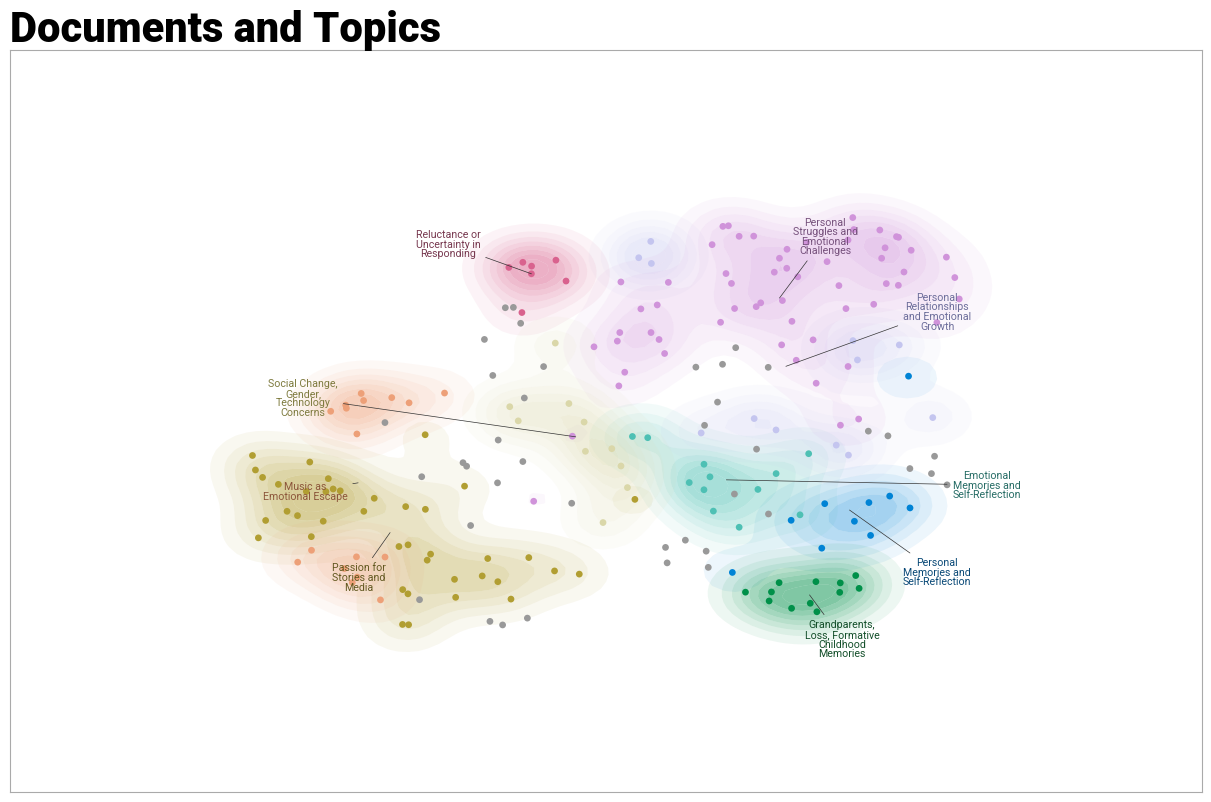

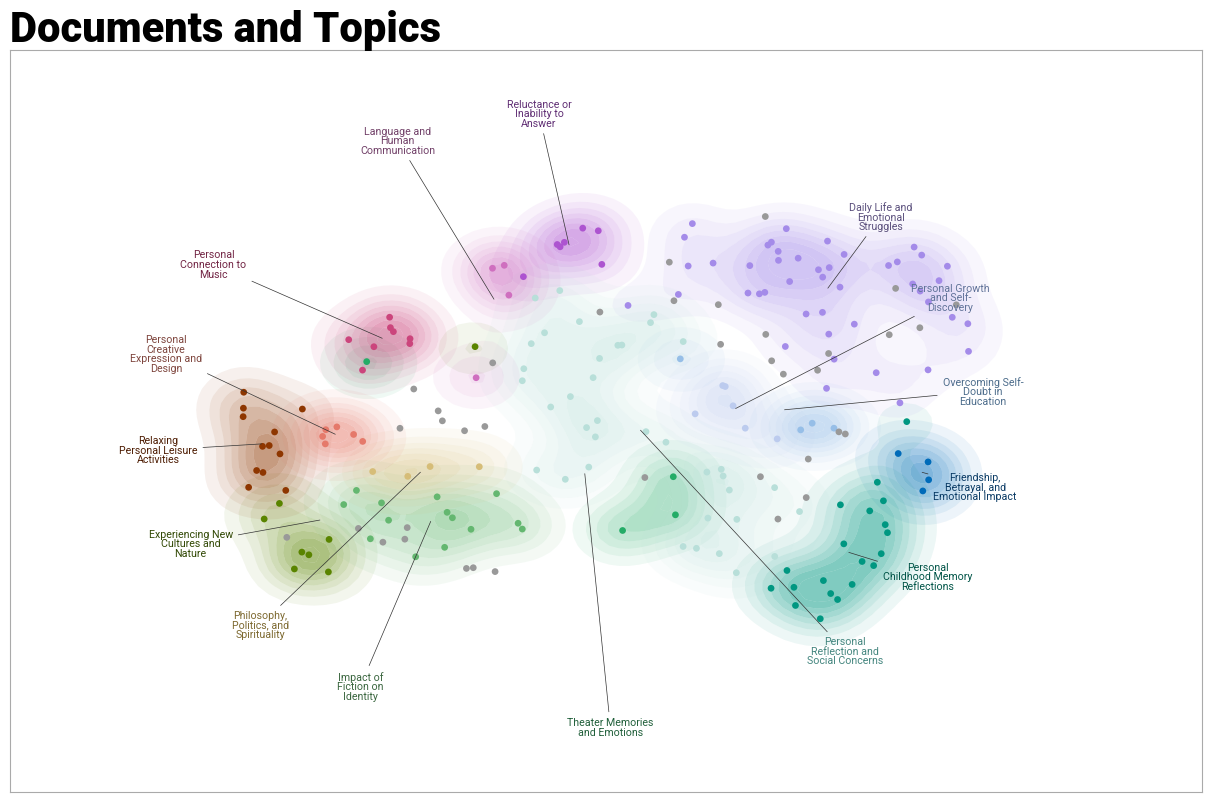

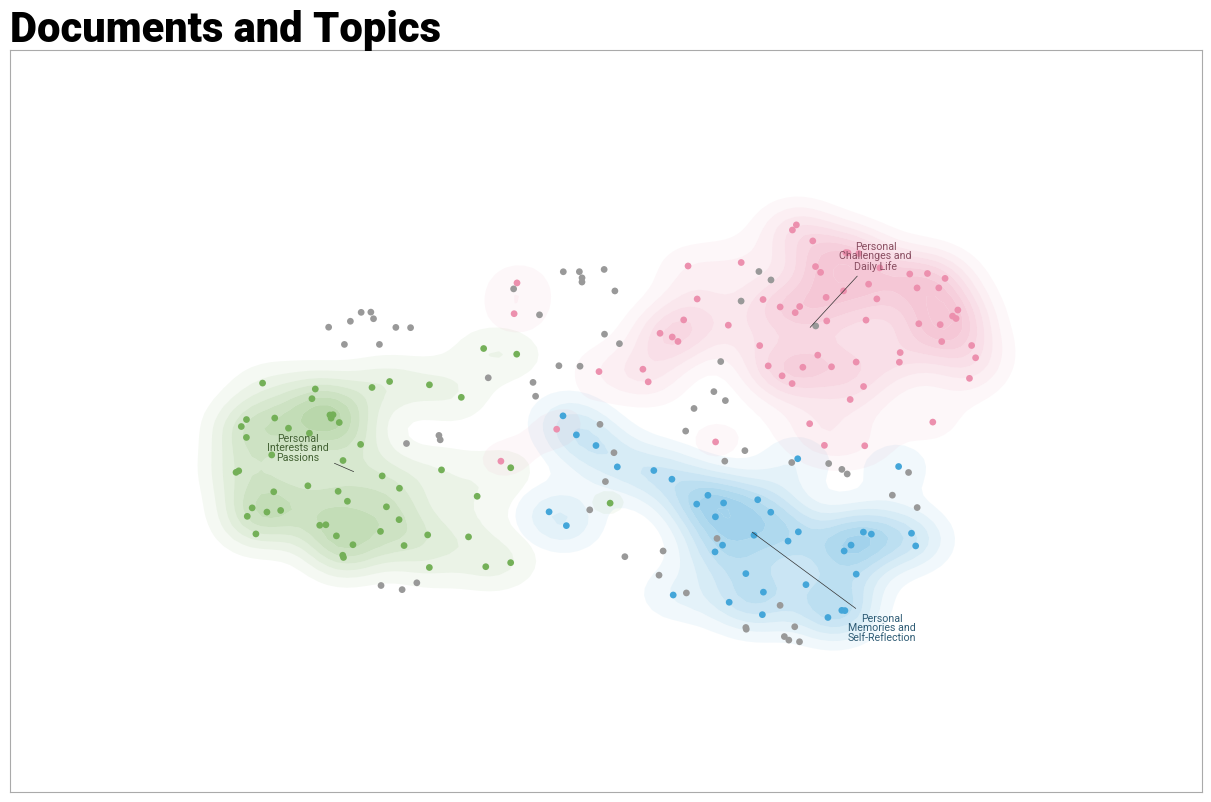

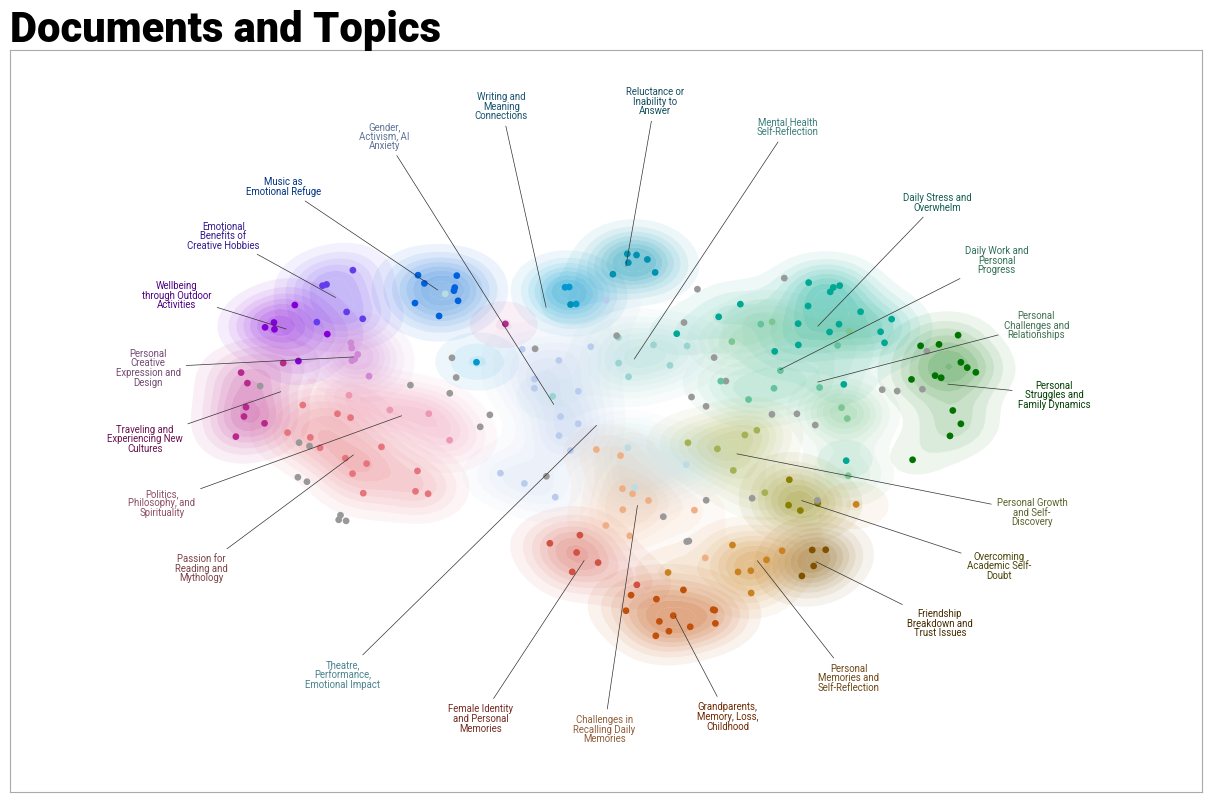

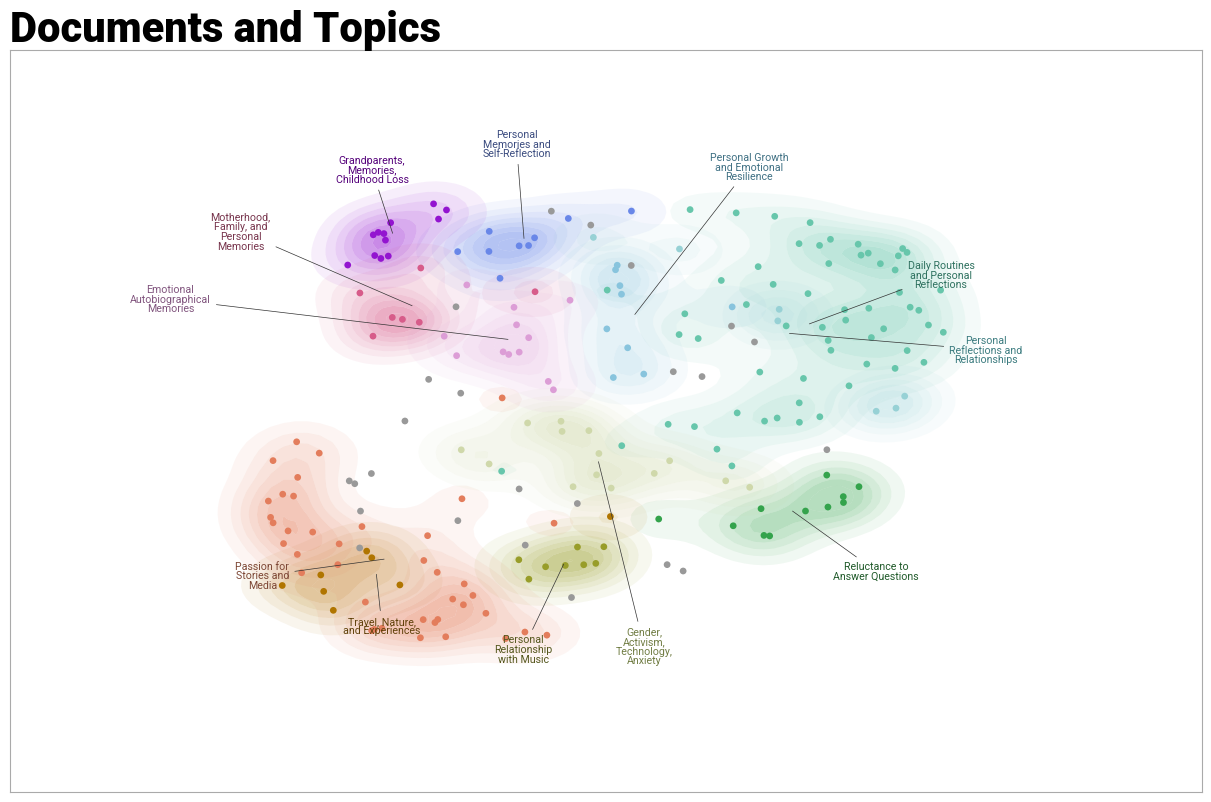

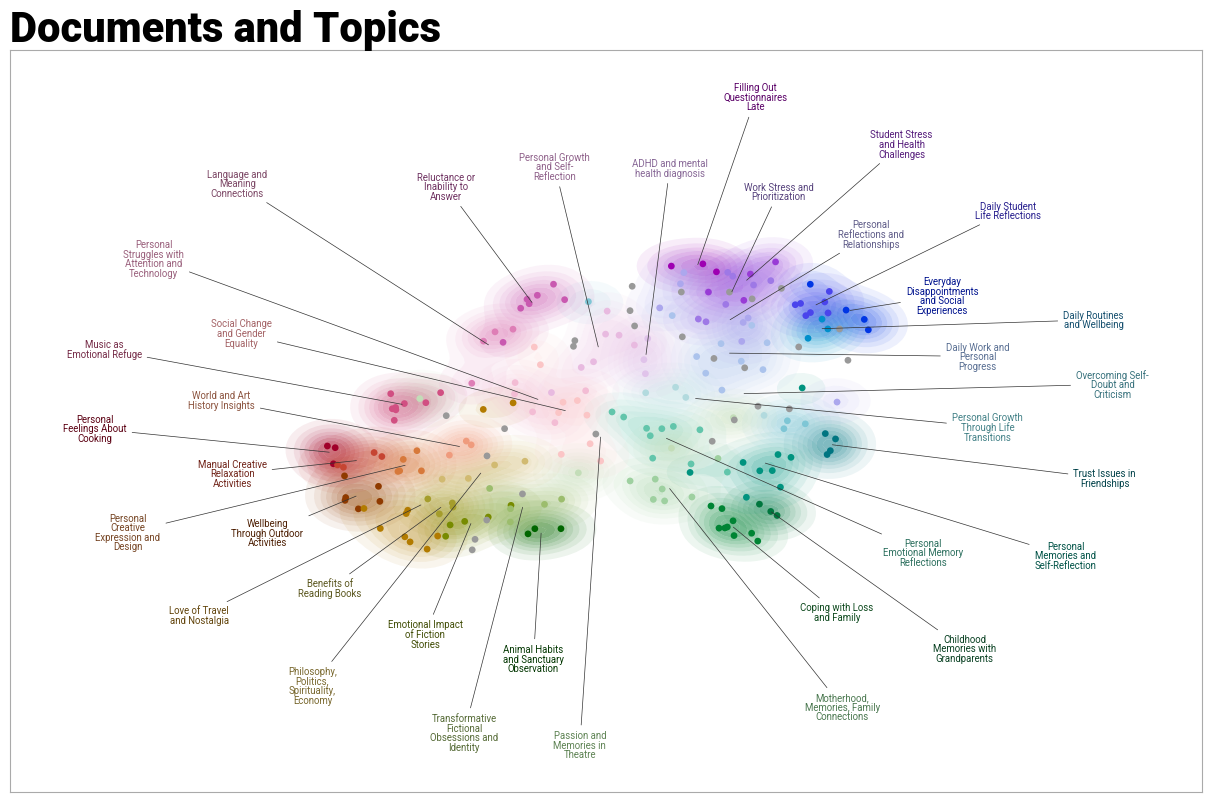

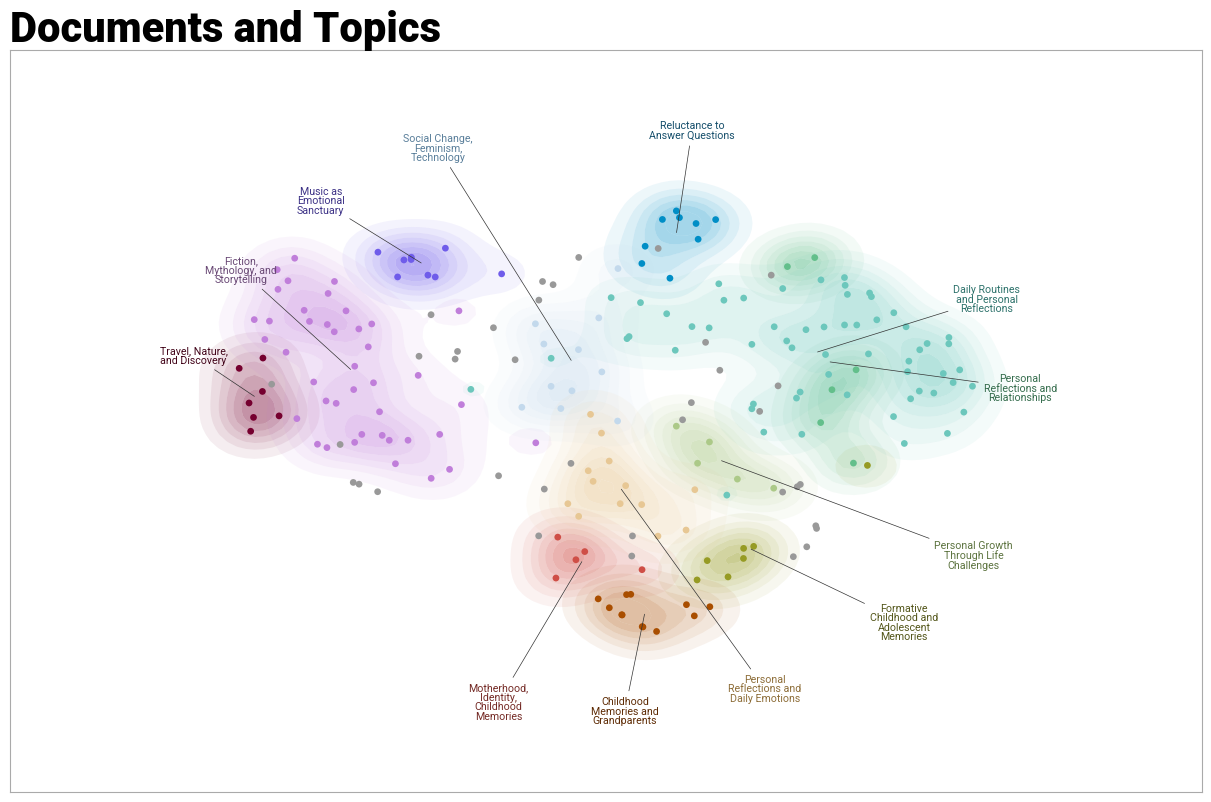

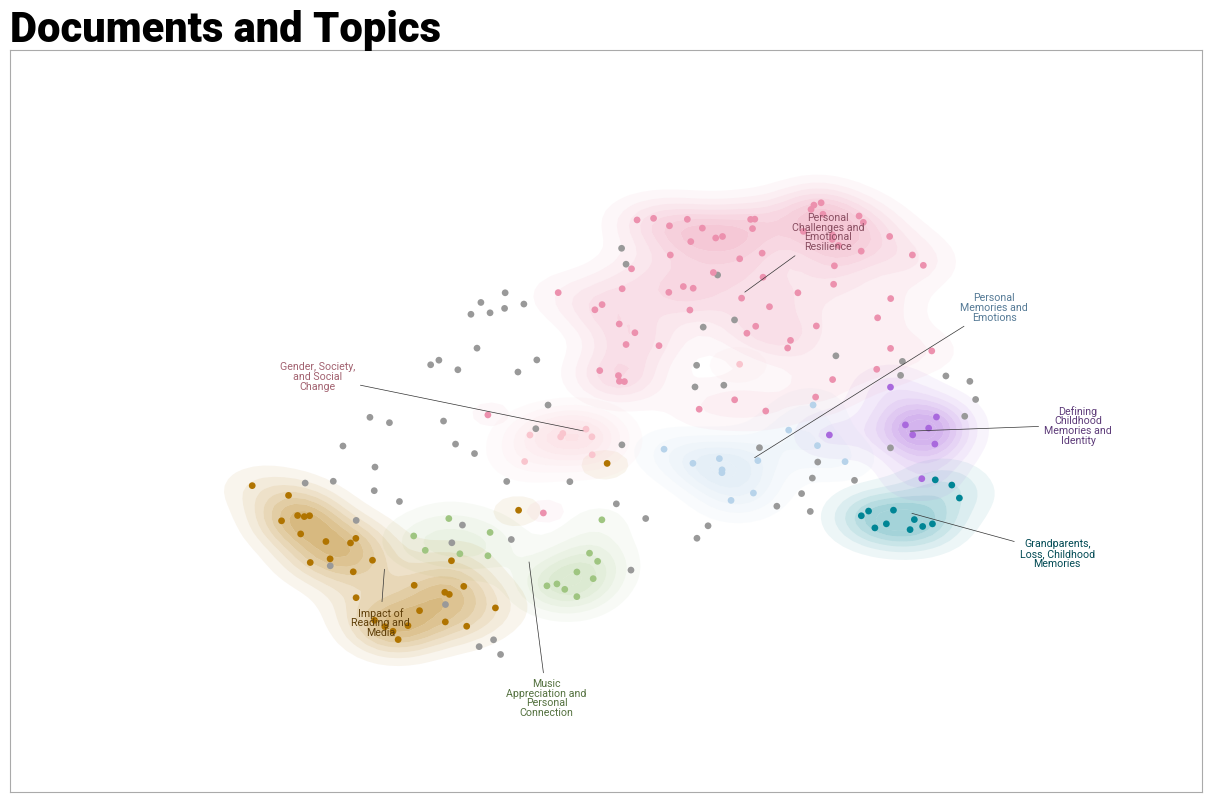

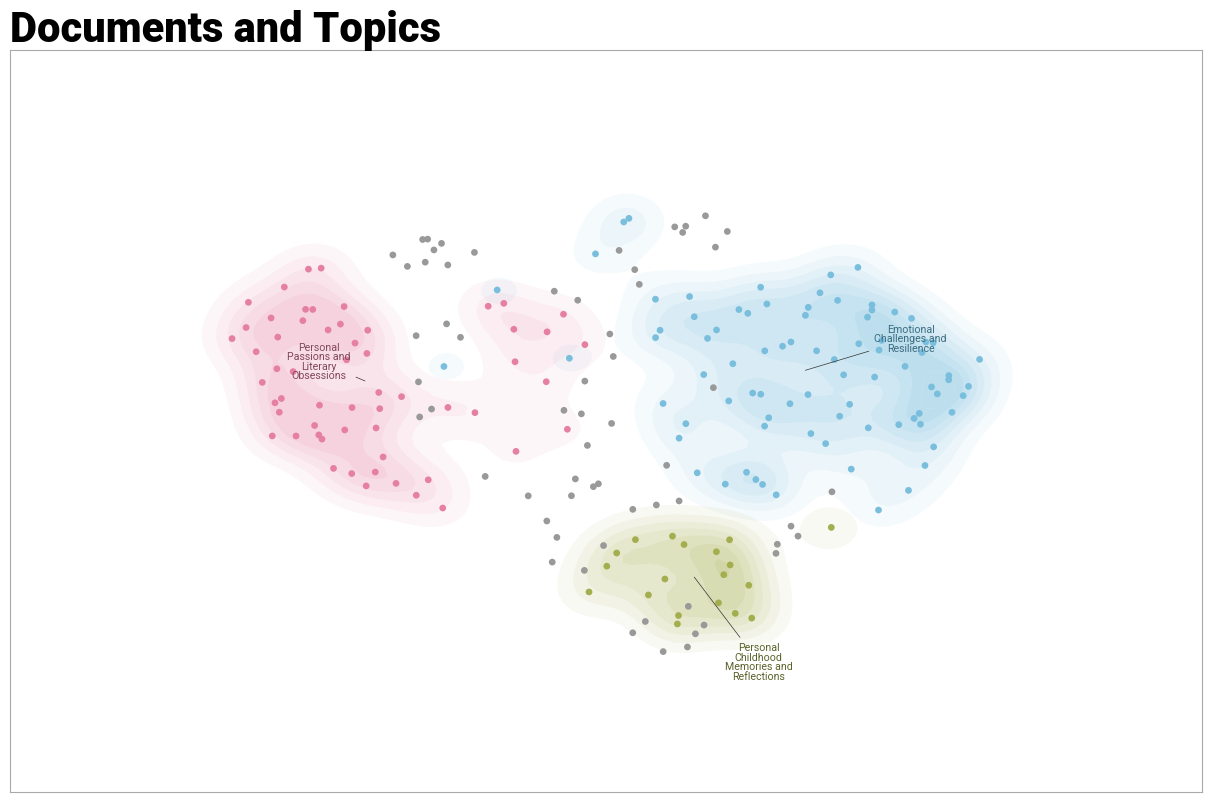

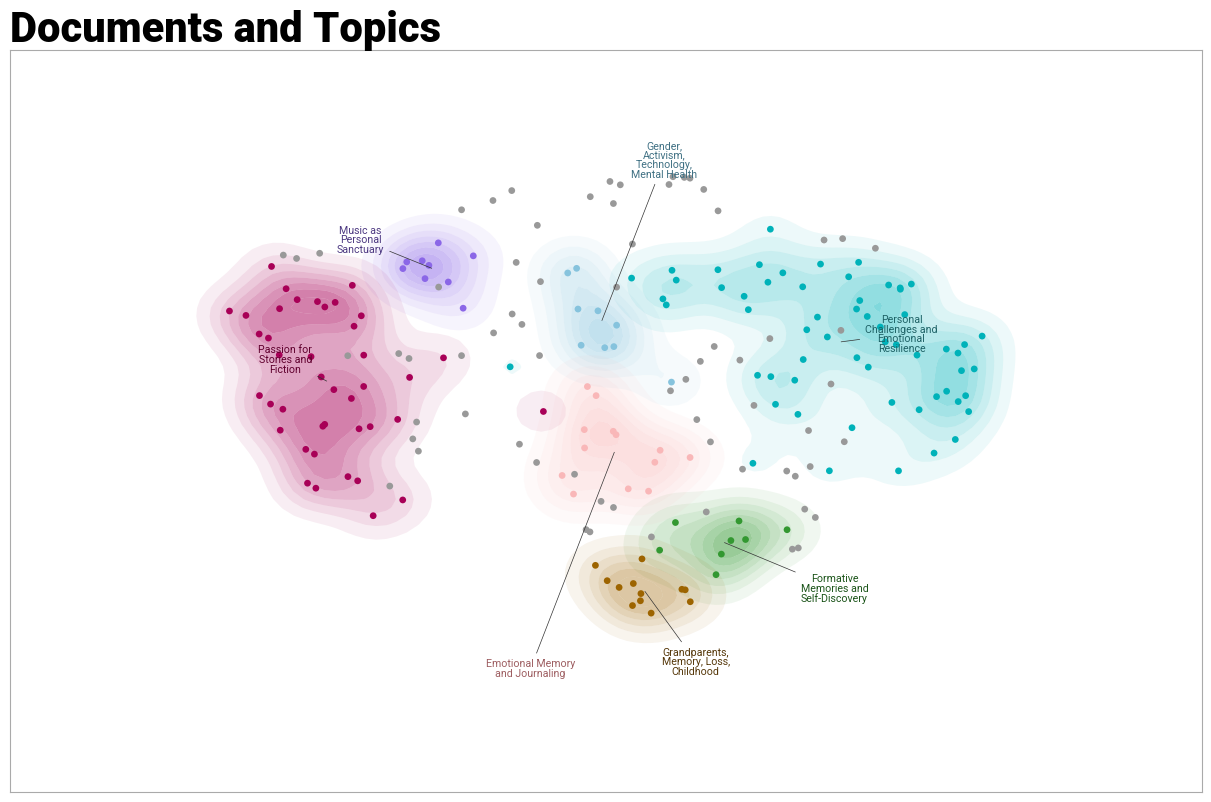

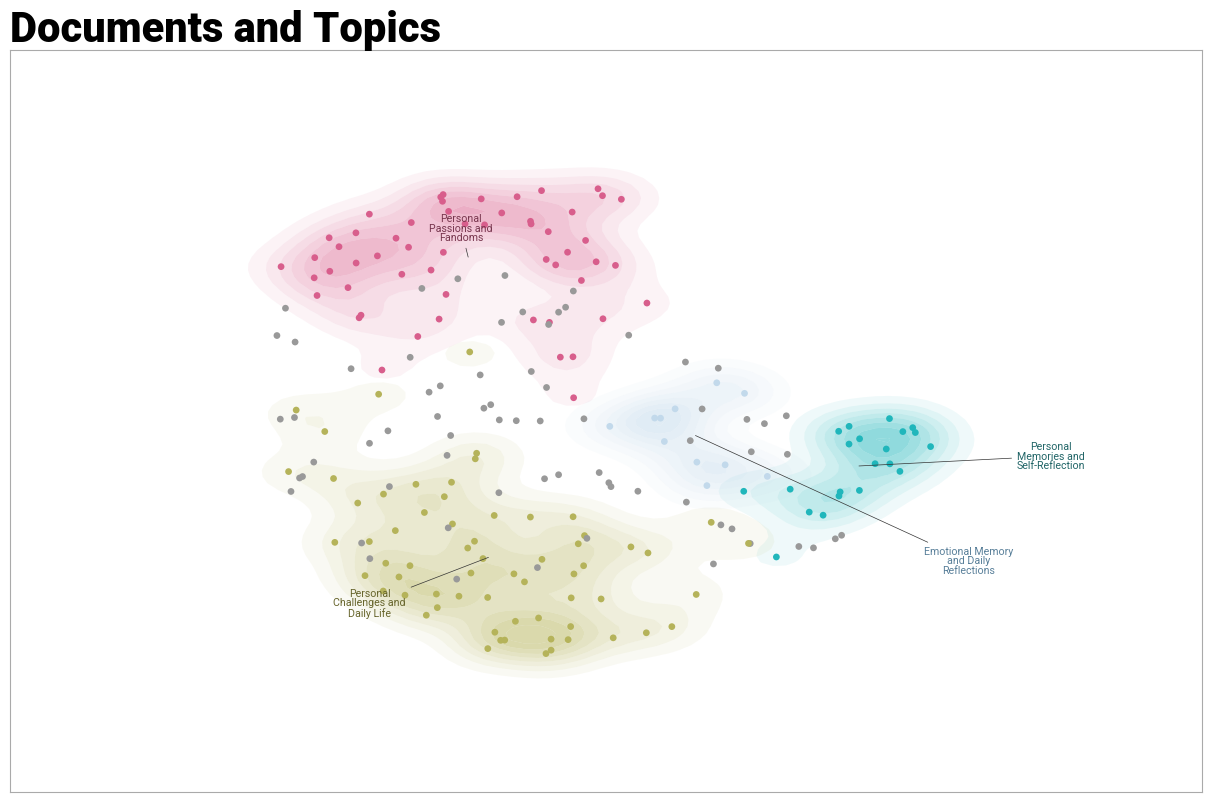

In [20]:
for folder in folders:
    print("=" * 60)
    print(f"Found folder: {folder}")
    print("=" * 60)
    df_group, topic_model, output_folder = preliminary_steps(group_name, folder)
    check_hierarchy(topic_model, df_group, output_folder, group_name)
    run_bertopic_evals(topic_model, df_group, output_folder)
    run_bertopic_viz(topic_model, df_group, output_folder, group_name)

# ADHD

In [21]:
group_name = "ADHD"
folders = [name for name in os.listdir(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/") if os.path.isdir(os.path.join(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/", name))]
folders

['4_20250824_215317',
 '7_20250824_215640',
 '12_20250824_215938',
 '10_20250824_215848',
 '5_20250824_215438',
 '2_20250824_214730',
 '8_20250824_215742',
 '6_20250824_215554',
 '3_20250824_215043']

Found folder: 4_20250824_215317
Running preliminary steps for group: ADHD, folder: 4_20250824_215317
ADHD
🔄 Generating hierarchical topics...


100%|██████████| 2/2 [00:00<00:00, 387.32it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_ADHD as PNG: 20250825_022030_bertopic_hierarchy_adhd.png
📊 Saved bertopic_hierarchy_ADHD as HTML: 20250825_022030_bertopic_hierarchy_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/4_20250824_215317
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 3
📊 Number of real topics (excluding outliers): 3
⚠️  Cannot create topic visualization: Need at least 3 real topics
💡 This model has too few distinct topics for meaningful visualization
Silhouette score calculated on 94 documents across 3 topics
Silhouette Score: 0.0261
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.0631
Individual Topic Coherences:
  Topic 0: -1.2629
  Topic 1: -0.8669
  Topic 2: -1.0594
Coherence results saved to ../../outputs/bertopic_tuning/ADH

Document  Topic  \
0   Não estudo no sentido literal, mas interesso-m...      0   
1                                              Linux!      0   
2   Gosto muito de arrumação gosto de ter tudo arr...      0   
3   Gosto imenso de montanhas russas, às vezes gos...      0   
4   Pedras, necrópoles, minerais, música, cinema, ...      0   
..                                                ...    ...   
89  "O serial killer e o bode espiatorio". O pânic...      0   
90  O ponto em que sociedade se está a tornar,: eg...      0   
91  Gostava que não dissessem : toda a gente tem p...      0   
92  Não sei explicar o que se anda a passar comigo...      0   
93  De momento, na minha cabeça, só rumino sobre o...      0   

                          Name                            CustomName  \
0   0_pessoas_tudo_vida_sempre  Personal Identity and Self-Discovery   
1   0_pessoas_tudo_vida_sempre  Personal Identity and Self-Discovery   
2   0_pessoas_tudo_vida_sempre  Personal Identity and Self-Discovery   
3   0_pessoas_tudo_vida_sempre  Personal Identity and Self-Discovery   
4   0_pessoas_tudo_vida_sempre  Personal Identity and Self-Discovery   
..                         ...                                   ...   
89  0_pessoas_tudo_vida_sempre  Personal Identity and Self-Discovery   
90  0_pessoas_tudo_vida_sempre  Personal Identity and Self-Discovery   
91  0_pessoas_tudo_vida_sempre  Personal Identity and Self-Discovery   
92  0_pessoas_tudo_vida_sempre  Personal Identity and Self-Discovery   
93  0_pessoas_tudo_vida_sempre  Personal Identity and Self-Discovery   

                                       Representation  \
0   [pessoas, tudo, vida, sempre, dia, porque, sei...   
1   [pessoas, tudo, vida, sempre, dia, porque, sei...   
2   [pessoas, tudo, vida, sempre, dia, porque, sei...   
3   [pessoas, tudo, vida, sempre, dia, porque, sei...   
4   [pessoas, tudo, vida, sempre, dia, porque, sei...   
..                                                ...   
89  [pessoas, tudo, vida, sempre, dia, porque, sei...   
90  [pessoas, tudo, vida, sempre, dia, porque, sei...   
91  [pessoas, tudo, vida, sempre, dia, porque, sei...   
92  [pessoas, tudo, vida, sempre, dia, porque, sei...   
93  [pessoas, tudo, vida, sempre, dia, porque, sei...   

                                              KeyBERT  \
0   [mim, sinto, passei, comecei, mental, demasiad...   
1   [mim, sinto, passei, comecei, mental, demasiad...   
2   [mim, sinto, passei, comecei, mental, demasiad...   
3   [mim, sinto, passei, comecei, mental, demasiad...   
4   [mim, sinto, passei, comecei, mental, demasiad...   
..                                                ...   
89  [mim, sinto, passei, comecei, mental, demasiad...   
90  [mim, sinto, passei, comecei, mental, demasiad...   
91  [mim, sinto, passei, comecei, mental, demasiad...   
92  [mim, sinto, passei, comecei, mental, demasiad...   
93  [mim, sinto, passei, comecei, mental, demasiad...   

                                    OpenAI  \
0   [Personal Identity and Self-Discovery]   
1   [Personal Identity and Self-Discovery]   
2   [Personal Identity and Self-Discovery]   
3   [Personal Identity and Self-Discovery]   
4   [Personal Identity and Self-Discovery]   
..                                     ...   
89  [Personal Identity and Self-Discovery]   
90  [Personal Identity and Self-Discovery]   
91  [Personal Identity and Self-Discovery]   
92  [Personal Identity and Self-Discovery]   
93  [Personal Identity and Self-Discovery]   

                                                  MMR  \
0   [vida, gosto, sinto, mim, falar, vezes, coisas...   
1   [vida, gosto, sinto, mim, falar, vezes, coisas...   
2   [vida, gosto, sinto, mim, falar, vezes, coisas...   
3   [vida, gosto, sinto, mim, falar, vezes, coisas...   
4   [vida, gosto, sinto, mim, falar, vezes, coisas...   
..                                                ...   
89  [vida, gosto, sinto, mim, falar, vezes, coisas...   
90  [vida, gosto, sinto, mim, fa

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_ADHD as PNG: 20250825_022032_bertopic_heatmap_adhd.png
📊 Saved bertopic_heatmap_ADHD as HTML: 20250825_022032_bertopic_heatmap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/4_20250824_215317
------------------------------------------------------------


4it [00:00, 207.99it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_ADHD as PNG: 20250825_022034_bertopic_topics_per_class_adhd.png
📊 Saved bertopic_topics_per_class_ADHD as HTML: 20250825_022034_bertopic_topics_per_class_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/4_20250824_215317
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_ADHD as PNG: 20250825_022037_bertopic_document_datamap_adhd.png
📊 Saved bertopic_document_datamap_ADHD as HTML: 20250825_022037_bertopic_document_datamap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/4_20250824_215317
------------------------------------------------------------
✅ Document datamap created successfully
Translating topic words to English...



100%|██████████| 2/2 [00:00<00:00, 446.23it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_ADHD as PNG: 20250825_022045_bertopic_hierarchy_adhd.png
📊 Saved bertopic_hierarchy_ADHD as HTML: 20250825_022045_bertopic_hierarchy_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/7_20250824_215640
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 3
📊 Number of real topics (excluding outliers): 3
⚠️  Cannot create topic visualization: Need at least 3 real topics
💡 This model has too few distinct topics for meaningful visualization
Silhouette score calculated on 94 documents across 3 topics
Silhouette Score: 0.0261
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.0631
Individual Topic Coherences:
  Topic 0: -1.2629
  Topic 1: -0.8669
  Topic 2: -1.0594
Coherence results saved to ../../outputs/bertopic_tuning/ADH

Document  Topic  \
0   Não estudo no sentido literal, mas interesso-m...      0   
1                                              Linux!      0   
2   Gosto muito de arrumação gosto de ter tudo arr...      0   
3   Gosto imenso de montanhas russas, às vezes gos...      0   
4   Pedras, necrópoles, minerais, música, cinema, ...      0   
..                                                ...    ...   
89  "O serial killer e o bode espiatorio". O pânic...      0   
90  O ponto em que sociedade se está a tornar,: eg...      0   
91  Gostava que não dissessem : toda a gente tem p...      0   
92  Não sei explicar o que se anda a passar comigo...      0   
93  De momento, na minha cabeça, só rumino sobre o...      0   

                          Name                            CustomName  \
0   0_pessoas_tudo_vida_sempre  Personal Identity and Self-Discovery   
1   0_pessoas_tudo_vida_sempre  Personal Identity and Self-Discovery   
2   0_pessoas_tudo_vida_sempre  Personal Identity and Self-Discovery   
3   0_pessoas_tudo_vida_sempre  Personal Identity and Self-Discovery   
4   0_pessoas_tudo_vida_sempre  Personal Identity and Self-Discovery   
..                         ...                                   ...   
89  0_pessoas_tudo_vida_sempre  Personal Identity and Self-Discovery   
90  0_pessoas_tudo_vida_sempre  Personal Identity and Self-Discovery   
91  0_pessoas_tudo_vida_sempre  Personal Identity and Self-Discovery   
92  0_pessoas_tudo_vida_sempre  Personal Identity and Self-Discovery   
93  0_pessoas_tudo_vida_sempre  Personal Identity and Self-Discovery   

                                       Representation  \
0   [pessoas, tudo, vida, sempre, dia, porque, sei...   
1   [pessoas, tudo, vida, sempre, dia, porque, sei...   
2   [pessoas, tudo, vida, sempre, dia, porque, sei...   
3   [pessoas, tudo, vida, sempre, dia, porque, sei...   
4   [pessoas, tudo, vida, sempre, dia, porque, sei...   
..                                                ...   
89  [pessoas, tudo, vida, sempre, dia, porque, sei...   
90  [pessoas, tudo, vida, sempre, dia, porque, sei...   
91  [pessoas, tudo, vida, sempre, dia, porque, sei...   
92  [pessoas, tudo, vida, sempre, dia, porque, sei...   
93  [pessoas, tudo, vida, sempre, dia, porque, sei...   

                                              KeyBERT  \
0   [mim, sinto, passei, comecei, mental, demasiad...   
1   [mim, sinto, passei, comecei, mental, demasiad...   
2   [mim, sinto, passei, comecei, mental, demasiad...   
3   [mim, sinto, passei, comecei, mental, demasiad...   
4   [mim, sinto, passei, comecei, mental, demasiad...   
..                                                ...   
89  [mim, sinto, passei, comecei, mental, demasiad...   
90  [mim, sinto, passei, comecei, mental, demasiad...   
91  [mim, sinto, passei, comecei, mental, demasiad...   
92  [mim, sinto, passei, comecei, mental, demasiad...   
93  [mim, sinto, passei, comecei, mental, demasiad...   

                                    OpenAI  \
0   [Personal Identity and Self-Discovery]   
1   [Personal Identity and Self-Discovery]   
2   [Personal Identity and Self-Discovery]   
3   [Personal Identity and Self-Discovery]   
4   [Personal Identity and Self-Discovery]   
..                                     ...   
89  [Personal Identity and Self-Discovery]   
90  [Personal Identity and Self-Discovery]   
91  [Personal Identity and Self-Discovery]   
92  [Personal Identity and Self-Discovery]   
93  [Personal Identity and Self-Discovery]   

                                                  MMR  \
0   [vida, gosto, sinto, mim, falar, vezes, coisas...   
1   [vida, gosto, sinto, mim, falar, vezes, coisas...   
2   [vida, gosto, sinto, mim, falar, vezes, coisas...   
3   [vida, gosto, sinto, mim, falar, vezes, coisas...   
4   [vida, gosto, sinto, mim, falar, vezes, coisas...   
..                                                ...   
89  [vida, gosto, sinto, mim, falar, vezes, coisas...   
90  [vida, gosto, sinto, mim, fa

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_ADHD as PNG: 20250825_022047_bertopic_heatmap_adhd.png
📊 Saved bertopic_heatmap_ADHD as HTML: 20250825_022047_bertopic_heatmap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/7_20250824_215640
------------------------------------------------------------


4it [00:00, 216.58it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_ADHD as PNG: 20250825_022048_bertopic_topics_per_class_adhd.png
📊 Saved bertopic_topics_per_class_ADHD as HTML: 20250825_022048_bertopic_topics_per_class_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/7_20250824_215640
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_ADHD as PNG: 20250825_022051_bertopic_document_datamap_adhd.png
📊 Saved bertopic_document_datamap_ADHD as HTML: 20250825_022051_bertopic_document_datamap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/7_20250824_215640
------------------------------------------------------------
✅ Document datamap created successfully
Translating topic words to English...



100%|██████████| 1/1 [00:00<00:00, 382.27it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_ADHD as PNG: 20250825_022100_bertopic_hierarchy_adhd.png
📊 Saved bertopic_hierarchy_ADHD as HTML: 20250825_022100_bertopic_hierarchy_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/12_20250824_215938
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 3
📊 Number of real topics (excluding outliers): 2
⚠️  Cannot create topic visualization: Need at least 3 real topics
💡 This model has too few distinct topics for meaningful visualization
Silhouette score calculated on 85 documents across 2 topics
Silhouette Score: 0.0311
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.0649
Individual Topic Coherences:
  Topic 0: -1.2629
  Topic 1: -0.8669
Coherence results saved to ../../outputs/bertopic_tuning/ADHD/12_20250824_2159

Document  Topic  \
0   Não estudo no sentido literal, mas interesso-m...      0   
1                                              Linux!      0   
2   Gosto muito de arrumação gosto de ter tudo arr...      0   
3   Gosto imenso de montanhas russas, às vezes gos...      0   
4   Pedras, necrópoles, minerais, música, cinema, ...      0   
..                                                ...    ...   
89  "O serial killer e o bode espiatorio". O pânic...      0   
90  O ponto em que sociedade se está a tornar,: eg...      0   
91  Gostava que não dissessem : toda a gente tem p...      0   
92  Não sei explicar o que se anda a passar comigo...      0   
93  De momento, na minha cabeça, só rumino sobre o...      0   

                          Name                                CustomName  \
0   0_pessoas_tudo_vida_sempre  Personal Growth and Identity Experiences   
1   0_pessoas_tudo_vida_sempre  Personal Growth and Identity Experiences   
2   0_pessoas_tudo_vida_sempre  Personal Growth and Identity Experiences   
3   0_pessoas_tudo_vida_sempre  Personal Growth and Identity Experiences   
4   0_pessoas_tudo_vida_sempre  Personal Growth and Identity Experiences   
..                         ...                                       ...   
89  0_pessoas_tudo_vida_sempre  Personal Growth and Identity Experiences   
90  0_pessoas_tudo_vida_sempre  Personal Growth and Identity Experiences   
91  0_pessoas_tudo_vida_sempre  Personal Growth and Identity Experiences   
92  0_pessoas_tudo_vida_sempre  Personal Growth and Identity Experiences   
93  0_pessoas_tudo_vida_sempre  Personal Growth and Identity Experiences   

                                       Representation  \
0   [pessoas, tudo, vida, sempre, dia, porque, sei...   
1   [pessoas, tudo, vida, sempre, dia, porque, sei...   
2   [pessoas, tudo, vida, sempre, dia, porque, sei...   
3   [pessoas, tudo, vida, sempre, dia, porque, sei...   
4   [pessoas, tudo, vida, sempre, dia, porque, sei...   
..                                                ...   
89  [pessoas, tudo, vida, sempre, dia, porque, sei...   
90  [pessoas, tudo, vida, sempre, dia, porque, sei...   
91  [pessoas, tudo, vida, sempre, dia, porque, sei...   
92  [pessoas, tudo, vida, sempre, dia, porque, sei...   
93  [pessoas, tudo, vida, sempre, dia, porque, sei...   

                                              KeyBERT  \
0   [mim, sinto, passei, comecei, mental, demasiad...   
1   [mim, sinto, passei, comecei, mental, demasiad...   
2   [mim, sinto, passei, comecei, mental, demasiad...   
3   [mim, sinto, passei, comecei, mental, demasiad...   
4   [mim, sinto, passei, comecei, mental, demasiad...   
..                                                ...   
89  [mim, sinto, passei, comecei, mental, demasiad...   
90  [mim, sinto, passei, comecei, mental, demasiad...   
91  [mim, sinto, passei, comecei, mental, demasiad...   
92  [mim, sinto, passei, comecei, mental, demasiad...   
93  [mim, sinto, passei, comecei, mental, demasiad...   

                                        OpenAI  \
0   [Personal Growth and Identity Experiences]   
1   [Personal Growth and Identity Experiences]   
2   [Personal Growth and Identity Experiences]   
3   [Personal Growth and Identity Experiences]   
4   [Personal Growth and Identity Experiences]   
..                                         ...   
89  [Personal Growth and Identity Experiences]   
90  [Personal Growth and Identity Experiences]   
91  [Personal Growth and Identity Experiences]   
92  [Personal Growth and Identity Experiences]   
93  [Personal Growth and Identity Experiences]   

                                                  MMR  \
0   [vida, gosto, fazer, mim, sinto, coisas, nunca...   
1   [vida, gosto, fazer, mim, sinto, coisas, nunca...   
2   [vida, gosto, fazer, mim, sinto, coisas, nunca...   
3   [vida, gosto, fazer, mim, sinto, coisas, nunca...   
4   [vida, gosto, fazer, mim, sinto, coisas, nunca...   
..                                                

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_ADHD as PNG: 20250825_022102_bertopic_heatmap_adhd.png
📊 Saved bertopic_heatmap_ADHD as HTML: 20250825_022102_bertopic_heatmap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/12_20250824_215938
------------------------------------------------------------


4it [00:00, 237.40it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_ADHD as PNG: 20250825_022104_bertopic_topics_per_class_adhd.png
📊 Saved bertopic_topics_per_class_ADHD as HTML: 20250825_022104_bertopic_topics_per_class_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/12_20250824_215938
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_ADHD as PNG: 20250825_022106_bertopic_document_datamap_adhd.png
📊 Saved bertopic_document_datamap_ADHD as HTML: 20250825_022106_bertopic_document_datamap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/12_20250824_215938
------------------------------------------------------------
✅ Document datamap created successfully
Translating topic words to English...

100%|██████████| 1/1 [00:00<00:00, 392.69it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_ADHD as PNG: 20250825_022113_bertopic_hierarchy_adhd.png
📊 Saved bertopic_hierarchy_ADHD as HTML: 20250825_022113_bertopic_hierarchy_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/10_20250824_215848
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 3
📊 Number of real topics (excluding outliers): 2
⚠️  Cannot create topic visualization: Need at least 3 real topics
💡 This model has too few distinct topics for meaningful visualization
Silhouette score calculated on 85 documents across 2 topics
Silhouette Score: 0.0305
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.0649
Individual Topic Coherences:
  Topic 0: -1.2629
  Topic 1: -0.8669
Coherence results saved to ../../outputs/bertopic_tuning/ADHD/10_20250824_2158

Document  Topic  \
0   Não estudo no sentido literal, mas interesso-m...      0   
1                                              Linux!      0   
2   Gosto muito de arrumação gosto de ter tudo arr...      0   
3   Gosto imenso de montanhas russas, às vezes gos...      0   
4   Pedras, necrópoles, minerais, música, cinema, ...      0   
..                                                ...    ...   
89  "O serial killer e o bode espiatorio". O pânic...      0   
90  O ponto em que sociedade se está a tornar,: eg...      0   
91  Gostava que não dissessem : toda a gente tem p...      0   
92  Não sei explicar o que se anda a passar comigo...      0   
93  De momento, na minha cabeça, só rumino sobre o...      0   

                          Name                    CustomName  \
0   0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
1   0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
2   0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
3   0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
4   0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
..                         ...                           ...   
89  0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
90  0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
91  0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
92  0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
93  0_pessoas_tudo_vida_sempre  Personal Growth and Identity   

                                       Representation  \
0   [pessoas, tudo, vida, sempre, dia, porque, sei...   
1   [pessoas, tudo, vida, sempre, dia, porque, sei...   
2   [pessoas, tudo, vida, sempre, dia, porque, sei...   
3   [pessoas, tudo, vida, sempre, dia, porque, sei...   
4   [pessoas, tudo, vida, sempre, dia, porque, sei...   
..                                                ...   
89  [pessoas, tudo, vida, sempre, dia, porque, sei...   
90  [pessoas, tudo, vida, sempre, dia, porque, sei...   
91  [pessoas, tudo, vida, sempre, dia, porque, sei...   
92  [pessoas, tudo, vida, sempre, dia, porque, sei...   
93  [pessoas, tudo, vida, sempre, dia, porque, sei...   

                                              KeyBERT  \
0   [mim, sinto, passei, comecei, mental, demasiad...   
1   [mim, sinto, passei, comecei, mental, demasiad...   
2   [mim, sinto, passei, comecei, mental, demasiad...   
3   [mim, sinto, passei, comecei, mental, demasiad...   
4   [mim, sinto, passei, comecei, mental, demasiad...   
..                                                ...   
89  [mim, sinto, passei, comecei, mental, demasiad...   
90  [mim, sinto, passei, comecei, mental, demasiad...   
91  [mim, sinto, passei, comecei, mental, demasiad...   
92  [mim, sinto, passei, comecei, mental, demasiad...   
93  [mim, sinto, passei, comecei, mental, demasiad...   

                            OpenAI  \
0   [Personal Growth and Identity]   
1   [Personal Growth and Identity]   
2   [Personal Growth and Identity]   
3   [Personal Growth and Identity]   
4   [Personal Growth and Identity]   
..                             ...   
89  [Personal Growth and Identity]   
90  [Personal Growth and Identity]   
91  [Personal Growth and Identity]   
92  [Personal Growth and Identity]   
93  [Personal Growth and Identity]   

                                                  MMR  \
0   [vida, gosto, sinto, mim, falar, vezes, coisas...   
1   [vida, gosto, sinto, mim, falar, vezes, coisas...   
2   [vida, gosto, sinto, mim, falar, vezes, coisas...   
3   [vida, gosto, sinto, mim, falar, vezes, coisas...   
4   [vida, gosto, sinto, mim, falar, vezes, coisas...   
..                                                ...   
89  [vida, gosto, sinto, mim, falar, vezes, coisas...   
90  [vida, gosto, sinto, mim, falar, vezes, coisas...   
91  [vida, gosto, sinto, mim, falar, vezes, coisas...   
92  [vida, gosto, sinto, mim, falar, vezes, coisas...   
93  [vida, gosto, sinto, mim, falar, vezes, coisas...

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_ADHD as PNG: 20250825_022115_bertopic_heatmap_adhd.png
📊 Saved bertopic_heatmap_ADHD as HTML: 20250825_022115_bertopic_heatmap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/10_20250824_215848
------------------------------------------------------------


4it [00:00, 219.96it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_ADHD as PNG: 20250825_022116_bertopic_topics_per_class_adhd.png
📊 Saved bertopic_topics_per_class_ADHD as HTML: 20250825_022116_bertopic_topics_per_class_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/10_20250824_215848
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_ADHD as PNG: 20250825_022119_bertopic_document_datamap_adhd.png
📊 Saved bertopic_document_datamap_ADHD as HTML: 20250825_022119_bertopic_document_datamap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/10_20250824_215848
------------------------------------------------------------
✅ Document datamap created successfully
Translating topic words to English...

100%|██████████| 2/2 [00:00<00:00, 447.66it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_ADHD as PNG: 20250825_022126_bertopic_hierarchy_adhd.png
📊 Saved bertopic_hierarchy_ADHD as HTML: 20250825_022126_bertopic_hierarchy_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/5_20250824_215438
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 3
📊 Number of real topics (excluding outliers): 3
⚠️  Cannot create topic visualization: Need at least 3 real topics
💡 This model has too few distinct topics for meaningful visualization
Silhouette score calculated on 94 documents across 3 topics
Silhouette Score: 0.0261
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.0631
Individual Topic Coherences:
  Topic 0: -1.2629
  Topic 1: -0.8669
  Topic 2: -1.0594
Coherence results saved to ../../outputs/bertopic_tuning/ADH

Document  Topic  \
0   Não estudo no sentido literal, mas interesso-m...      0   
1                                              Linux!      0   
2   Gosto muito de arrumação gosto de ter tudo arr...      0   
3   Gosto imenso de montanhas russas, às vezes gos...      0   
4   Pedras, necrópoles, minerais, música, cinema, ...      0   
..                                                ...    ...   
89  "O serial killer e o bode espiatorio". O pânic...      0   
90  O ponto em que sociedade se está a tornar,: eg...      0   
91  Gostava que não dissessem : toda a gente tem p...      0   
92  Não sei explicar o que se anda a passar comigo...      0   
93  De momento, na minha cabeça, só rumino sobre o...      0   

                          Name                    CustomName  \
0   0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
1   0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
2   0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
3   0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
4   0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
..                         ...                           ...   
89  0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
90  0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
91  0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
92  0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
93  0_pessoas_tudo_vida_sempre  Personal Growth and Identity   

                                       Representation  \
0   [pessoas, tudo, vida, sempre, dia, porque, sei...   
1   [pessoas, tudo, vida, sempre, dia, porque, sei...   
2   [pessoas, tudo, vida, sempre, dia, porque, sei...   
3   [pessoas, tudo, vida, sempre, dia, porque, sei...   
4   [pessoas, tudo, vida, sempre, dia, porque, sei...   
..                                                ...   
89  [pessoas, tudo, vida, sempre, dia, porque, sei...   
90  [pessoas, tudo, vida, sempre, dia, porque, sei...   
91  [pessoas, tudo, vida, sempre, dia, porque, sei...   
92  [pessoas, tudo, vida, sempre, dia, porque, sei...   
93  [pessoas, tudo, vida, sempre, dia, porque, sei...   

                                              KeyBERT  \
0   [mim, sinto, passei, comecei, mental, demasiad...   
1   [mim, sinto, passei, comecei, mental, demasiad...   
2   [mim, sinto, passei, comecei, mental, demasiad...   
3   [mim, sinto, passei, comecei, mental, demasiad...   
4   [mim, sinto, passei, comecei, mental, demasiad...   
..                                                ...   
89  [mim, sinto, passei, comecei, mental, demasiad...   
90  [mim, sinto, passei, comecei, mental, demasiad...   
91  [mim, sinto, passei, comecei, mental, demasiad...   
92  [mim, sinto, passei, comecei, mental, demasiad...   
93  [mim, sinto, passei, comecei, mental, demasiad...   

                            OpenAI  \
0   [Personal Growth and Identity]   
1   [Personal Growth and Identity]   
2   [Personal Growth and Identity]   
3   [Personal Growth and Identity]   
4   [Personal Growth and Identity]   
..                             ...   
89  [Personal Growth and Identity]   
90  [Personal Growth and Identity]   
91  [Personal Growth and Identity]   
92  [Personal Growth and Identity]   
93  [Personal Growth and Identity]   

                                                  MMR  \
0   [vida, gosto, sinto, mim, falar, vezes, coisas...   
1   [vida, gosto, sinto, mim, falar, vezes, coisas...   
2   [vida, gosto, sinto, mim, falar, vezes, coisas...   
3   [vida, gosto, sinto, mim, falar, vezes, coisas...   
4   [vida, gosto, sinto, mim, falar, vezes, coisas...   
..                                                ...   
89  [vida, gosto, sinto, mim, falar, vezes, coisas...   
90  [vida, gosto, sinto, mim, falar, vezes, coisas...   
91  [vida, gosto, sinto, mim, falar, vezes, coisas...   
92  [vida, gosto, sinto, mim, falar, vezes, coisas...   
93  [vida, gosto, sinto, mim, falar, vezes, coisas...

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_ADHD as PNG: 20250825_022128_bertopic_heatmap_adhd.png
📊 Saved bertopic_heatmap_ADHD as HTML: 20250825_022128_bertopic_heatmap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/5_20250824_215438
------------------------------------------------------------


4it [00:00, 216.16it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_ADHD as PNG: 20250825_022129_bertopic_topics_per_class_adhd.png
📊 Saved bertopic_topics_per_class_ADHD as HTML: 20250825_022129_bertopic_topics_per_class_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/5_20250824_215438
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_ADHD as PNG: 20250825_022132_bertopic_document_datamap_adhd.png
📊 Saved bertopic_document_datamap_ADHD as HTML: 20250825_022132_bertopic_document_datamap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/5_20250824_215438
------------------------------------------------------------
✅ Document datamap created successfully
Translating topic words to English...



100%|██████████| 12/12 [00:00<00:00, 618.11it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_ADHD as PNG: 20250825_022141_bertopic_hierarchy_adhd.png
📊 Saved bertopic_hierarchy_ADHD as HTML: 20250825_022141_bertopic_hierarchy_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/2_20250824_214730
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 14
📊 Number of real topics (excluding outliers): 13
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_ADHD as PNG: 20250825_022142_bertopic_topics_adhd.png
📊 Saved bertopic_topics_ADHD as HTML: 20250825_022142_bertopic_topics_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/2_20250824_214730
----------------------------------------------------------

Document  Topic  \
0   Não estudo no sentido literal, mas interesso-m...      8   
1                                              Linux!     -1   
2   Gosto muito de arrumação gosto de ter tudo arr...      7   
3   Gosto imenso de montanhas russas, às vezes gos...      6   
4   Pedras, necrópoles, minerais, música, cinema, ...      4   
..                                                ...    ...   
89  "O serial killer e o bode espiatorio". O pânic...      3   
90  O ponto em que sociedade se está a tornar,: eg...     -1   
91  Gostava que não dissessem : toda a gente tem p...      3   
92  Não sei explicar o que se anda a passar comigo...     12   
93  De momento, na minha cabeça, só rumino sobre o...      1   

                                 Name                              CustomName  \
0         8_geral_estudo_saúde_mental          Human Psychology and Wellbeing   
1          -1_mim_amigos_passei_vezes                           Outlier Topic   
2    7_gosto_zonas_normalmente_focada     Activities for Relaxation and Focus   
3   6_apresentação_gosto_fez_primeira  Thrill, Adrenaline, and Self-Discovery   
4            4_tão_áreas_mundo_apenas  Human Creativity and Complex Interests   
..                                ...                                     ...   
89     3_phda_lá_continua_diagnóstico     ADHD Diagnosis and Daily Challenges   
90         -1_mim_amigos_passei_vezes                           Outlier Topic   
91     3_phda_lá_continua_diagnóstico     ADHD Diagnosis and Daily Challenges   
92       12_falar_pessoa_pessoas_vida          Self-Esteem and Social Anxiety   
93         1_fazer_nada_sinto_consigo           Academic Stress and Overwhelm   

                                       Representation  \
0   [geral, estudo, saúde, mental, humana, cuidar,...   
1   [mim, amigos, passei, vezes, dia, todos, manei...   
2   [gosto, zonas, normalmente, focada, usar, enco...   
3   [apresentação, gosto, fez, primeira, menos, cé...   
4   [tão, áreas, mundo, apenas, interesse especial...   
..                                                ...   
89  [phda, lá, continua, diagnóstico, medicação, p...   
90  [mim, amigos, passei, vezes, dia, todos, manei...   
91  [phda, lá, continua, diagnóstico, medicação, p...   
92  [falar, pessoa, pessoas, vida, comigo, aborrec...   
93  [fazer, nada, sinto, consigo, tempo, montes, t...   

                                              KeyBERT  \
0   [psicologia, saúde mental, mental, pensamentos...   
1   [mim, depressão, comigo mesma, sinto, passei, ...   
2   [stressar, correr, usar, consigo, tempo, busca...   
3   [memórias, altos baixos, mim, apeteceu, situaç...   
4   [fascinante, interesse especial, criar, compos...   
..                                                ...   
89  [psiquiatra, diagnóstico, pânico, depressão, p...   
90  [mim, depressão, comigo mesma, sinto, passei, ...   
91  [psiquiatra, diagnóstico, pânico, depressão, p...   
92  [medo, aborrecimento, comigo própria, comigo, ...   
93  [faço, difícil, comigo própria, sinto, trabalh...   

                                      OpenAI  \
0           [Human Psychology and Wellbeing]   
1    [Identity, Belonging, Social Exclusion]   
2      [Activities for Relaxation and Focus]   
3   [Thrill, Adrenaline, and Self-Discovery]   
4   [Human Creativity and Complex Interests]   
..                                       ...   
89     [ADHD Diagnosis and Daily Challenges]   
90   [Identity, Belonging, Social Exclusion]   
91     [ADHD Diagnosis and Daily Challenges]   
92          [Self-Esteem and Social Anxiety]   
93           [Academic Stress and Overwhelm]   

                                                  MMR  \
0   [geral, estudo, saúde, cuidar, psicologia, exi...   
1   [mim, amigos, passei, vezes, dia, nunca, nesse...   
2   [zonas, normalmente, focada, encontrar, stress...   
3   [apresentação, primeira, jogo, vezes, vida, al...   
4   [mundo, interesse especial, própria, pergunta ...   
..            

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_ADHD as PNG: 20250825_022144_bertopic_heatmap_adhd.png
📊 Saved bertopic_heatmap_ADHD as HTML: 20250825_022144_bertopic_heatmap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/2_20250824_214730
------------------------------------------------------------


4it [00:00, 147.50it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_ADHD as PNG: 20250825_022146_bertopic_topics_per_class_adhd.png
📊 Saved bertopic_topics_per_class_ADHD as HTML: 20250825_022146_bertopic_topics_per_class_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/2_20250824_214730
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_ADHD as PNG: 20250825_022149_bertopic_document_datamap_adhd.png
📊 Saved bertopic_document_datamap_ADHD as HTML: 20250825_022149_bertopic_document_datamap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/2_20250824_214730
------------------------------------------------------------
✅ Document datamap created successfully
Translating topic words to English...



100%|██████████| 2/2 [00:00<00:00, 478.15it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_ADHD as PNG: 20250825_022217_bertopic_hierarchy_adhd.png
📊 Saved bertopic_hierarchy_ADHD as HTML: 20250825_022217_bertopic_hierarchy_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/8_20250824_215742
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 3
📊 Number of real topics (excluding outliers): 3
⚠️  Cannot create topic visualization: Need at least 3 real topics
💡 This model has too few distinct topics for meaningful visualization
Silhouette score calculated on 94 documents across 3 topics
Silhouette Score: 0.0261
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.0631
Individual Topic Coherences:
  Topic 0: -1.2629
  Topic 1: -0.8669
  Topic 2: -1.0594
Coherence results saved to ../../outputs/bertopic_tuning/ADH

Document  Topic  \
0   Não estudo no sentido literal, mas interesso-m...      0   
1                                              Linux!      0   
2   Gosto muito de arrumação gosto de ter tudo arr...      0   
3   Gosto imenso de montanhas russas, às vezes gos...      0   
4   Pedras, necrópoles, minerais, música, cinema, ...      0   
..                                                ...    ...   
89  "O serial killer e o bode espiatorio". O pânic...      0   
90  O ponto em que sociedade se está a tornar,: eg...      0   
91  Gostava que não dissessem : toda a gente tem p...      0   
92  Não sei explicar o que se anda a passar comigo...      0   
93  De momento, na minha cabeça, só rumino sobre o...      0   

                          Name                    CustomName  \
0   0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
1   0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
2   0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
3   0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
4   0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
..                         ...                           ...   
89  0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
90  0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
91  0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
92  0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
93  0_pessoas_tudo_vida_sempre  Personal Growth and Identity   

                                       Representation  \
0   [pessoas, tudo, vida, sempre, dia, porque, sei...   
1   [pessoas, tudo, vida, sempre, dia, porque, sei...   
2   [pessoas, tudo, vida, sempre, dia, porque, sei...   
3   [pessoas, tudo, vida, sempre, dia, porque, sei...   
4   [pessoas, tudo, vida, sempre, dia, porque, sei...   
..                                                ...   
89  [pessoas, tudo, vida, sempre, dia, porque, sei...   
90  [pessoas, tudo, vida, sempre, dia, porque, sei...   
91  [pessoas, tudo, vida, sempre, dia, porque, sei...   
92  [pessoas, tudo, vida, sempre, dia, porque, sei...   
93  [pessoas, tudo, vida, sempre, dia, porque, sei...   

                                              KeyBERT  \
0   [mim, sinto, passei, comecei, mental, demasiad...   
1   [mim, sinto, passei, comecei, mental, demasiad...   
2   [mim, sinto, passei, comecei, mental, demasiad...   
3   [mim, sinto, passei, comecei, mental, demasiad...   
4   [mim, sinto, passei, comecei, mental, demasiad...   
..                                                ...   
89  [mim, sinto, passei, comecei, mental, demasiad...   
90  [mim, sinto, passei, comecei, mental, demasiad...   
91  [mim, sinto, passei, comecei, mental, demasiad...   
92  [mim, sinto, passei, comecei, mental, demasiad...   
93  [mim, sinto, passei, comecei, mental, demasiad...   

                            OpenAI  \
0   [Personal Growth and Identity]   
1   [Personal Growth and Identity]   
2   [Personal Growth and Identity]   
3   [Personal Growth and Identity]   
4   [Personal Growth and Identity]   
..                             ...   
89  [Personal Growth and Identity]   
90  [Personal Growth and Identity]   
91  [Personal Growth and Identity]   
92  [Personal Growth and Identity]   
93  [Personal Growth and Identity]   

                                                  MMR  \
0   [vida, gosto, sinto, mim, falar, vezes, coisas...   
1   [vida, gosto, sinto, mim, falar, vezes, coisas...   
2   [vida, gosto, sinto, mim, falar, vezes, coisas...   
3   [vida, gosto, sinto, mim, falar, vezes, coisas...   
4   [vida, gosto, sinto, mim, falar, vezes, coisas...   
..                                                ...   
89  [vida, gosto, sinto, mim, falar, vezes, coisas...   
90  [vida, gosto, sinto, mim, falar, vezes, coisas...   
91  [vida, gosto, sinto, mim, falar, vezes, coisas...   
92  [vida, gosto, sinto, mim, falar, vezes, coisas...   
93  [vida, gosto, sinto, mim, falar, vezes, coisas...

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_ADHD as PNG: 20250825_022219_bertopic_heatmap_adhd.png
📊 Saved bertopic_heatmap_ADHD as HTML: 20250825_022219_bertopic_heatmap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/8_20250824_215742
------------------------------------------------------------


4it [00:00, 217.29it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_ADHD as PNG: 20250825_022220_bertopic_topics_per_class_adhd.png
📊 Saved bertopic_topics_per_class_ADHD as HTML: 20250825_022220_bertopic_topics_per_class_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/8_20250824_215742
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_ADHD as PNG: 20250825_022223_bertopic_document_datamap_adhd.png
📊 Saved bertopic_document_datamap_ADHD as HTML: 20250825_022223_bertopic_document_datamap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/8_20250824_215742
------------------------------------------------------------
✅ Document datamap created successfully
Translating topic words to English...



100%|██████████| 2/2 [00:00<00:00, 330.05it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_ADHD as PNG: 20250825_022232_bertopic_hierarchy_adhd.png
📊 Saved bertopic_hierarchy_ADHD as HTML: 20250825_022232_bertopic_hierarchy_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/6_20250824_215554
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 3
📊 Number of real topics (excluding outliers): 3
⚠️  Cannot create topic visualization: Need at least 3 real topics
💡 This model has too few distinct topics for meaningful visualization
Silhouette score calculated on 94 documents across 3 topics
Silhouette Score: 0.0261
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.0631
Individual Topic Coherences:
  Topic 0: -1.2629
  Topic 1: -0.8669
  Topic 2: -1.0594
Coherence results saved to ../../outputs/bertopic_tuning/ADH

Document  Topic  \
0   Não estudo no sentido literal, mas interesso-m...      0   
1                                              Linux!      0   
2   Gosto muito de arrumação gosto de ter tudo arr...      0   
3   Gosto imenso de montanhas russas, às vezes gos...      0   
4   Pedras, necrópoles, minerais, música, cinema, ...      0   
..                                                ...    ...   
89  "O serial killer e o bode espiatorio". O pânic...      0   
90  O ponto em que sociedade se está a tornar,: eg...      0   
91  Gostava que não dissessem : toda a gente tem p...      0   
92  Não sei explicar o que se anda a passar comigo...      0   
93  De momento, na minha cabeça, só rumino sobre o...      0   

                          Name                    CustomName  \
0   0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
1   0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
2   0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
3   0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
4   0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
..                         ...                           ...   
89  0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
90  0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
91  0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
92  0_pessoas_tudo_vida_sempre  Personal Growth and Identity   
93  0_pessoas_tudo_vida_sempre  Personal Growth and Identity   

                                       Representation  \
0   [pessoas, tudo, vida, sempre, dia, porque, sei...   
1   [pessoas, tudo, vida, sempre, dia, porque, sei...   
2   [pessoas, tudo, vida, sempre, dia, porque, sei...   
3   [pessoas, tudo, vida, sempre, dia, porque, sei...   
4   [pessoas, tudo, vida, sempre, dia, porque, sei...   
..                                                ...   
89  [pessoas, tudo, vida, sempre, dia, porque, sei...   
90  [pessoas, tudo, vida, sempre, dia, porque, sei...   
91  [pessoas, tudo, vida, sempre, dia, porque, sei...   
92  [pessoas, tudo, vida, sempre, dia, porque, sei...   
93  [pessoas, tudo, vida, sempre, dia, porque, sei...   

                                              KeyBERT  \
0   [mim, sinto, passei, comecei, mental, demasiad...   
1   [mim, sinto, passei, comecei, mental, demasiad...   
2   [mim, sinto, passei, comecei, mental, demasiad...   
3   [mim, sinto, passei, comecei, mental, demasiad...   
4   [mim, sinto, passei, comecei, mental, demasiad...   
..                                                ...   
89  [mim, sinto, passei, comecei, mental, demasiad...   
90  [mim, sinto, passei, comecei, mental, demasiad...   
91  [mim, sinto, passei, comecei, mental, demasiad...   
92  [mim, sinto, passei, comecei, mental, demasiad...   
93  [mim, sinto, passei, comecei, mental, demasiad...   

                            OpenAI  \
0   [Personal Growth and Identity]   
1   [Personal Growth and Identity]   
2   [Personal Growth and Identity]   
3   [Personal Growth and Identity]   
4   [Personal Growth and Identity]   
..                             ...   
89  [Personal Growth and Identity]   
90  [Personal Growth and Identity]   
91  [Personal Growth and Identity]   
92  [Personal Growth and Identity]   
93  [Personal Growth and Identity]   

                                                  MMR  \
0   [vida, gosto, sinto, mim, falar, vezes, coisas...   
1   [vida, gosto, sinto, mim, falar, vezes, coisas...   
2   [vida, gosto, sinto, mim, falar, vezes, coisas...   
3   [vida, gosto, sinto, mim, falar, vezes, coisas...   
4   [vida, gosto, sinto, mim, falar, vezes, coisas...   
..                                                ...   
89  [vida, gosto, sinto, mim, falar, vezes, coisas...   
90  [vida, gosto, sinto, mim, falar, vezes, coisas...   
91  [vida, gosto, sinto, mim, falar, vezes, coisas...   
92  [vida, gosto, sinto, mim, falar, vezes, coisas...   
93  [vida, gosto, sinto, mim, falar, vezes, coisas...

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_ADHD as PNG: 20250825_022234_bertopic_heatmap_adhd.png
📊 Saved bertopic_heatmap_ADHD as HTML: 20250825_022234_bertopic_heatmap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/6_20250824_215554
------------------------------------------------------------


4it [00:00, 196.08it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_ADHD as PNG: 20250825_022235_bertopic_topics_per_class_adhd.png
📊 Saved bertopic_topics_per_class_ADHD as HTML: 20250825_022235_bertopic_topics_per_class_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/6_20250824_215554
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_ADHD as PNG: 20250825_022238_bertopic_document_datamap_adhd.png
📊 Saved bertopic_document_datamap_ADHD as HTML: 20250825_022238_bertopic_document_datamap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/6_20250824_215554
------------------------------------------------------------
✅ Document datamap created successfully
Translating topic words to English...



100%|██████████| 6/6 [00:00<00:00, 524.57it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_ADHD as PNG: 20250825_022247_bertopic_hierarchy_adhd.png
📊 Saved bertopic_hierarchy_ADHD as HTML: 20250825_022247_bertopic_hierarchy_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/3_20250824_215043
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 8
📊 Number of real topics (excluding outliers): 7
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_ADHD as PNG: 20250825_022249_bertopic_topics_adhd.png
📊 Saved bertopic_topics_ADHD as HTML: 20250825_022249_bertopic_topics_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/3_20250824_215043
------------------------------------------------------------

Document  Topic  \
0   Não estudo no sentido literal, mas interesso-m...      2   
1                                              Linux!     -1   
2   Gosto muito de arrumação gosto de ter tudo arr...      0   
3   Gosto imenso de montanhas russas, às vezes gos...      3   
4   Pedras, necrópoles, minerais, música, cinema, ...      6   
..                                                ...    ...   
89  "O serial killer e o bode espiatorio". O pânic...      4   
90  O ponto em que sociedade se está a tornar,: eg...     -1   
91  Gostava que não dissessem : toda a gente tem p...      4   
92  Não sei explicar o que se anda a passar comigo...     -1   
93  De momento, na minha cabeça, só rumino sobre o...      0   

                             Name                              CustomName  \
0   2_saúde_tudo_mental_interesse     Holistic Health and Human Curiosity   
1    -1_comigo_pessoas_falar_vida                           Outlier Topic   
2       0_tempo_dia_fazer_consigo  Academic Stress and Identity Struggles   
3       3_jogo_animal_serem_gosto    Personal Interests and Animal Ethics   
4        6_tão_áreas_mundo_apenas  Human Creativity and Complex Interests   
..                            ...                                     ...   
89     4_phda_lá_pessoas_continua  ADHD Diagnosis and Societal Challenges   
90   -1_comigo_pessoas_falar_vida                           Outlier Topic   
91     4_phda_lá_pessoas_continua  ADHD Diagnosis and Societal Challenges   
92   -1_comigo_pessoas_falar_vida                           Outlier Topic   
93      0_tempo_dia_fazer_consigo  Academic Stress and Identity Struggles   

                                       Representation  \
0   [saúde, tudo, mental, interesse, etc, nada, in...   
1   [comigo, pessoas, falar, vida, amigos, vezes, ...   
2   [tempo, dia, fazer, consigo, nada, sinto, come...   
3   [jogo, animal, serem, gosto, apresentação, fez...   
4   [tão, áreas, mundo, apenas, interesse especial...   
..                                                ...   
89  [phda, lá, pessoas, continua, porque, medicaçã...   
90  [comigo, pessoas, falar, vida, amigos, vezes, ...   
91  [phda, lá, pessoas, continua, porque, medicaçã...   
92  [comigo, pessoas, falar, vida, amigos, vezes, ...   
93  [tempo, dia, fazer, consigo, nada, sinto, come...   

                                              KeyBERT  \
0   [saúde mental, interesses, interesses especiai...   
1   [vezes sinto, comigo mesma, mim, sinto, depres...   
2   [stressar, memórias, mim, sinto, comigo própri...   
3   [serem, terem, apeteceu, situações, empática, ...   
4   [fascinante, interesse especial, criar, compos...   
..                                                ...   
89  [psiquiatra, diagnóstico, pânico, depressão, p...   
90  [vezes sinto, comigo mesma, mim, sinto, depres...   
91  [psiquiatra, diagnóstico, pânico, depressão, p...   
92  [vezes sinto, comigo mesma, mim, sinto, depres...   
93  [stressar, memórias, mim, sinto, comigo própri...   

                                      OpenAI  \
0      [Holistic Health and Human Curiosity]   
1       [Social Belonging and Self-Identity]   
2   [Academic Stress and Identity Struggles]   
3     [Personal Interests and Animal Ethics]   
4   [Human Creativity and Complex Interests]   
..                                       ...   
89  [ADHD Diagnosis and Societal Challenges]   
90      [Social Belonging and Self-Identity]   
91  [ADHD Diagnosis and Societal Challenges]   
92      [Social Belonging and Self-Identity]   
93  [Academic Stress and Identity Struggles]   

                                                  MMR  \
0   [tudo, interesses especiais, saúde mental, sab...   
1   [falar, amigos, vezes, mim, nunca, nesse dia, ...   
2   [tempo, sinto, comecei, coisas, ainda, gosto, ...   
3   [animal, gosto, primeira, menos, motivos, joga...   
4   [interesse especial, composição, mente, mundo ...   
..                                                ...   
89  [

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_ADHD as PNG: 20250825_022250_bertopic_heatmap_adhd.png
📊 Saved bertopic_heatmap_ADHD as HTML: 20250825_022250_bertopic_heatmap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/3_20250824_215043
------------------------------------------------------------


4it [00:00, 171.59it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_ADHD as PNG: 20250825_022252_bertopic_topics_per_class_adhd.png
📊 Saved bertopic_topics_per_class_ADHD as HTML: 20250825_022252_bertopic_topics_per_class_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/3_20250824_215043
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_ADHD as PNG: 20250825_022255_bertopic_document_datamap_adhd.png
📊 Saved bertopic_document_datamap_ADHD as HTML: 20250825_022255_bertopic_document_datamap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/ADHD/3_20250824_215043
------------------------------------------------------------
✅ Document datamap created successfully
Translating topic words to English...



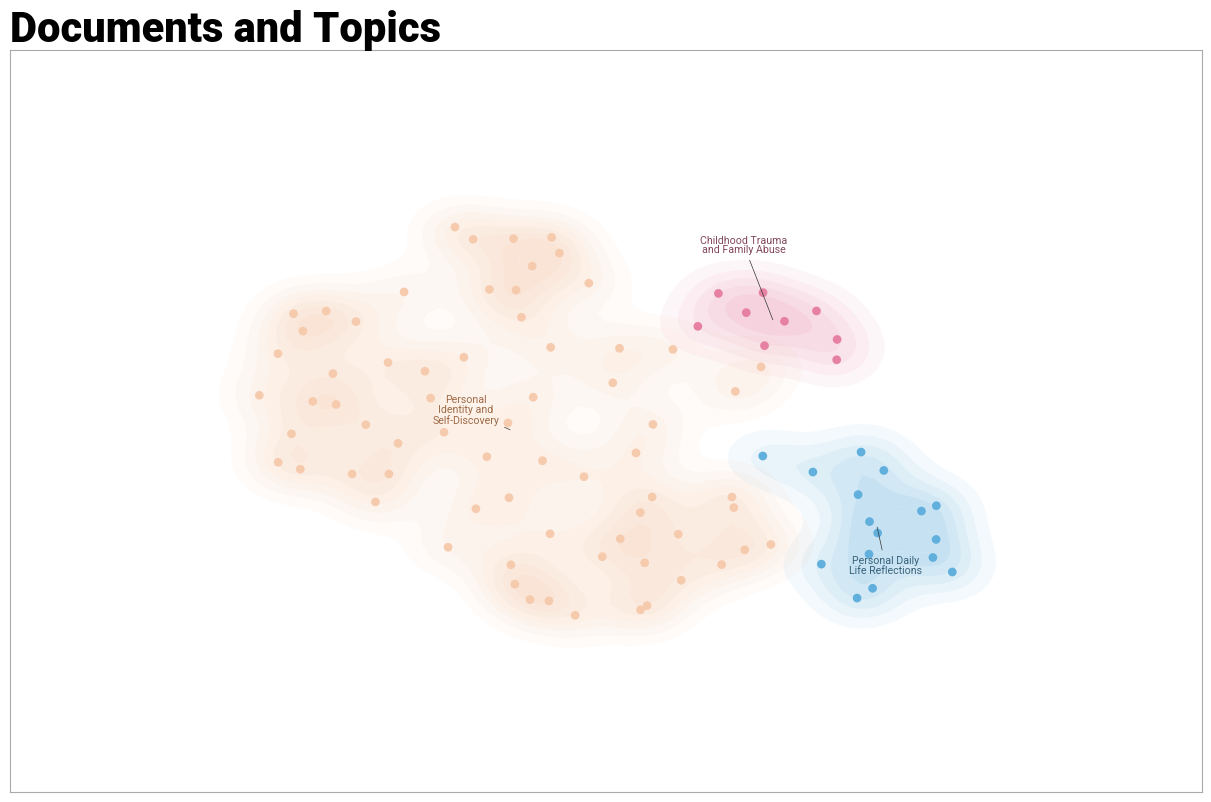

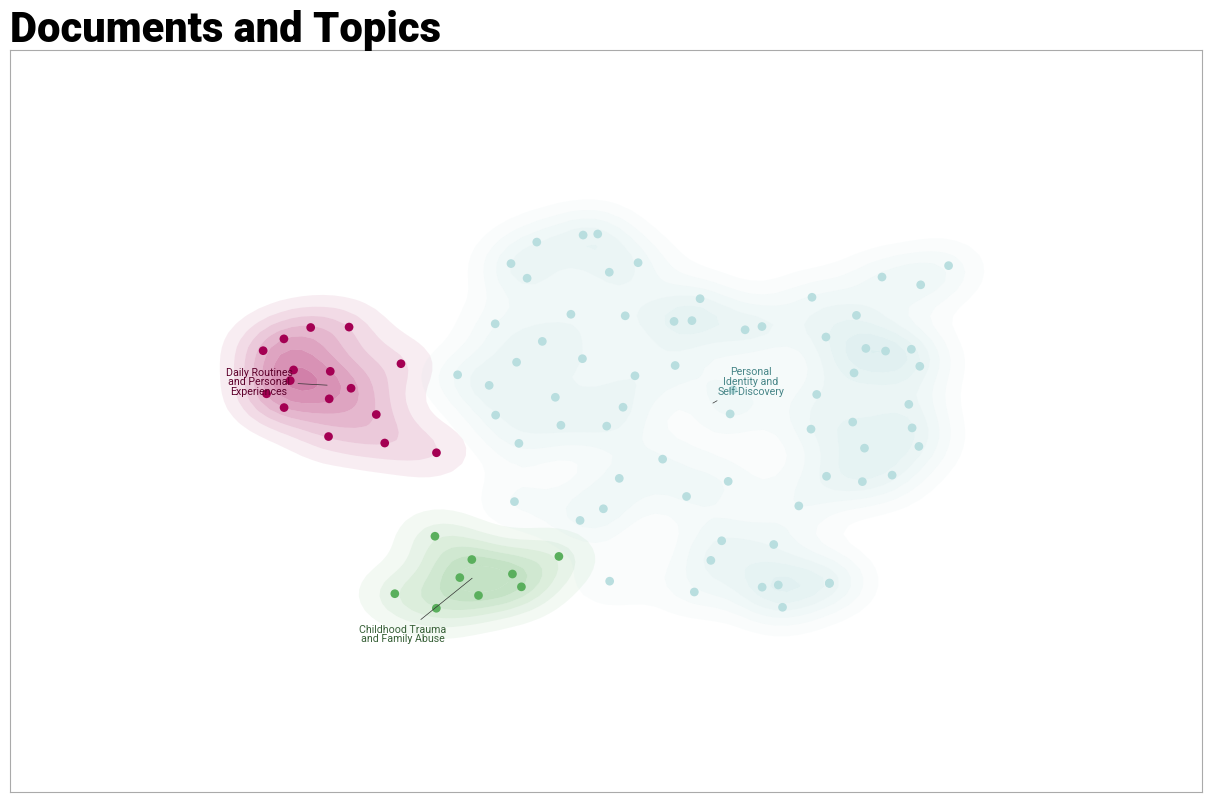

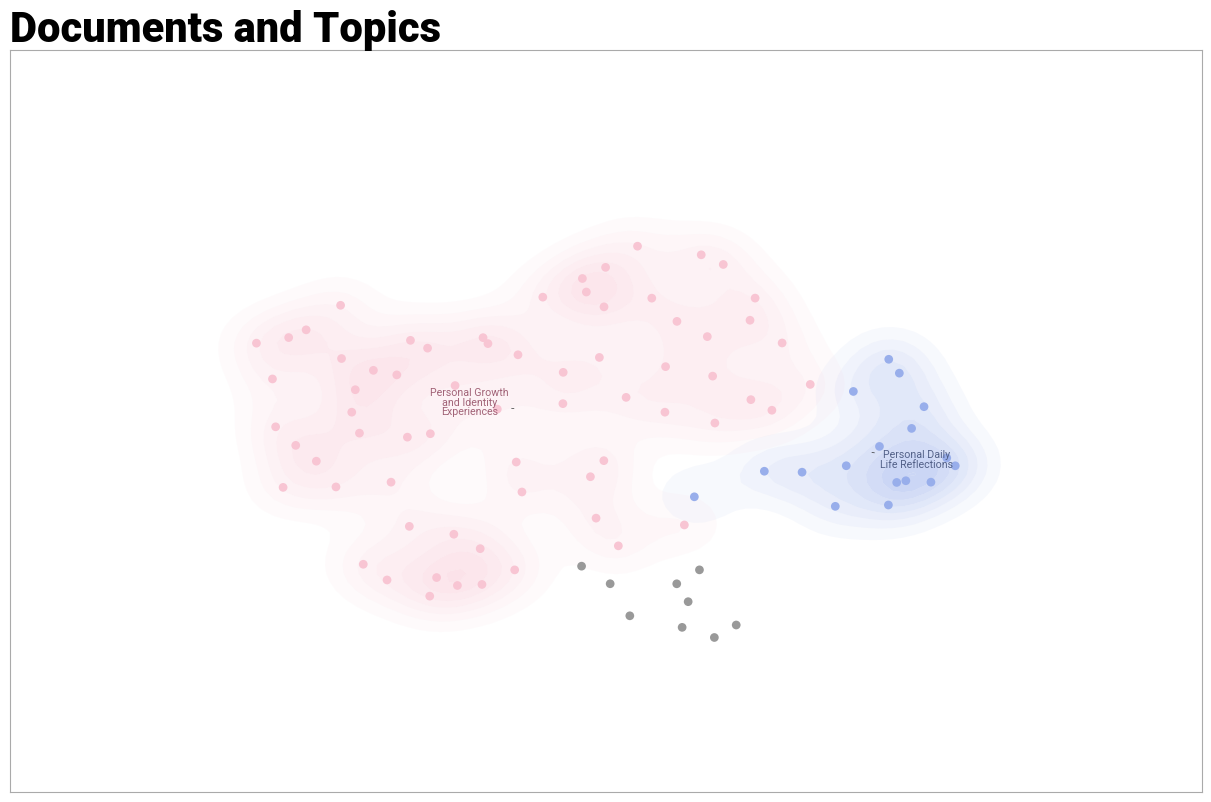

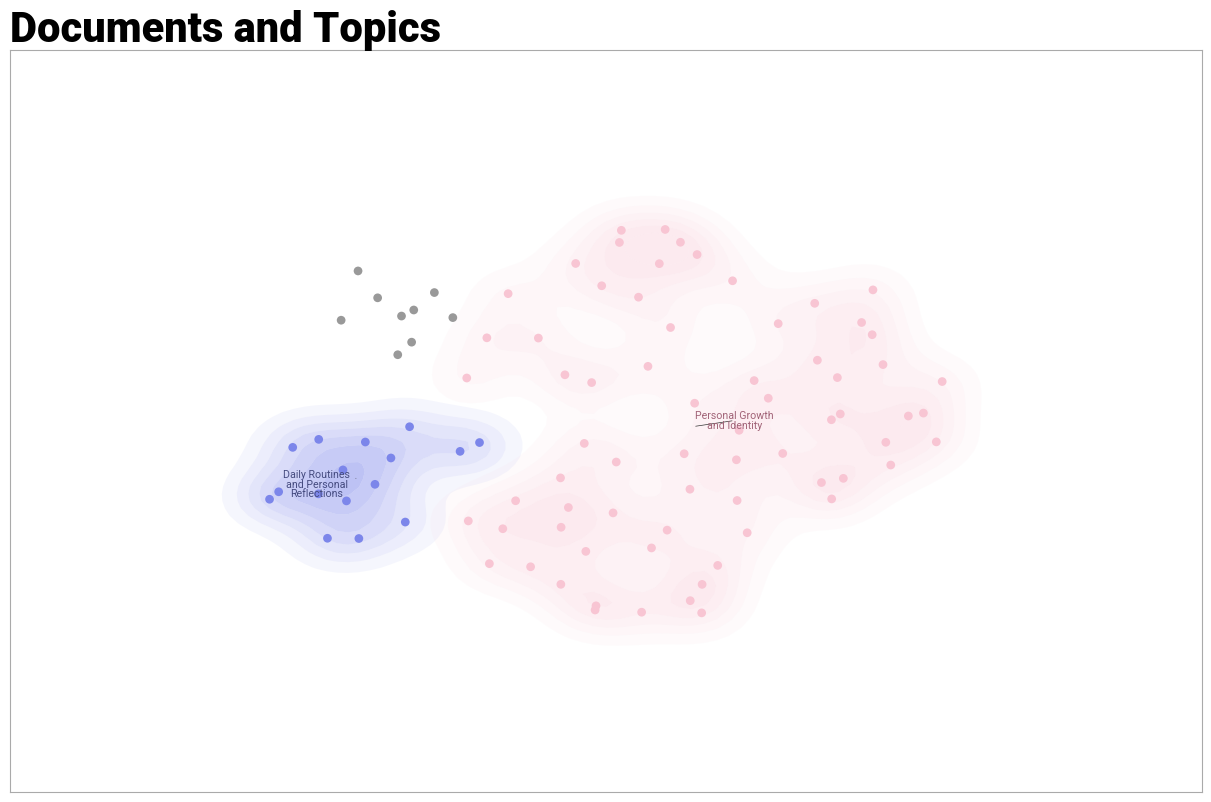

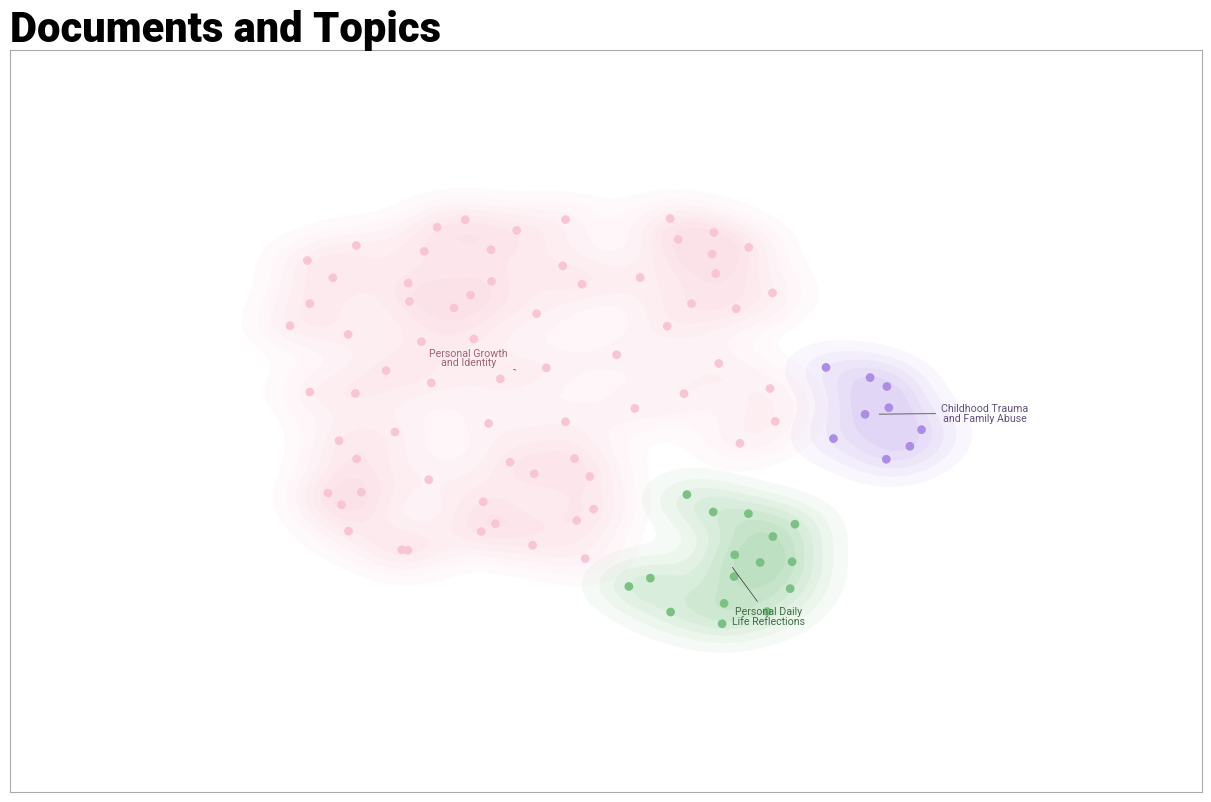

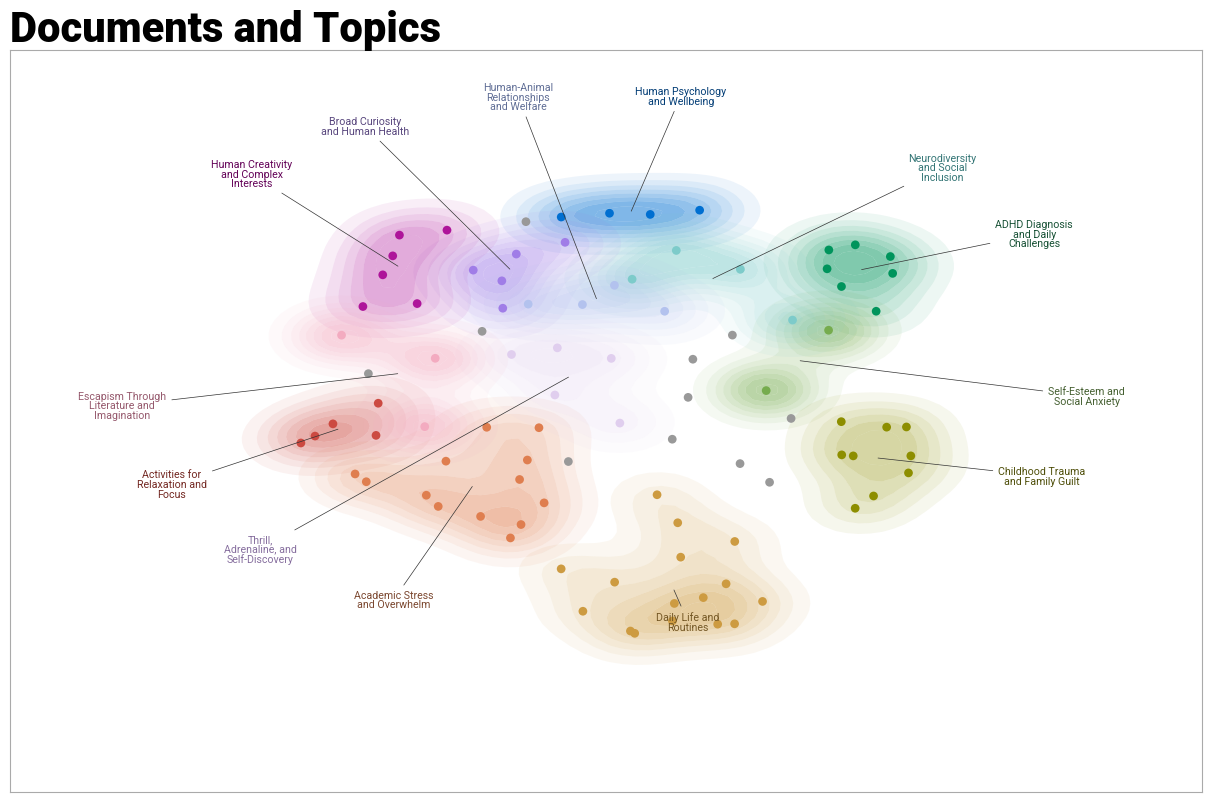

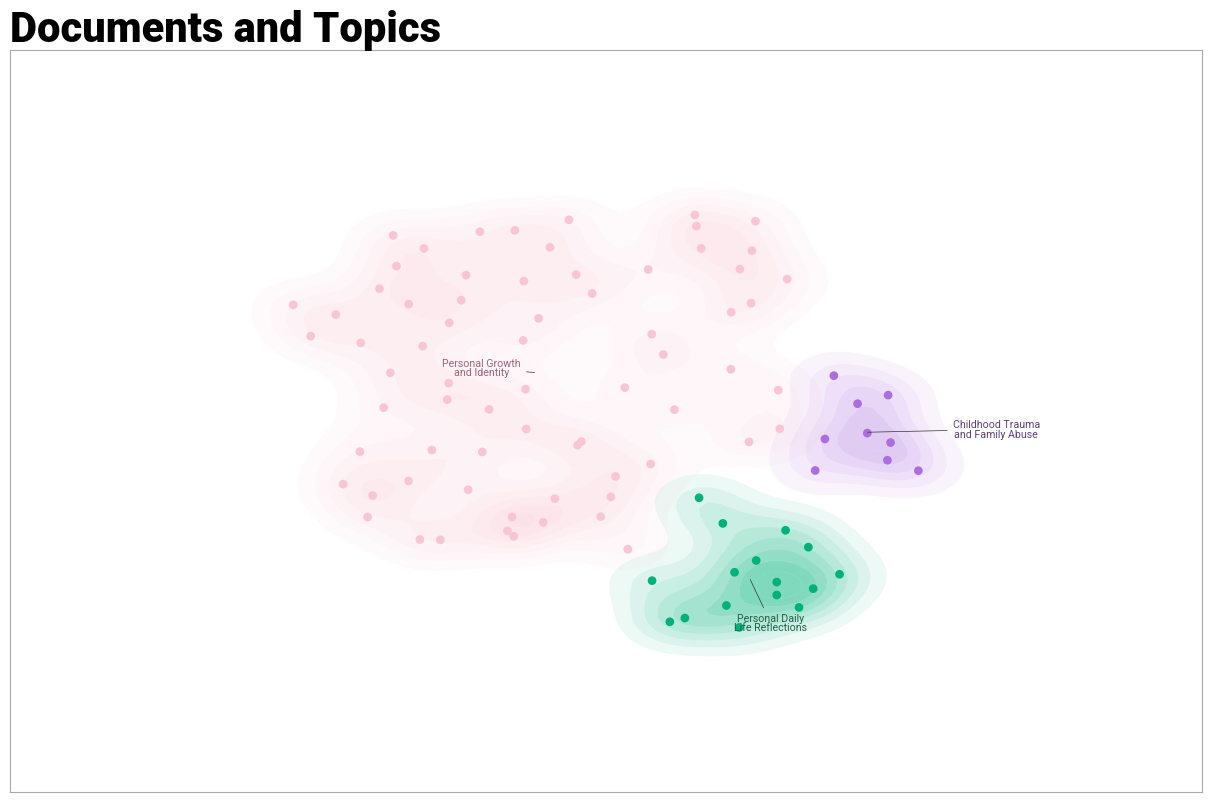

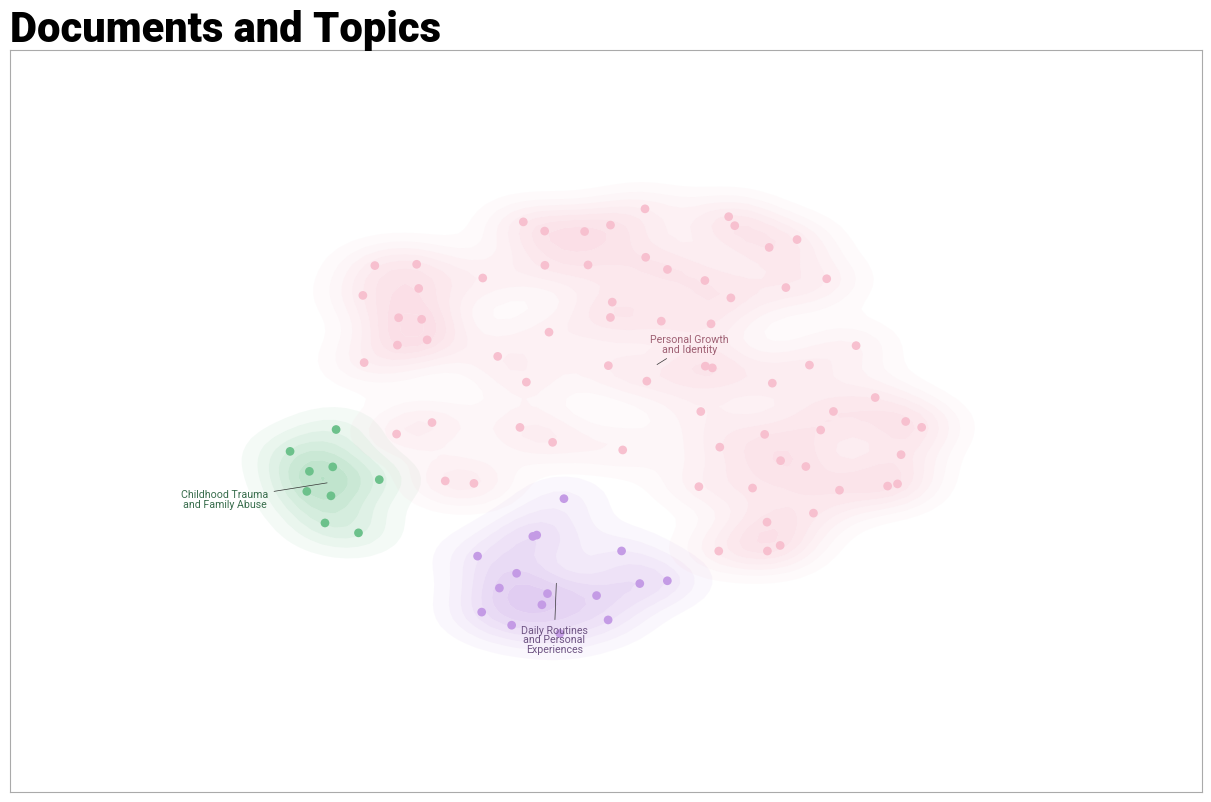

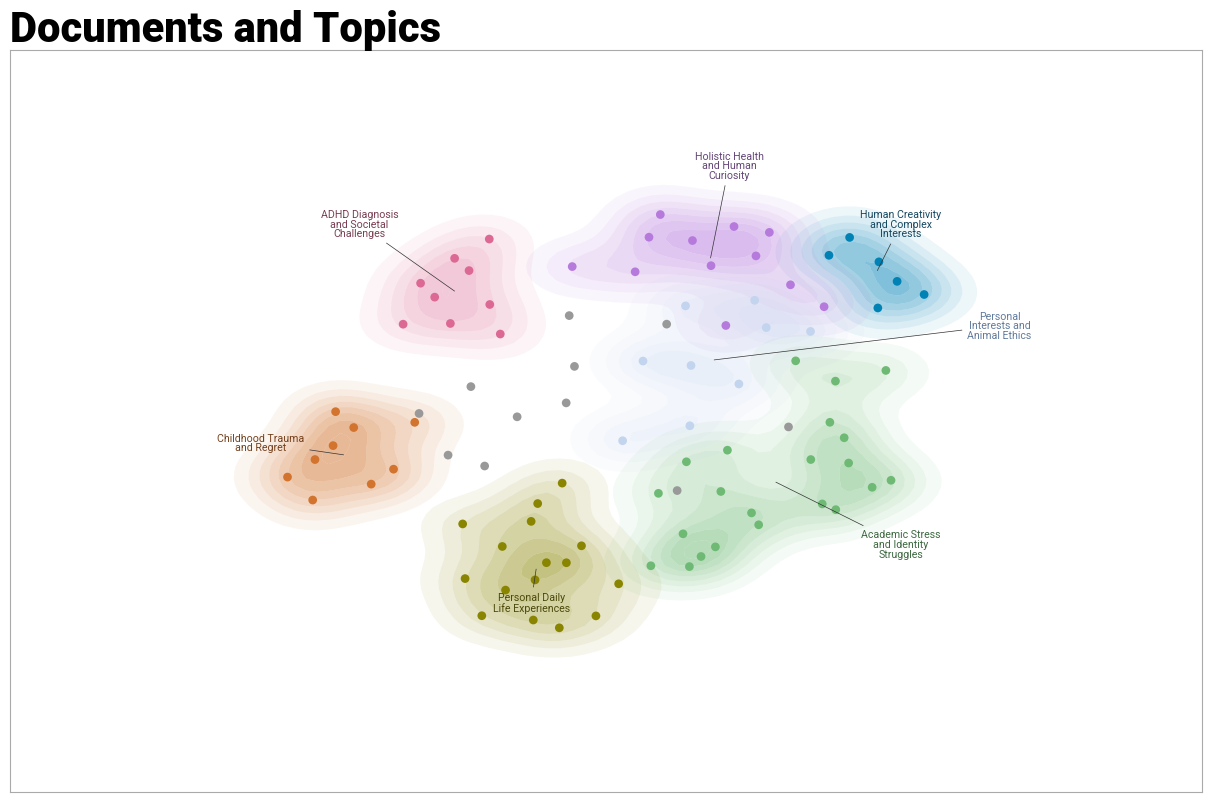

In [22]:
for folder in folders:
    print("=" * 60)
    print(f"Found folder: {folder}")
    print("=" * 60)
    df_group, topic_model, output_folder = preliminary_steps(group_name, folder)
    check_hierarchy(topic_model, df_group, output_folder, group_name)
    run_bertopic_evals(topic_model, df_group, output_folder)
    run_bertopic_viz(topic_model, df_group, output_folder, group_name)

# no-ADHD

In [18]:
group_name = "noADHD"
folders = [name for name in os.listdir(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/") if os.path.isdir(os.path.join(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/", name))]
folders

['3_reduced_27_20250825_015611',
 '20_20250824_225247',
 '12_20250824_225018',
 '6_20250824_224207',
 '2_20250824_221352',
 '15_20250824_225147',
 '10_20250824_224844',
 '3_20250824_222353',
 '5_20250824_223659',
 '8_20250824_224646',
 '7_20250824_224526',
 '4_20250824_223137',
 '25_20250824_225346']

Found folder: 8_20250824_224646
Running preliminary steps for group: noADHD, folder: 8_20250824_224646
noADHD
🔄 Generating hierarchical topics...


100%|██████████| 3/3 [00:00<00:00, 322.15it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_noADHD as PNG: 20250825_023622_bertopic_hierarchy_noadhd.png
📊 Saved bertopic_hierarchy_noADHD as HTML: 20250825_023622_bertopic_hierarchy_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/8_20250824_224646
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 5
📊 Number of real topics (excluding outliers): 4
⚠️  Very few topics detected. Attempting visualization with fallback options...
🔄 Attempting topic visualization with adjusted parameters...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_noADHD as PNG: 20250825_023631_bertopic_topics_noadhd.png
📊 Saved bertopic_topics_noADHD as HTML: 20250825_023631_bertopic_topics_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-port

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...      1   
1    Gosto de ver séries porque relatam relações sa...      1   
2    Campos de ferias. Temos que criar o campo todo...      0   
3    Taylor Swift, amo o seu liricismo e a maneira ...      1   
4    Historia da arte \nÉ só tão interessante. Para...      1   
..                                                 ...    ...   
348  A noção de que procuro ser sempre uma boa pess...      0   
349                                                  —      0   
350  As vezes aborrece-me ter de escrever/responder...      0   
351  Maiores dificuldades que sempre senti.. Concen...      0   
352  Alguém me mande um milagre, I am going crazy, ...      0   

                           Name  \
0    1_gosto_porque_forma_adoro   
1    1_gosto_porque_forma_adoro   
2       0_dia_fazer_hoje_porque   
3    1_gosto_porque_forma_adoro   
4    1_gosto_porque_forma_adoro   
..                          ...   
348     0_dia_fazer_hoje_porque   
349     0_dia_fazer_hoje_porque   
350     0_dia_fazer_hoje_porque   
351     0_dia_fazer_hoje_porque   
352     0_dia_fazer_hoje_porque   

                                        CustomName  \
0                  Personal Interests and Passions   
1                  Personal Interests and Passions   
2    Personal Challenges and Emotional Reflections   
3                  Personal Interests and Passions   
4                  Personal Interests and Passions   
..                                             ...   
348  Personal Challenges and Emotional Reflections   
349  Personal Challenges and Emotional Reflections   
350  Personal Challenges and Emotional Reflections   
351  Personal Challenges and Emotional Reflections   
352  Personal Challenges and Emotional Reflections   

                                        Representation  \
0    [gosto, porque, forma, adoro, ler, interesse, ...   
1    [gosto, porque, forma, adoro, ler, interesse, ...   
2    [dia, fazer, hoje, porque, tempo, sempre, algo...   
3    [gosto, porque, forma, adoro, ler, interesse, ...   
4    [gosto, porque, forma, adoro, ler, interesse, ...   
..                                                 ...   
348  [dia, fazer, hoje, porque, tempo, sempre, algo...   
349  [dia, fazer, hoje, porque, tempo, sempre, algo...   
350  [dia, fazer, hoje, porque, tempo, sempre, algo...   
351  [dia, fazer, hoje, porque, tempo, sempre, algo...   
352  [dia, fazer, hoje, porque, tempo, sempre, algo...   

                                               KeyBERT  \
0    [gosto fazer, livros, viver, sentir, especialm...   
1    [gosto fazer, livros, viver, sentir, especialm...   
2    [fiquei, ia, senti, comecei, comigo, fiz, medo...   
3    [gosto fazer, livros, viver, sentir, especialm...   
4    [gosto fazer, livros, viver, sentir, especialm...   
..                                                 ...   
348  [fiquei, ia, senti, comecei, comigo, fiz, medo...   
349  [fiquei, ia, senti, comecei, comigo, fiz, medo...   
350  [fiquei, ia, senti, comecei, comigo, fiz, medo...   
351  [fiquei, ia, senti, comecei, comigo, fiz, medo...   
352  [fiquei, ia, senti, comecei, comigo, fiz, medo...   

                                              OpenAI  \
0                  [Personal Interests and Passions]   
1                  [Personal Interests and Passions]   
2    [Personal Challenges and Emotional Reflections]   
3                  [Personal Interests and Passions]   
4                  [Personal Interests and Passions]   
..                                               ...   
348  [Personal Challenges and Emotional Reflections]   
349  [Personal Challenges and Emotional Reflections]   
350  [Personal Challenges and Emotional Reflections]   
351  [Personal Challenges and Emotional Reflections]   
352  [Personal Challenges and Emotional Reflections]   

                                                   MMR  \
0    [gosto, adoro, desporto, sentir, livros, espec...   
1    [gosto,

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_noADHD as PNG: 20250825_023632_bertopic_heatmap_noadhd.png
📊 Saved bertopic_heatmap_noADHD as HTML: 20250825_023632_bertopic_heatmap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/8_20250824_224646
------------------------------------------------------------


4it [00:00, 138.34it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_noADHD as PNG: 20250825_023634_bertopic_topics_per_class_noadhd.png
📊 Saved bertopic_topics_per_class_noADHD as HTML: 20250825_023634_bertopic_topics_per_class_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/8_20250824_224646
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_noADHD as PNG: 20250825_023638_bertopic_document_datamap_noadhd.png
📊 Saved bertopic_document_datamap_noADHD as HTML: 20250825_023638_bertopic_document_datamap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/8_20250824_224646
------------------------------------------------------------
✅ Document datamap created successfully
Translating top

100%|██████████| 3/3 [00:00<00:00, 389.18it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_noADHD as PNG: 20250825_023649_bertopic_hierarchy_noadhd.png
📊 Saved bertopic_hierarchy_noADHD as HTML: 20250825_023649_bertopic_hierarchy_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/7_20250824_224526
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 5
📊 Number of real topics (excluding outliers): 4
⚠️  Very few topics detected. Attempting visualization with fallback options...
🔄 Attempting topic visualization with adjusted parameters...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_noADHD as PNG: 20250825_023651_bertopic_topics_noadhd.png
📊 Saved bertopic_topics_noADHD as HTML: 20250825_023651_bertopic_topics_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-port

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...      1   
1    Gosto de ver séries porque relatam relações sa...      1   
2    Campos de ferias. Temos que criar o campo todo...      0   
3    Taylor Swift, amo o seu liricismo e a maneira ...      1   
4    Historia da arte \nÉ só tão interessante. Para...      1   
..                                                 ...    ...   
348  A noção de que procuro ser sempre uma boa pess...      0   
349                                                  —      0   
350  As vezes aborrece-me ter de escrever/responder...      0   
351  Maiores dificuldades que sempre senti.. Concen...      0   
352  Alguém me mande um milagre, I am going crazy, ...      0   

                           Name                       CustomName  \
0    1_gosto_porque_adoro_forma  Personal Interests and Passions   
1    1_gosto_porque_adoro_forma  Personal Interests and Passions   
2       0_dia_fazer_hoje_porque  Personal Daily Life Reflections   
3    1_gosto_porque_adoro_forma  Personal Interests and Passions   
4    1_gosto_porque_adoro_forma  Personal Interests and Passions   
..                          ...                              ...   
348     0_dia_fazer_hoje_porque  Personal Daily Life Reflections   
349     0_dia_fazer_hoje_porque  Personal Daily Life Reflections   
350     0_dia_fazer_hoje_porque  Personal Daily Life Reflections   
351     0_dia_fazer_hoje_porque  Personal Daily Life Reflections   
352     0_dia_fazer_hoje_porque  Personal Daily Life Reflections   

                                        Representation  \
0    [gosto, porque, adoro, forma, ler, interesse, ...   
1    [gosto, porque, adoro, forma, ler, interesse, ...   
2    [dia, fazer, hoje, porque, tempo, sempre, algo...   
3    [gosto, porque, adoro, forma, ler, interesse, ...   
4    [gosto, porque, adoro, forma, ler, interesse, ...   
..                                                 ...   
348  [dia, fazer, hoje, porque, tempo, sempre, algo...   
349  [dia, fazer, hoje, porque, tempo, sempre, algo...   
350  [dia, fazer, hoje, porque, tempo, sempre, algo...   
351  [dia, fazer, hoje, porque, tempo, sempre, algo...   
352  [dia, fazer, hoje, porque, tempo, sempre, algo...   

                                               KeyBERT  \
0    [gosto fazer, livros, viver, sentir, especialm...   
1    [gosto fazer, livros, viver, sentir, especialm...   
2    [fiquei, senti, ia, comecei, comigo, fiz, acab...   
3    [gosto fazer, livros, viver, sentir, especialm...   
4    [gosto fazer, livros, viver, sentir, especialm...   
..                                                 ...   
348  [fiquei, senti, ia, comecei, comigo, fiz, acab...   
349  [fiquei, senti, ia, comecei, comigo, fiz, acab...   
350  [fiquei, senti, ia, comecei, comigo, fiz, acab...   
351  [fiquei, senti, ia, comecei, comigo, fiz, acab...   
352  [fiquei, senti, ia, comecei, comigo, fiz, acab...   

                                OpenAI  \
0    [Personal Interests and Passions]   
1    [Personal Interests and Passions]   
2    [Personal Daily Life Reflections]   
3    [Personal Interests and Passions]   
4    [Personal Interests and Passions]   
..                                 ...   
348  [Personal Daily Life Reflections]   
349  [Personal Daily Life Reflections]   
350  [Personal Daily Life Reflections]   
351  [Personal Daily Life Reflections]   
352  [Personal Daily Life Reflections]   

                                                   MMR  \
0    [gosto, adoro, desporto, sinto, livros, coisas...   
1    [gosto, adoro, desporto, sinto, livros, coisas...   
2    [hoje, tempo, ainda, mim, coisas, apesar, memó...   
3    [gosto, adoro, desporto, sinto, livros, coisas...   
4    [gosto, adoro, desporto, sinto, livros, coisas...   
..                                                 ...   
348  [hoje, tempo, ainda, mim, coisas, apesar, memó...   
349  [hoje, tempo, ainda, mim, coisas, apesar, memó...   
350  [hoje, tempo, ainda, m

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_noADHD as PNG: 20250825_023652_bertopic_heatmap_noadhd.png
📊 Saved bertopic_heatmap_noADHD as HTML: 20250825_023652_bertopic_heatmap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/7_20250824_224526
------------------------------------------------------------


4it [00:00, 137.29it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_noADHD as PNG: 20250825_023654_bertopic_topics_per_class_noadhd.png
📊 Saved bertopic_topics_per_class_noADHD as HTML: 20250825_023654_bertopic_topics_per_class_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/7_20250824_224526
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_noADHD as PNG: 20250825_023657_bertopic_document_datamap_noadhd.png
📊 Saved bertopic_document_datamap_noADHD as HTML: 20250825_023657_bertopic_document_datamap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/7_20250824_224526
------------------------------------------------------------
✅ Document datamap created successfully
Translating top

100%|██████████| 26/26 [00:00<00:00, 555.70it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_noADHD as PNG: 20250825_023709_bertopic_hierarchy_noadhd.png
📊 Saved bertopic_hierarchy_noADHD as HTML: 20250825_023709_bertopic_hierarchy_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/4_20250824_223137
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 28
📊 Number of real topics (excluding outliers): 27
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_noADHD as PNG: 20250825_023711_bertopic_topics_noadhd.png
📊 Saved bertopic_topics_noADHD as HTML: 20250825_023711_bertopic_topics_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/4_20250824_223137
----------------------------------

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...     14   
1    Gosto de ver séries porque relatam relações sa...      2   
2    Campos de ferias. Temos que criar o campo todo...     15   
3    Taylor Swift, amo o seu liricismo e a maneira ...     20   
4    Historia da arte \nÉ só tão interessante. Para...     12   
..                                                 ...    ...   
348  A noção de que procuro ser sempre uma boa pess...     -1   
349                                                  —      5   
350  As vezes aborrece-me ter de escrever/responder...     23   
351  Maiores dificuldades que sempre senti.. Concen...     -1   
352  Alguém me mande um milagre, I am going crazy, ...      0   

                                             Name  \
0                 14_gosto_cozinhar_adoro_felizes   
1                     2_ler_livros_forma_conhecer   
2                       15_campo_criativo_tao_dia   
3        20_história_anime_geralmente_personagens   
4    12_políticas_política_interessante_tentativa   
..                                            ...   
348                      -1_ainda_fazer_hoje_jogo   
349          5_responder_nenhuma_prefiro_escrever   
350        23_questionário_parece_escrever_chegou   
351                      -1_ainda_fazer_hoje_jogo   
352                      0_tarde_acordei_pai_casa   

                                       CustomName  \
0                      Personal Joys and Passions   
1                  Passion for Reading and Travel   
2           Work, Creativity, and Personal Growth   
3    Fantasy, Justice, and Emotional Storytelling   
4                  Politics, History, and Society   
..                                            ...   
348                                 Outlier Topic   
349                Reluctance to Answer Questions   
350    Procrastination and Attention Difficulties   
351                                 Outlier Topic   
352          Daily Routines and Family Challenges   

                                        Representation  \
0    [gosto, cozinhar, adoro, felizes, favoritas, v...   
1    [ler, livros, forma, conhecer, mundo, gosto, s...   
2    [campo, criativo, tao, dia, dias, todos dias, ...   
3    [história, anime, geralmente, personagens, int...   
4    [políticas, política, interessante, tentativa,...   
..                                                 ...   
348  [ainda, fazer, hoje, jogo, dia, tudo, ir, algo...   
349  [responder, nenhuma, prefiro, escrever, dias s...   
350  [questionário, parece, escrever, chegou, aqui,...   
351  [ainda, fazer, hoje, jogo, dia, tudo, ir, algo...   
352  [tarde, acordei, pai, casa, almoço, ir, hoje, ...   

                                               KeyBERT  \
0    [cozinhar, porque gosto, doces, gosto ver, com...   
1    [livros, livro, viajar, ler, viver, viagem, fi...   
2    [trabalho senti, trabalhar, último, ando, faze...   
3    [fantasia, the, anime, magia, principal, histó...   
4    [políticas, politica, política, entender, assu...   
..                                                 ...   
348  [senti, altura, últimos, memória, mim, ir, vez...   
349  [prefiro, nenhuma, responder, tão, pergunta, a...   
350  [escrever, tempo, muitas vezes, dificuldades, ...   
351  [senti, altura, últimos, memória, mim, ir, vez...   
352  [hoje acordei, dormi, acordei, comecei, fiquei...   

                                             OpenAI  \
0                      [Personal Joys and Passions]   
1                  [Passion for Reading and Travel]   
2           [Work, Creativity, and Personal Growth]   
3    [Fantasy, Justice, and Emotional Storytelling]   
4                  [Politics, History, and Society]   
..                                              ...   
348     [Personal Reflections and Daily Challenges]   
349                [Reluctance to Answer Questions]   
350    [Procrastination and Attention Difficulties]   
351     [Personal Reflections and Daily Challen

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_noADHD as PNG: 20250825_023712_bertopic_heatmap_noadhd.png
📊 Saved bertopic_heatmap_noADHD as HTML: 20250825_023712_bertopic_heatmap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/4_20250824_223137
------------------------------------------------------------


4it [00:00, 96.18it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_noADHD as PNG: 20250825_023714_bertopic_topics_per_class_noadhd.png
📊 Saved bertopic_topics_per_class_noADHD as HTML: 20250825_023714_bertopic_topics_per_class_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/4_20250824_223137
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_noADHD as PNG: 20250825_023719_bertopic_document_datamap_noadhd.png
📊 Saved bertopic_document_datamap_noADHD as HTML: 20250825_023719_bertopic_document_datamap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/4_20250824_223137
------------------------------------------------------------
✅ Document datamap created successfully
Translating top

100%|██████████| 1/1 [00:00<00:00, 322.29it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_noADHD as PNG: 20250825_023808_bertopic_hierarchy_noadhd.png
📊 Saved bertopic_hierarchy_noADHD as HTML: 20250825_023808_bertopic_hierarchy_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/25_20250824_225346
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 3
📊 Number of real topics (excluding outliers): 2
⚠️  Cannot create topic visualization: Need at least 3 real topics
💡 This model has too few distinct topics for meaningful visualization
Silhouette score calculated on 299 documents across 2 topics
Silhouette Score: 0.0579
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.4577
Individual Topic Coherences:
  Topic 0: -1.3046
  Topic 1: -1.6109
Coherence results saved to ../../outputs/bertopic_tuning/noADHD/2

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...      1   
1    Gosto de ver séries porque relatam relações sa...      1   
2    Campos de ferias. Temos que criar o campo todo...      0   
3    Taylor Swift, amo o seu liricismo e a maneira ...      1   
4    Historia da arte \nÉ só tão interessante. Para...      1   
..                                                 ...    ...   
348  A noção de que procuro ser sempre uma boa pess...      0   
349                                                  —      0   
350  As vezes aborrece-me ter de escrever/responder...      0   
351  Maiores dificuldades que sempre senti.. Concen...      0   
352  Alguém me mande um milagre, I am going crazy, ...      0   

                           Name                                  CustomName  \
0    1_gosto_porque_forma_adoro             Personal Interests and Passions   
1    1_gosto_porque_forma_adoro             Personal Interests and Passions   
2       0_dia_fazer_hoje_porque  Personal Daily Experiences and Reflections   
3    1_gosto_porque_forma_adoro             Personal Interests and Passions   
4    1_gosto_porque_forma_adoro             Personal Interests and Passions   
..                          ...                                         ...   
348     0_dia_fazer_hoje_porque  Personal Daily Experiences and Reflections   
349     0_dia_fazer_hoje_porque  Personal Daily Experiences and Reflections   
350     0_dia_fazer_hoje_porque  Personal Daily Experiences and Reflections   
351     0_dia_fazer_hoje_porque  Personal Daily Experiences and Reflections   
352     0_dia_fazer_hoje_porque  Personal Daily Experiences and Reflections   

                                        Representation  \
0    [gosto, porque, forma, adoro, interesse, ler, ...   
1    [gosto, porque, forma, adoro, interesse, ler, ...   
2    [dia, fazer, hoje, porque, tempo, sempre, algo...   
3    [gosto, porque, forma, adoro, interesse, ler, ...   
4    [gosto, porque, forma, adoro, interesse, ler, ...   
..                                                 ...   
348  [dia, fazer, hoje, porque, tempo, sempre, algo...   
349  [dia, fazer, hoje, porque, tempo, sempre, algo...   
350  [dia, fazer, hoje, porque, tempo, sempre, algo...   
351  [dia, fazer, hoje, porque, tempo, sempre, algo...   
352  [dia, fazer, hoje, porque, tempo, sempre, algo...   

                                               KeyBERT  \
0    [viver, momentos, livros, sentir, especialment...   
1    [viver, momentos, livros, sentir, especialment...   
2    [fiquei, senti, ia, comecei, comigo, fiz, acab...   
3    [viver, momentos, livros, sentir, especialment...   
4    [viver, momentos, livros, sentir, especialment...   
..                                                 ...   
348  [fiquei, senti, ia, comecei, comigo, fiz, acab...   
349  [fiquei, senti, ia, comecei, comigo, fiz, acab...   
350  [fiquei, senti, ia, comecei, comigo, fiz, acab...   
351  [fiquei, senti, ia, comecei, comigo, fiz, acab...   
352  [fiquei, senti, ia, comecei, comigo, fiz, acab...   

                                           OpenAI  \
0               [Personal Interests and Passions]   
1               [Personal Interests and Passions]   
2    [Personal Daily Experiences and Reflections]   
3               [Personal Interests and Passions]   
4               [Personal Interests and Passions]   
..                                            ...   
348  [Personal Daily Experiences and Reflections]   
349  [Personal Daily Experiences and Reflections]   
350  [Personal Daily Experiences and Reflections]   
351  [Personal Daily Experiences and Reflections]   
352  [Personal Daily Experiences and Reflections]   

                                                   MMR  \
0    [gosto, adoro, ver, sentir, coisas, livros, vi...   
1    [gosto, adoro, ver, sentir, coisas, livros, vi...   
2    [hoje, tempo, mim, coisas, tarde, apesar, memó...   
3    [gosto, adoro, ver, sentir, coisas, livros, vi..

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_noADHD as PNG: 20250825_023810_bertopic_heatmap_noadhd.png
📊 Saved bertopic_heatmap_noADHD as HTML: 20250825_023810_bertopic_heatmap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/25_20250824_225346
------------------------------------------------------------


4it [00:00, 132.21it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_noADHD as PNG: 20250825_023812_bertopic_topics_per_class_noadhd.png
📊 Saved bertopic_topics_per_class_noADHD as HTML: 20250825_023812_bertopic_topics_per_class_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/25_20250824_225346
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_noADHD as PNG: 20250825_023815_bertopic_document_datamap_noadhd.png
📊 Saved bertopic_document_datamap_noADHD as HTML: 20250825_023815_bertopic_document_datamap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/25_20250824_225346
------------------------------------------------------------
✅ Document datamap created successfully
Translating t

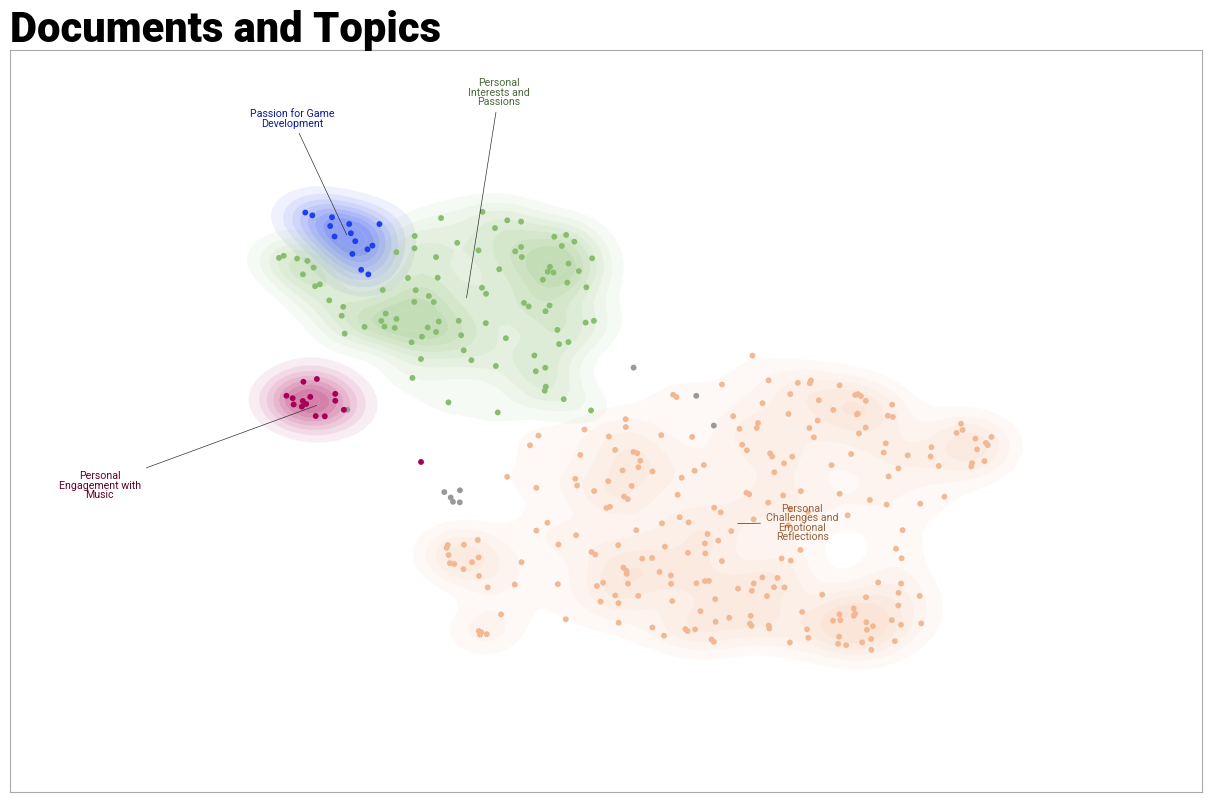

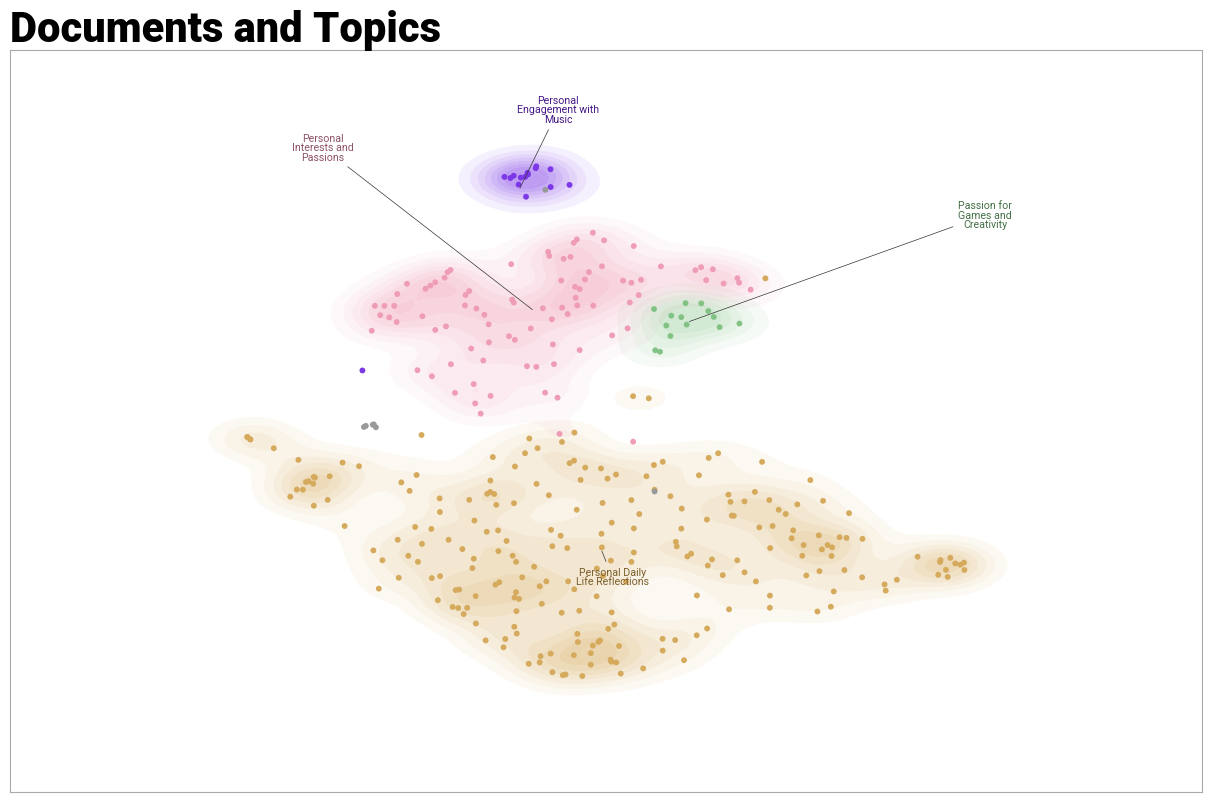

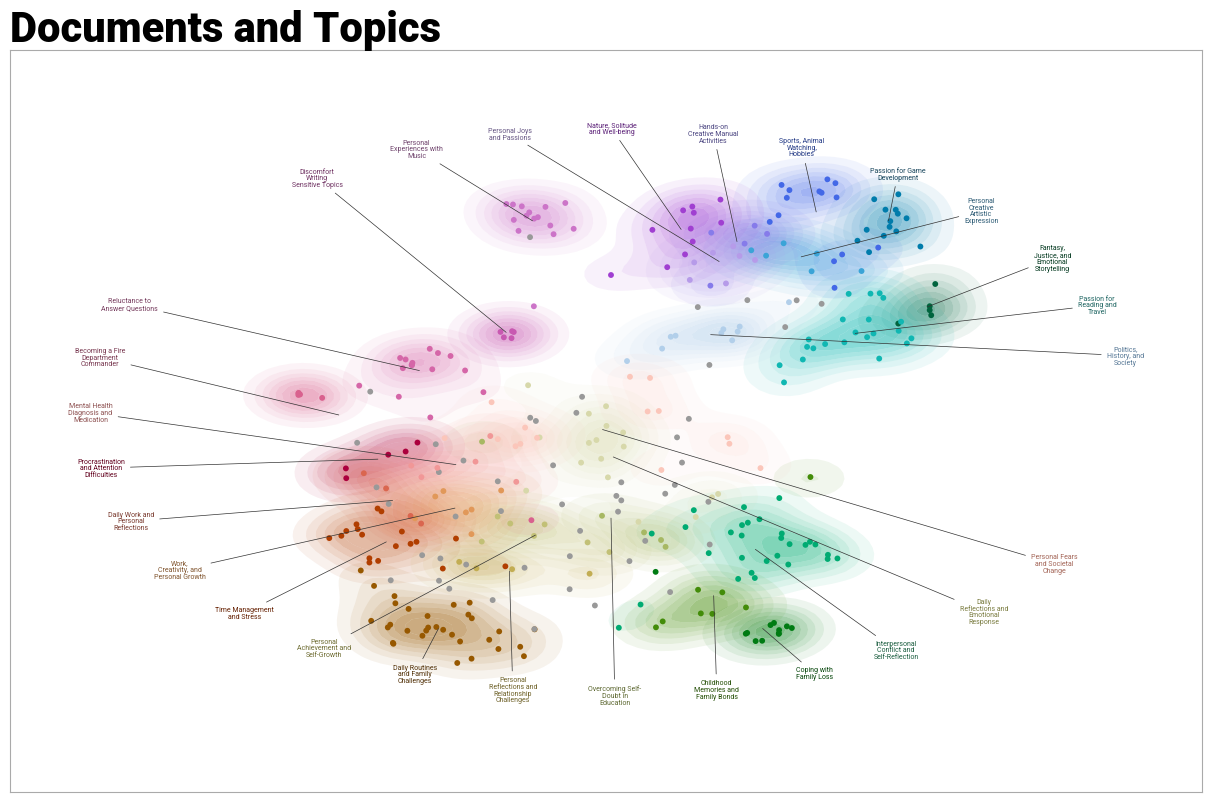

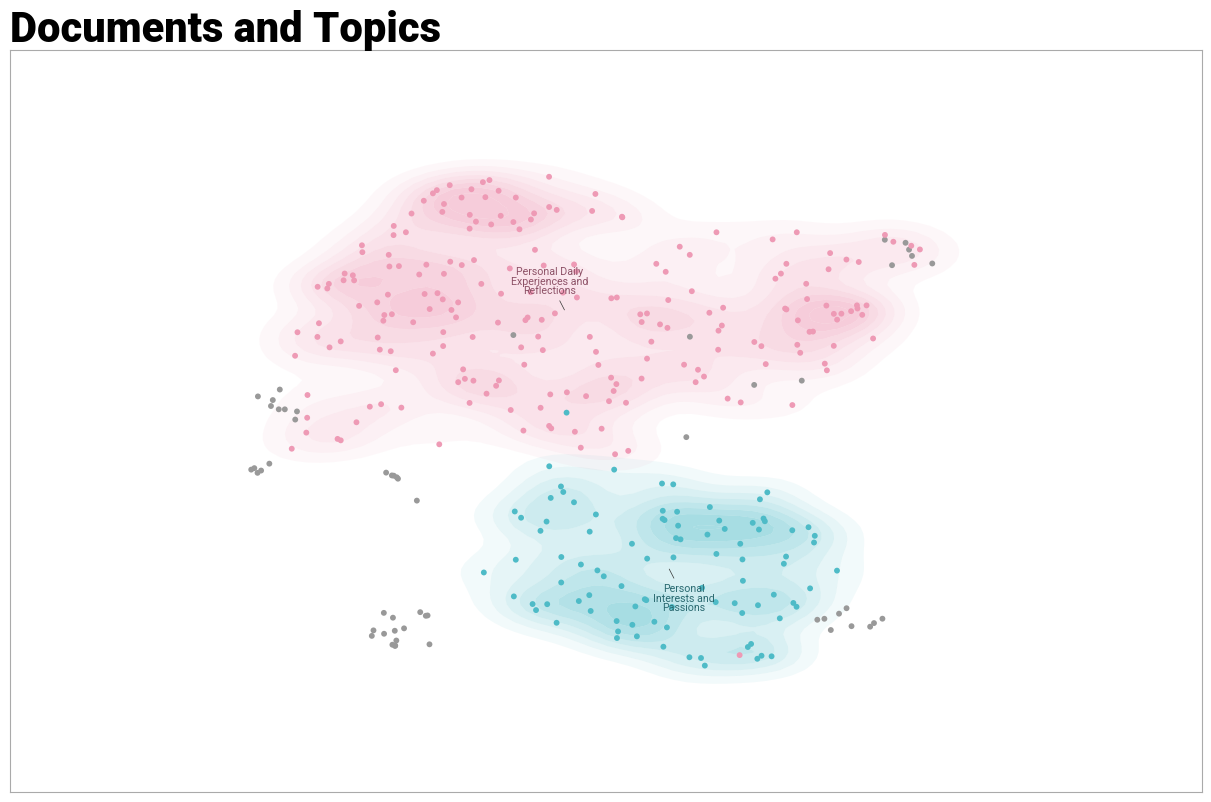

In [20]:
for folder in folders:
    print("=" * 60)
    print(f"Found folder: {folder}")
    print("=" * 60)
    df_group, topic_model, output_folder = preliminary_steps(group_name, folder)
    check_hierarchy(topic_model, df_group, output_folder, group_name)
    run_bertopic_evals(topic_model, df_group, output_folder)
    run_bertopic_viz(topic_model, df_group, output_folder, group_name)